In [1]:
!pip install ecg-plot

In [2]:
!pip install torch-summary

In [3]:
!pip install shap

In [4]:
!pip install lime

In [5]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.5/368.5 kB 7.3 MB/s eta 0:00:00a 0:00:01


In [6]:
import sys
sys.path.append('/kaggle/input/mscproject-data/')

#import script.helper_code as hc
import os
import warnings
from scipy.io import loadmat

import ecg_plot
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import signal
from sklearn.metrics import roc_curve,auc

import torch
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

import sklearn
import shap
import lime
import tslearn
from lime import explanation
from lime import lime_base
from lime import lime_tabular
from learning_shapelets import LearningShapelets
from tslearn.clustering import TimeSeriesKMeans

warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

Using device: cuda


In [7]:
seed_value = 123
np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

torch.backends.cudnn.deterministic = True

# Visualize ecg

In [8]:
def load_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float32)
    new_file = filename.replace('.mat','.hea')
    input_header = os.path.join(new_file)
    with open(input_header,'r') as f:
        header_data = f.readlines()
    return data, header_data

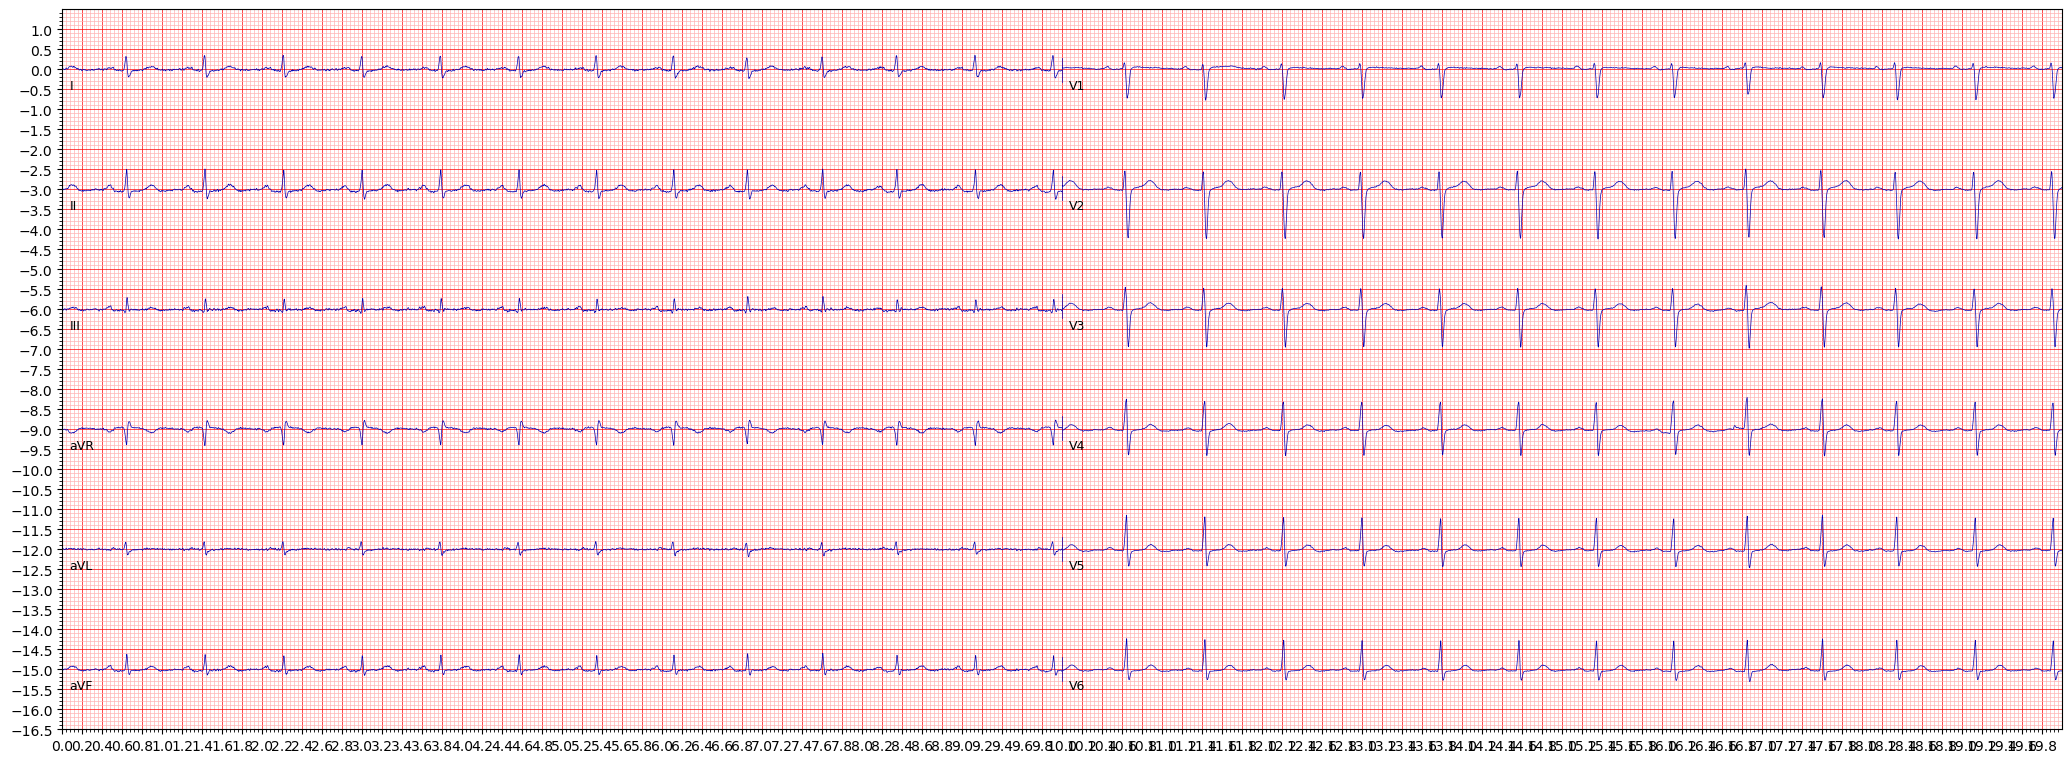

In [9]:
def plot_ecg(path):
    ecg_data = load_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
plot_ecg('/kaggle/input/mscproject-data/mscproject_data/mscproject_dataset/A0002.mat')

# Annalyze data

In [9]:
def get_key_data(path):
    gender = []
    age = []
    labels = []
    ecg_filenames = []
    
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = subdir +os.sep+filename
            if filepath.endswith('.mat'):
                data, header_data = load_data(filepath)
                labels.append(header_data[15].split(': ')[1].split('\n')[0])
                gender.append(header_data[14].split(': ')[1].split('\n')[0])
                age.append(header_data[13].split(': ')[1].split('\n')[0])
                ecg_filenames.append(filepath)
    return gender, age, labels, ecg_filenames
gender, age, labels, ecg_filenames = get_key_data('/kaggle/input/mscproject-data/')
ecg_filenames = np.asarray(ecg_filenames)

In [10]:
def make_labels(labels):
    test_labels = pd.DataFrame(labels)
    test_labels.replace(to_replace='426783006', inplace=True, value='Normal', regex=True)
    test_labels.replace(to_replace='164889003', inplace=True, value='AF', regex=True)
    test_labels.replace(to_replace=r'\d',inplace=True,value='',regex=True)
    
    #test_labels[0] = test_labels[0].apply(lambda x: 'AF' if('AF' in x and any(c.isdigit() for c in x)) else x)
    #test_labels = test_labels[~(test_labels[0].str.contains('Normal') & test_labels[0].str.contains(r'\d'))]
    test_labels[0] = test_labels[0].str.replace('AF,Normal', 'AF')
    test_labels[0] = test_labels[0].str.replace(',','')
    test_labels[0] = test_labels[0].str.replace('AFNormal', 'AF')
    return test_labels
c_labels_df = make_labels(labels)
c_labels_df

0
0      Normal
1      Normal
2      Normal
3      Normal
4          AF
...       ...
34184  Normal
34185  Normal
34186  Normal
34187  Normal
34188      AF

[34189 rows x 1 columns]

Normal    28934
AF         5255
Name: 0, dtype: int64


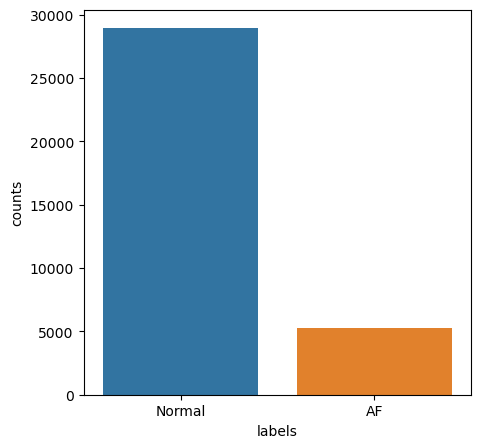

In [11]:
def plot_labels():
    class_count = c_labels_df[0].value_counts()
    print(class_count)
    
    plt.figure(figsize=(5,5))
    sns.barplot(x=class_count.index, y=class_count.values)
    plt.ylabel('counts')
    plt.xlabel('labels')
    plt.show()
plot_labels()

nomal more than af too much. delect some normal??(easy way

## Clean age and gender

In [12]:
def clean_gender(gender):
    gender = np.asarray(gender)
    gender[np.where(gender=='Male')]=0
    gender[np.where(gender=='male')]=0
    gender[np.where(gender=='M')]=0
    gender[np.where(gender=='Female')]=1
    gender[np.where(gender=='female')]=1
    gender[np.where(gender=='F')]=1
    gender[np.where(gender=='Nan')]=2
    gender[np.where(gender=='Unknown')]=2
    np.unique(gender)
    gender = gender.astype(np.int)
    return gender
c_gender=clean_gender(gender)
c_gender.shape

(34189,)

In [13]:
def clean_age(age):
    age = np.asarray(age)
    age[np.where(age=='NaN')]=-1
    np.unique(age)
    age = age.astype(np.int)
    return age
c_age = clean_age(age)
c_age.shape

(34189,)

In [14]:
c_gender_df = pd.DataFrame(c_gender)
c_age_df = pd.DataFrame(c_age)
ecg_filenames_df = pd.DataFrame(ecg_filenames)

info_df = pd.concat([ecg_filenames_df,c_gender_df,c_age_df,c_labels_df],axis=1)
info_df.columns = ['filenames','gender','age','label']
info_df

filenames  gender  age   label
0      /kaggle/input/mscproject-data/mscproject_data/...       1   48  Normal
1      /kaggle/input/mscproject-data/mscproject_data/...       0   61  Normal
2      /kaggle/input/mscproject-data/mscproject_data/...       0   67  Normal
3      /kaggle/input/mscproject-data/mscproject_data/...       1   69  Normal
4      /kaggle/input/mscproject-data/mscproject_data/...       0   73      AF
...                                                  ...     ...  ...     ...
34184  /kaggle/input/mscproject-data/mscproject_data/...       0   46  Normal
34185  /kaggle/input/mscproject-data/mscproject_data/...       1   74  Normal
34186  /kaggle/input/mscproject-data/mscproject_data/...       0   58  Normal
34187  /kaggle/input/mscproject-data/mscproject_data/...       0   47  Normal
34188  /kaggle/input/mscproject-data/mscproject_data/...       1   92      AF

[34189 rows x 4 columns]

In [15]:
# balance Normal and AF

normal_data = info_df[info_df['label']=='Normal'].sample(n=5255, random_state=42)
af_data = info_df[info_df['label']=='AF']
fin_df = pd.concat([normal_data, af_data],axis=0,ignore_index=True)
fin_df
#fin_df['filenames'][0] ---> '/kaggle/input/mscproject-data/mscproject_dataset/HR02655.mat'

filenames  gender  age   label
0      /kaggle/input/mscproject-data/mscproject_data/...       0   78  Normal
1      /kaggle/input/mscproject-data/mscproject_data/...       0   72  Normal
2      /kaggle/input/mscproject-data/mscproject_data/...       0   76  Normal
3      /kaggle/input/mscproject-data/mscproject_data/...       1   54  Normal
4      /kaggle/input/mscproject-data/mscproject_data/...       1   64  Normal
...                                                  ...     ...  ...     ...
10505  /kaggle/input/mscproject-data/mscproject_data/...       0   67      AF
10506  /kaggle/input/mscproject-data/mscproject_data/...       0   68      AF
10507  /kaggle/input/mscproject-data/mscproject_data/...       0   82      AF
10508  /kaggle/input/mscproject-data/mscproject_data/...       0   59      AF
10509  /kaggle/input/mscproject-data/mscproject_data/...       1   92      AF

[10510 rows x 4 columns]

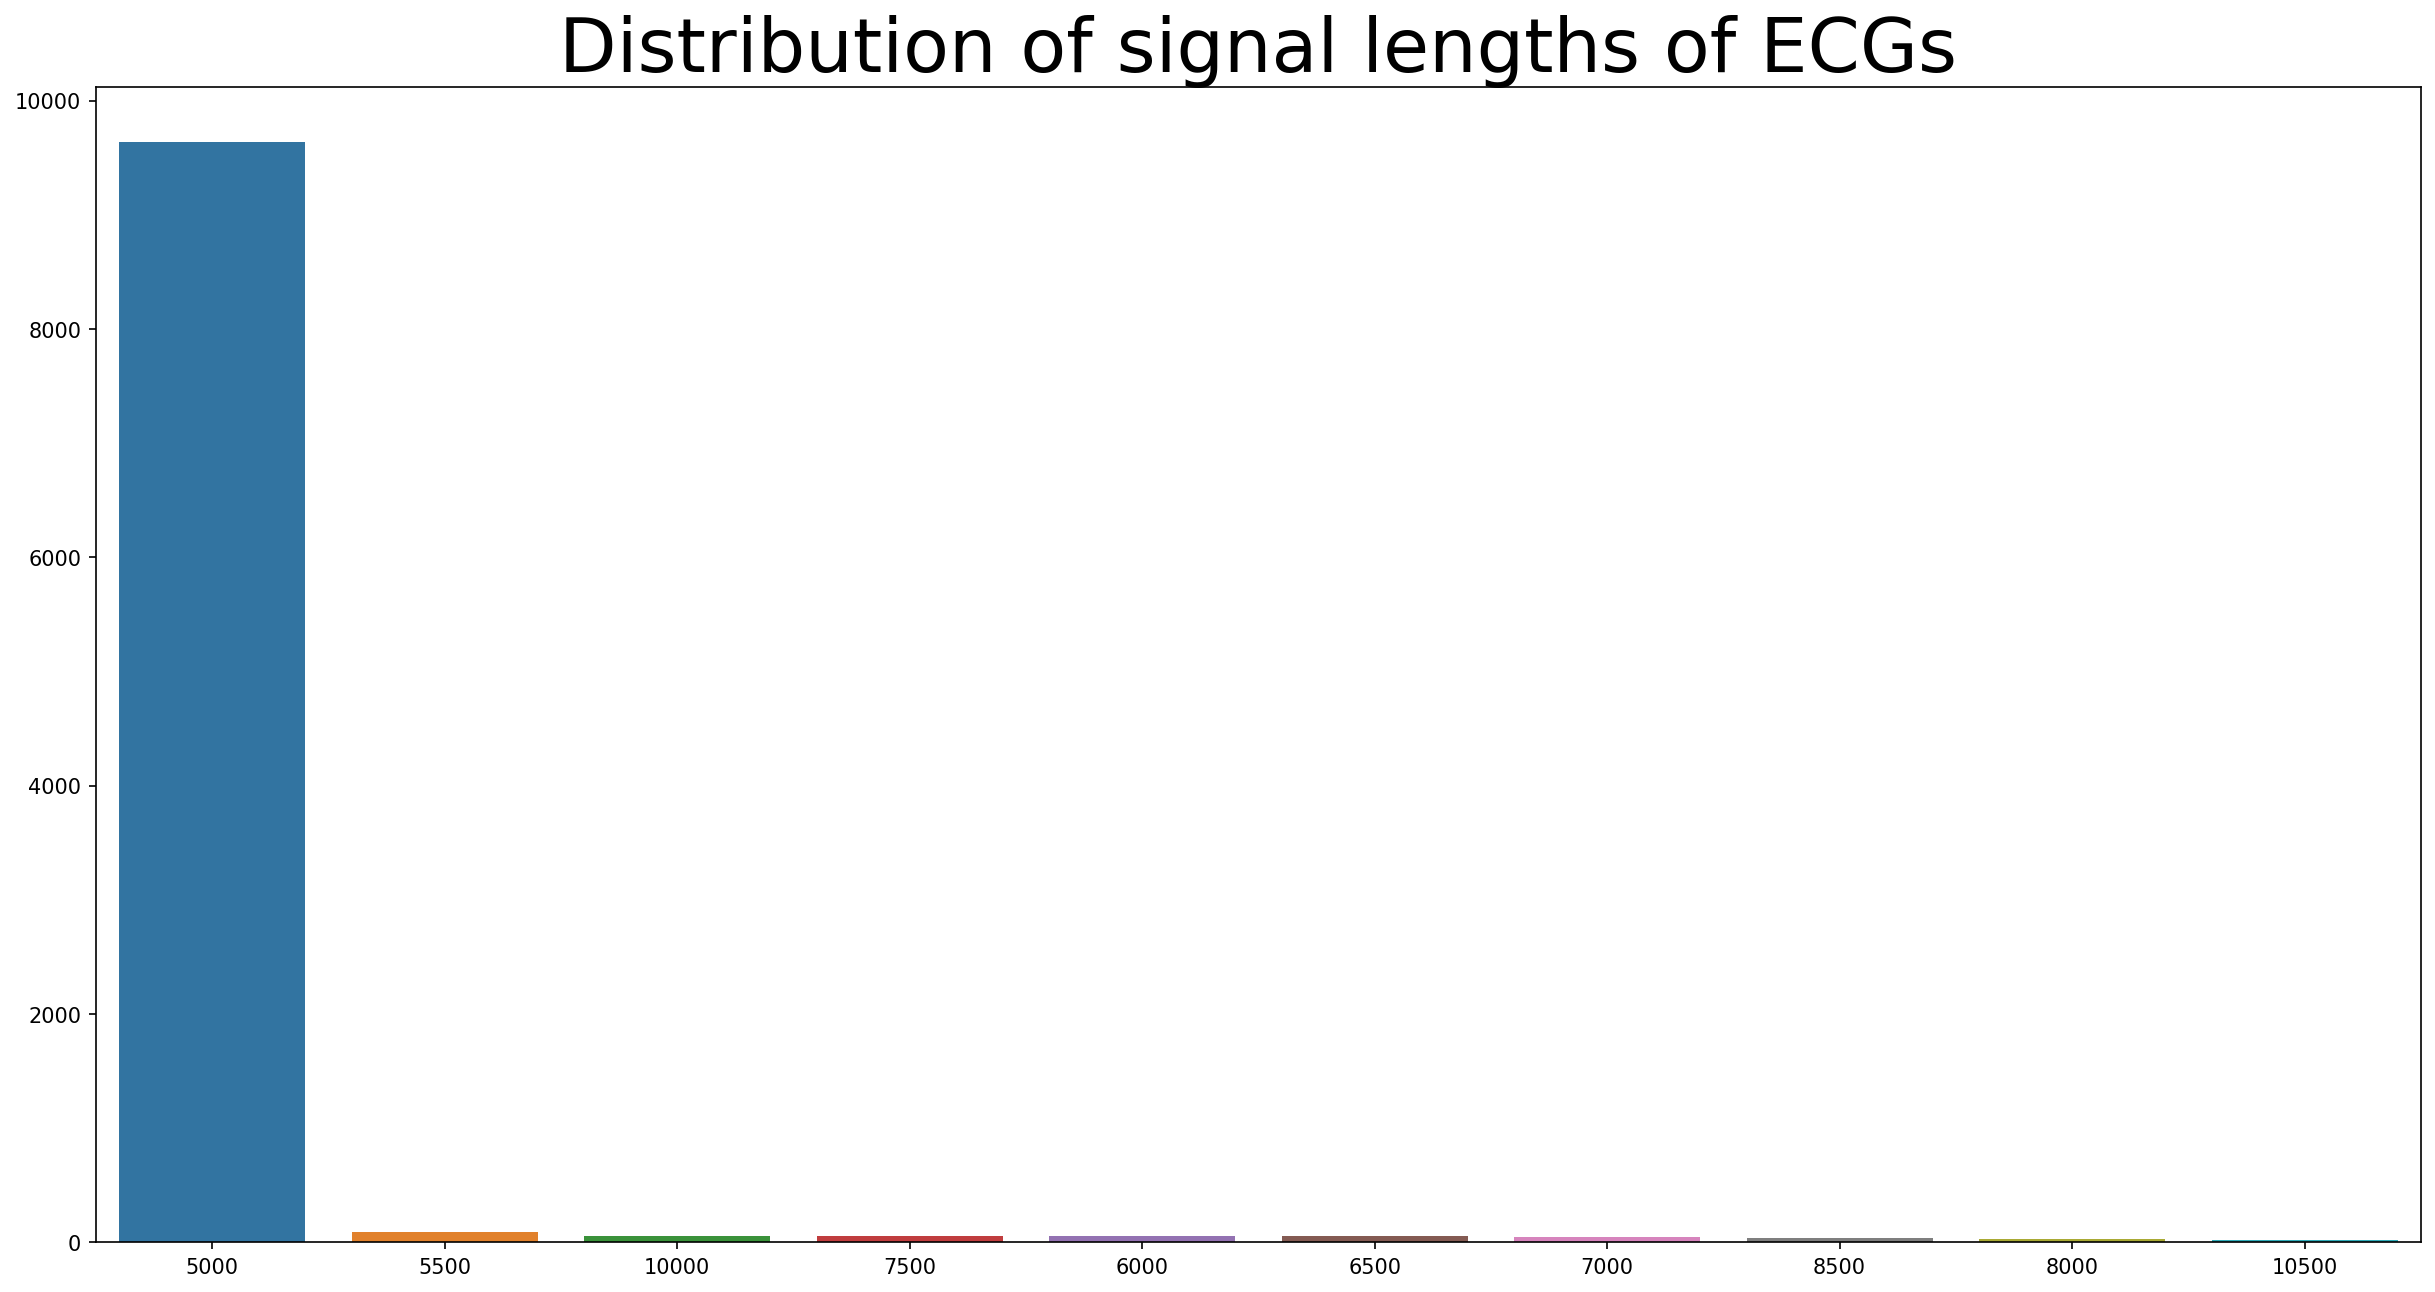

In [16]:
def signal_len(df, title):
    signal_len = []
    for path in df['filenames']:
        data,header_data = load_data(path)
        splited = header_data[0].split()
        signal_len.append(splited[3])
    signal_len_df = pd.DataFrame(signal_len)
    signal_count = signal_len_df[0].value_counts()
    plt.figure(figsize=(20,10),dpi=150)
    plt.title(title,fontsize=36)
    sns.barplot(x=signal_count[:10,].index, y=signal_count[:10,].values)
signal_len(fin_df, 'Distribution of signal lengths of ECGs')

most of signal lengths is 5000, can select 5000 (eg. 5000 in 7500), or pad to 5000 (eg. 4900 pad0 to 5000

## analyze gender and age

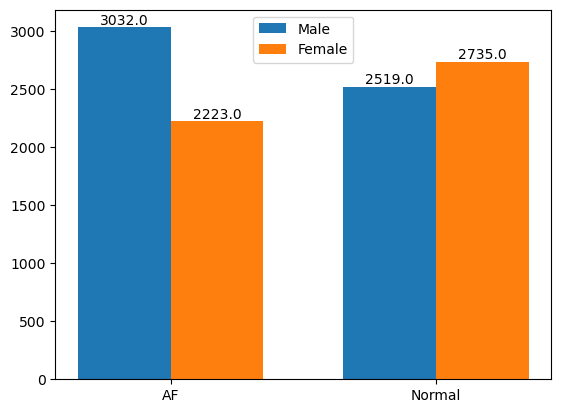

In [17]:
group_gender = fin_df.groupby(['gender','label']).size().unstack()

fig,ax = plt.subplots()
width = 0.35

# male
male = group_gender.loc[0]
x_male = range(len(male))
ax.bar(x_male, male, width, label='Male')

# female
female = group_gender.loc[1]
x_female = [x+width for x in x_male]
ax.bar(x_female, female, width, label='Female')

x_labels = group_gender.columns
x_ticks = [x+width/2 for x in x_male]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)

# count number
for i,v in enumerate(male):
    ax.text(i,v,str(v),ha='center',va='bottom')
for i,v in enumerate(female):
    ax.text(i+width,v,str(v),ha='center',va='bottom')

ax.legend()
plt.show()

even balance, but can find gender have corelation with disease (eg.male have more possible have af

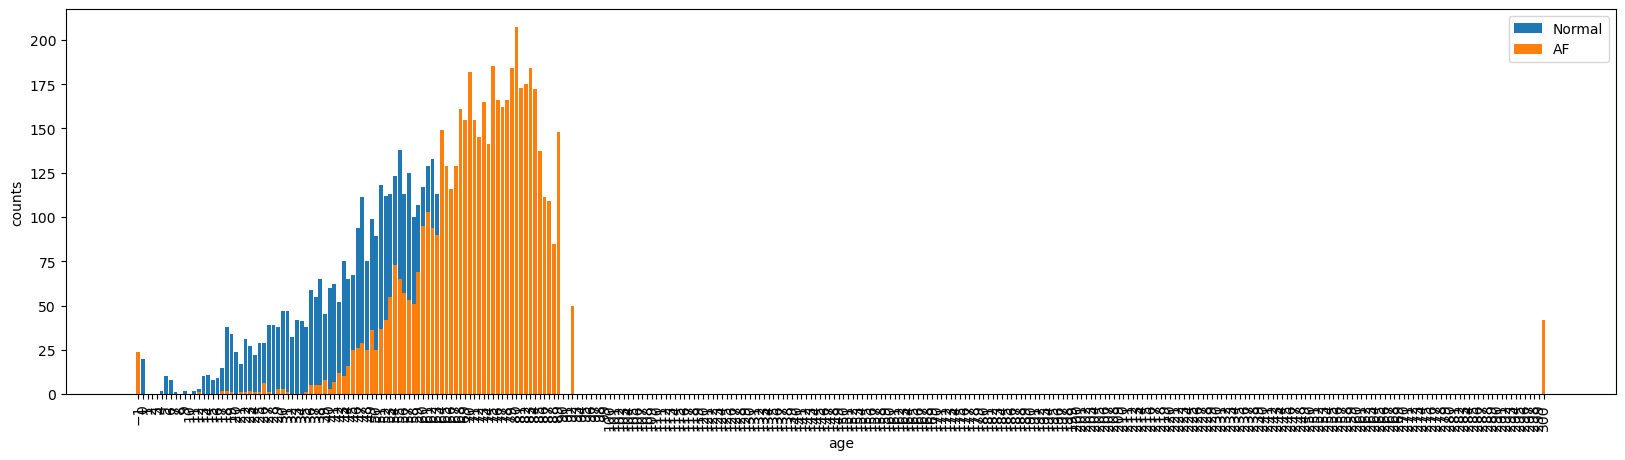

In [18]:
group_age = fin_df.groupby('label')['age'].value_counts().unstack()
labels = fin_df['label'].unique()

plt.figure(figsize=(20,5))
for i,label in enumerate(labels):
    x = group_age.loc[label].index
    y = group_age.loc[label].values
    plt.bar(x,y,label=label)

plt.xticks(range(min(fin_df['age']),max(fin_df['age'])+1),rotation=90)
plt.xlabel('age')
plt.ylabel('counts')
plt.legend()
plt.show()

500 age?? something wrong, if necessary, delete 500 and -1(unknown

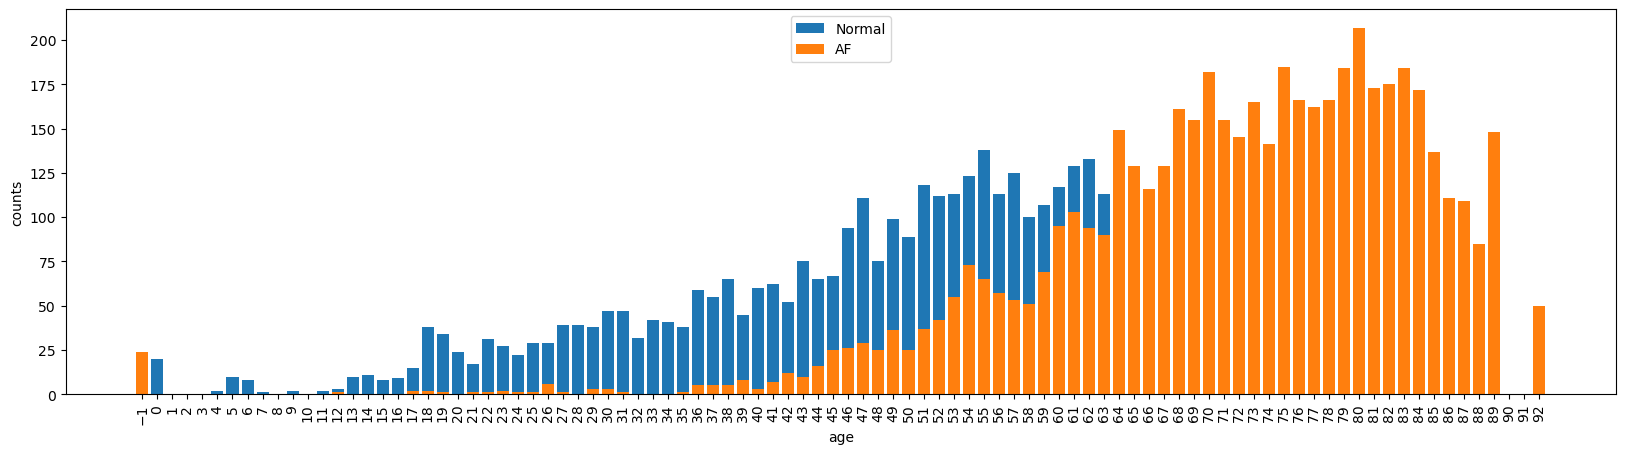

In [19]:
age100_df = fin_df[fin_df['age']<100]
group_age1 = age100_df.groupby('label')['age'].value_counts().unstack()
labels1 = age100_df['label'].unique()

plt.figure(figsize=(20,5))
for i,label in enumerate(labels1):
    x = group_age1.loc[label].index
    y = group_age1.loc[label].values
    plt.bar(x,y,label=label)

plt.xticks(range(min(age100_df['age']),max(age100_df['age'])+1),rotation=90)
plt.xlabel('age')
plt.ylabel('counts')
plt.legend()
plt.show()

In [20]:
# mean age
avg_normal_age = age100_df[age100_df['label']=='Normal']['age'].mean().astype(np.int)
avg_af_age = age100_df[age100_df['label']=='AF']['age'].mean().astype(np.int)

print('avg age in Normal is: ', avg_normal_age)
print('avg age in AF is: ', avg_af_age)

avg age in Normal is:  55
avg age in AF is:  71


age also have corelation with disease (eg. older more af

and more data after 40...older more focus on health problem?

# Create dataset and dataloader

In [21]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

grouped = fin_df.groupby('label')
group_counts = grouped.size()

total_num = len(fin_df)
train_num = int(train_ratio*total_num)
val_num = int(val_ratio*total_num)
test_num = total_num - train_num - val_num

train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

for group_name,group_data in grouped:
    group_count = group_counts[group_name]
    train_count = int(train_num*(group_count/total_num))
    val_count = int(val_num*(group_count/total_num))
    test_count = group_count-train_count-val_count
    
    train_samples = group_data.sample(train_count,random_state=42)
    val_samples = group_data.drop(train_samples.index).sample(val_count,random_state=42)
    test_samples = group_data.drop(train_samples.index).drop(val_samples.index)
    
    #train_df = train_df.append(train_samples)
    train_df = pd.concat([train_df,pd.DataFrame(train_samples)],ignore_index=True)
    #val_df = val_df.append(val_samples)
    val_df = pd.concat([val_df,pd.DataFrame(val_samples)],ignore_index=True)
    #test_df = test_df.append(test_samples)
    test_df = pd.concat([test_df,pd.DataFrame(test_samples)],ignore_index=True)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('train size: ', len(train_df))
print('val size: ', len(val_df))
print('test size: ', len(test_df))

train size:  7356
val size:  2102
test size:  1052


In [22]:
# can change, after LR to find out better
three_leads = ['aVF','V5','V6']

def get_leads(header):
    leads = list()
    for i,l in enumerate(header):
        entries = l.split(' ')
        if i == 0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            leads.append(entries[-1].split('\n')[0])
        else:
            break
    return tuple(leads)

def choose_leads(data,header,leads):
    num_leads = len(leads)
    num_samples = np.shape(data)[1]
    chosen_recording = np.zeros((num_leads, num_samples), data.dtype)
    available_leads = get_leads(header)
    for i,lead in enumerate(leads):
        if lead in available_leads:
            j = available_leads.index(lead)
            chosen_recording[i,:] = data[j,:]
    return chosen_recording

In [23]:
# data preprocess
def get_adc_gains(header,leads):
    adc_gains = np.zeros(len(leads))
    for i,l in enumerate(header):
        entries = l.split(' ')
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            current_lead = entries[-1].split('\n')[0]
            #print(current_lead)
            if current_lead in leads:
                j = leads.index(current_lead)
                #print(j)
                try:
                    adc_gains[j] = float(entries[2].split('(')[0])
                    #print(adc_gains[j])
                except:
                    pass
        else:
            break
    return adc_gains

def get_baselines(header,leads):
    baselines = np.zeros(len(leads))
    for i,l in enumerate(header):
        entries = l.split(' ')
        #print(entries)
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            current_lead = entries[-1].split('\n')[0]
            if current_lead in leads:
                j = leads.index(current_lead)
                #print(entries[4])
                try:
                    baselines[j] = float(entries[4].split('/')[0])
                except:
                    pass
        else:
            break
    return baselines

In [24]:
# resample to 500hz
def resample(header,data):
    fs = float(header[0].split(' ')[2])
    if fs==float(1000):
        data = signal.resample_poly(data,up=1,down=2,axis=-1)
        fs=500
    elif fs==float(500):
        pass
    else:
        data = signal.resample(data,int(data.shape[1]*500/fs),axis=1)
        fs=500
    return data

# set filter
def filt(data):
    b,a = signal.butter(3,[1/250, 47/250],'bandpass')
    data = signal.filtfilt(b,a,data)
    return data

# normaliza
def norm(data):
    mu = np.nanmean(data,axis=-1,keepdims=True)
    std = np.nanstd(data,axis=-1,keepdims=True)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        data = (data-mu)/std
    data = np.nan_to_num(data)
    return data

In [25]:
# raw data
data_ex,header_ex = load_data(fin_df['filenames'][0])
ecg_data_ex = choose_leads(data_ex,header_ex,three_leads)

# process data
data_psc = resample(header_ex,data_ex)
data_psc = filt(data_psc)
data_psc = norm(data_psc)
ecg_data_psc = choose_leads(data_psc,header_ex,three_leads)
adc_gains = get_adc_gains(header_ex,three_leads)
baselines = get_baselines(header_ex,three_leads)
for i in range(len(three_leads)):
    ecg_data_psc[i,:] = (ecg_data_psc[i,:]-baselines[i])/adc_gains[i]
ecg_data_psc.shape

(3, 5000)

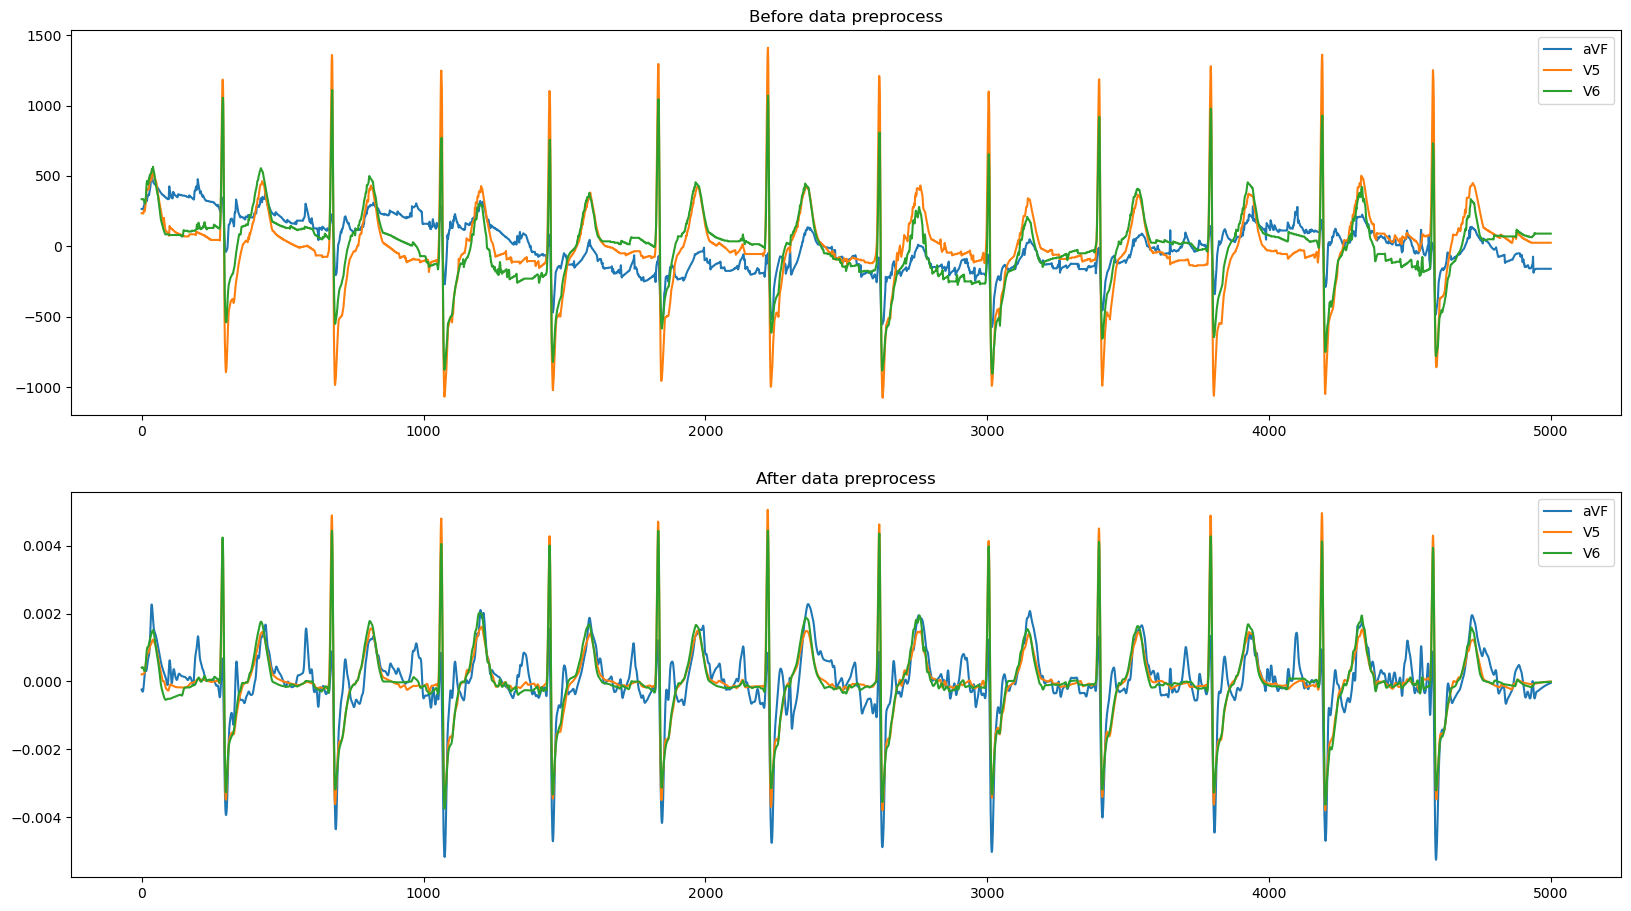

In [26]:
x = np.arange(5000)
plt.figure(figsize=(20,11))

plt.subplot(2,1,1)
plt.plot(x,ecg_data_ex[0],label='aVF')
plt.plot(x,ecg_data_ex[1],label='V5')
plt.plot(x,ecg_data_ex[2],label='V6')
plt.legend()
plt.title('Before data preprocess')

plt.subplot(2,1,2)
plt.plot(x,ecg_data_psc[0],label='aVF')
plt.plot(x,ecg_data_psc[1],label='V5')
plt.plot(x,ecg_data_psc[2],label='V6')
plt.legend()
plt.title('After data preprocess')
plt.show()

In [27]:
labels_integer = {'Normal':0, 'AF':1}
class ECGDataset(data.Dataset):
    def __init__(self,df,leads,max_len=5000):
        self.df = df
        self.max_len = max_len
        self.leads = leads
        
    def __getitem__(self,index):
        filename = self.df['filenames'][index]
        data,header = load_data(self.df['filenames'][index])
        init_ecg_data = choose_leads(data,header,self.leads)
        label = torch.tensor(labels_integer[self.df['label'][index]])
        
        #data preprocess
        psc_ecg_data = resample(header,init_ecg_data)
        psc_ecg_data = filt(psc_ecg_data)
        psc_ecg_data = norm(psc_ecg_data)
        adc_gains = get_adc_gains(header,self.leads)
        baselines = get_baselines(header,self.leads)
        for i in range(len(self.leads)):
            psc_ecg_data[i,:] = (psc_ecg_data[i,:]-baselines[i])/adc_gains[i]
        
        # <max_len --> pad 0 /// >max_len ---> select 0:max_len
        if psc_ecg_data.shape[1]>=self.max_len:
            ecg_data = torch.tensor(psc_ecg_data[:,0:self.max_len])
        elif psc_ecg_data.shape[1]<self.max_len:
            pad = self.max_len-psc_ecg_data.shape[1]
            ecg_data = np.hstack((psc_ecg_data, np.zeros((psc_ecg_data.shape[0], pad))))
            ecg_data = torch.tensor(ecg_data)
        
        return filename,ecg_data,label
        
    def __len__(self):
        return len(self.df)

In [28]:
train_set = ECGDataset(train_df,three_leads)
print(train_set[0][1])
print(train_set[0][2])

val_set = ECGDataset(val_df,three_leads)

tensor([[ 8.9383e-05,  2.2946e-04,  3.7711e-04,  ..., -5.3528e-05,
         -2.1398e-06,  6.1233e-05],
        [ 1.0593e-04,  1.1573e-04,  1.2157e-04,  ...,  3.7452e-04,
          3.5726e-04,  3.4277e-04],
        [ 1.0936e-04,  1.3919e-04,  1.6707e-04,  ...,  2.1499e-04,
          2.0061e-04,  1.8768e-04]], dtype=torch.float64)
tensor(1)


In [29]:
batch_size = 128
train_loader = data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

it = iter(train_loader)
_,ecg_data,label = next(it)
print(ecg_data.shape)
print(label.shape)

val_loader = data.DataLoader(val_set,batch_size=batch_size,shuffle=True)

torch.Size([128, 3, 5000])
torch.Size([128])


In [30]:
# data for 12leads
twelve_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
train12_set = ECGDataset(train_df,twelve_leads)
val12_set = ECGDataset(val_df,twelve_leads)

train12_loader = data.DataLoader(train12_set,batch_size=batch_size,shuffle=True)
val12_loader = data.DataLoader(val12_set,batch_size=batch_size,shuffle=True)

it = iter(train12_loader)
_,ecg_data,label = next(it)
print(ecg_data.shape)
print(label.shape)

torch.Size([128, 12, 5000])
torch.Size([128])


# Build Model

In [30]:
# CNN -- retnet31
class ResBlock(nn.Module):
    def __init__(self,in_channels,mid_channels,out_channels,stride):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels,mid_channels,kernel_size=1,stride=stride)
        self.conv2 = nn.Conv1d(mid_channels,mid_channels,kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv1d(mid_channels,out_channels,kernel_size=1,stride=1)
        self.bn1 = nn.BatchNorm1d(mid_channels)
        self.bn2 = nn.BatchNorm1d(mid_channels)
        self.bn3 = nn.BatchNorm1d(out_channels)
        
        self.shortcut = nn.Conv1d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1)
        self.bn4 = nn.BatchNorm1d(out_channels)
        #self.shortcut = nn.Conv1d(in_channels,out_channels,kernel_size=3,stride=2) 
        #dimension problem in resblock1,cuz in this block conv1's stride is1,so the output dimension is equal to input, if the shortcut stride is 2, the output of shortcut is 1/2 of input, so they can not add...
        
    def forward(self,x):
        res = x
        out = F.leaky_relu(self.bn1(self.conv1(x)))
        out = F.leaky_relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        
        res = self.bn4(self.shortcut(res))
        
        out += res
        out = F.leaky_relu(out)
        return out
        
        
class ResNet31(nn.Module):
    def __init__(self,num_leads):
        super(ResNet31, self).__init__()
        
        self.conv1 = nn.Conv1d(num_leads,32,kernel_size=5,stride=2)
        self.res_block1 = ResBlock(32,32,32,2)
        self.res_block2 = ResBlock(32,32,64,2)
        self.res_block3 = ResBlock(64,64,128,2)
        #self.res_block4 = ResBlock(512,256,1024,2)
        #self.fc1 = nn.Linear(1024*15,40*15)
        self.fc1 = nn.Linear(128,40)
        self.fc2 = nn.Linear(40,2)
        
        self.bn = nn.BatchNorm1d(32)
        self.maxpool = nn.MaxPool1d(kernel_size=3,stride=2,padding=1)
        self.gobalmax = nn.AdaptiveMaxPool1d(1)
        #self.avgpool = nn.AvgPool1d(kernel_size=10)
        #self.avgpool = nn.AvgPool1d(kernel_size=3)
        #output dimension is 1, so kernelsize should be 10
        self.flatten = nn.Flatten()
        self.relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self,x):
        x = self.maxpool(self.relu(self.bn(self.conv1(x))))
        #x = self.res_block4(self.res_block3(self.res_block2(self.res_block1(x))))
        x = self.res_block3(self.res_block2(self.res_block1(x)))
        x = self.gobalmax(x)
        x = self.flatten(x)
        x = self.tanh(self.fc1(x))
        x = self.softmax(self.fc2(self.dropout(x)))   
        return x

model_resnet31 = ResNet31(num_leads=3).to(device)
summary(model_resnet31,(3,5000))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 32, 2498]            512
├─BatchNorm1d: 1-2                       [-1, 32, 2498]            64
├─LeakyReLU: 1-3                         [-1, 32, 2498]            --
├─MaxPool1d: 1-4                         [-1, 32, 1249]            --
├─ResBlock: 1-5                          [-1, 32, 625]             --
|    └─Conv1d: 2-1                       [-1, 32, 625]             1,056
|    └─BatchNorm1d: 2-2                  [-1, 32, 625]             64
|    └─Conv1d: 2-3                       [-1, 32, 625]             3,104
|    └─BatchNorm1d: 2-4                  [-1, 32, 625]             64
|    └─Conv1d: 2-5                       [-1, 32, 625]             1,056
|    └─BatchNorm1d: 2-6                  [-1, 32, 625]             64
|    └─Conv1d: 2-7                       [-1, 32, 625]             3,104
|    └─BatchNorm1d: 2-8                  [-1, 32, 625]             64
├─

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 32, 2498]            512
├─BatchNorm1d: 1-2                       [-1, 32, 2498]            64
├─LeakyReLU: 1-3                         [-1, 32, 2498]            --
├─MaxPool1d: 1-4                         [-1, 32, 1249]            --
├─ResBlock: 1-5                          [-1, 32, 625]             --
|    └─Conv1d: 2-1                       [-1, 32, 625]             1,056
|    └─BatchNorm1d: 2-2                  [-1, 32, 625]             64
|    └─Conv1d: 2-3                       [-1, 32, 625]             3,104
|    └─BatchNorm1d: 2-4                  [-1, 32, 625]             64
|    └─Conv1d: 2-5                       [-1, 32, 625]             1,056
|    └─BatchNorm1d: 2-6                  [-1, 32, 625]             64
|    └─Conv1d: 2-7                       [-1, 32, 625]             3,104
|    └─BatchNorm1d: 2-8                  [-1, 32, 625]             64
├─

# Train and Val

In [32]:
def train(dataloader,model,opt,lf):
    model.train()
    correct = 0
    total_num = 0
    train_loss = 0
    n = 0
    
    for i,data in enumerate(dataloader):
        _,ecgs,labels = data
        ecgs = ecgs.float().to(device)
        labels = labels.to(device)
        
        opt.zero_grad()
        outputs = model(ecgs)
        loss = lf(outputs,labels)
        loss.backward()
        opt.step()
        
        # loss and acc
        train_loss += loss.item()
        n +=1
        _,predicted = torch.max(outputs.data,1)
        total_num += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    ltrn = train_loss/n
    atrn = correct/total_num
    return ltrn,atrn

In [33]:
def val(dataloader,model,opt,lf):
    model.eval()
    correct = 0
    total_num = 0
    val_loss = 0
    n = 0
    
    with torch.no_grad():
        for i,data in enumerate(dataloader):
            _,ecgs,labels = data
            ecgs = ecgs.float().to(device)
            labels = labels.to(device)
            
            outputs = model(ecgs)
            
            # loss and acc
            val_loss += lf(outputs,labels).item()
            n +=1
            _,predicted = torch.max(outputs.data,1)
            total_num += labels.size(0)
            correct += (predicted == labels).sum().item()
        lval = val_loss/n
        aval = correct/total_num
        return lval,aval

In [34]:
def draw(df):
    plt.figure(figsize=(15,7),dpi=150)
    
    plt.subplot(1,2,1)
    plt.plot(df['step'],df['train_acc'],label='training accuracy')
    plt.plot(df['step'],df['val_acc'],label='validation accuracy')
    plt.legend(fontsize=10)
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('Accuracy')
    
    plt.subplot(1,2,2)
    plt.plot(df['step'],df['train_loss'],label='training loss')
    plt.plot(df['step'],df['val_loss'],label='validation loss')
    plt.legend(fontsize=10)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    
    plt.tight_layout()
    plt.show()

0.0001
trn_loss:  0.6641488363002909 val_loss:  0.6986740231513977 trn_acc:  0.5959760739532355 val_acc:  0.5
trn_loss:  0.5803461043999113 val_loss:  0.618230237680323 trn_acc:  0.75 val_acc:  0.6646051379638439
trn_loss:  0.5163020630334986 val_loss:  0.5102016785565544 trn_acc:  0.8212343665035345 val_acc:  0.813510941960038
trn_loss:  0.4870770589031022 val_loss:  0.5161696602316463 trn_acc:  0.8497824904839587 val_acc:  0.801617507136061
trn_loss:  0.45862431104840906 val_loss:  0.47658879616681266 trn_acc:  0.8746601413811854 val_acc:  0.852045670789724
trn_loss:  0.44146380085369635 val_loss:  0.44589200615882874 trn_acc:  0.8911092985318108 val_acc:  0.8758325404376784
trn_loss:  0.4298289176718942 val_loss:  0.43809614812626557 trn_acc:  0.9011691136487221 val_acc:  0.8805899143672693
trn_loss:  0.42012644738986576 val_loss:  0.436059329439612 trn_acc:  0.9094616639477977 val_acc:  0.8862987630827783
trn_loss:  0.4135884812165951 val_loss:  0.42863097085672264 trn_acc:  0.9178

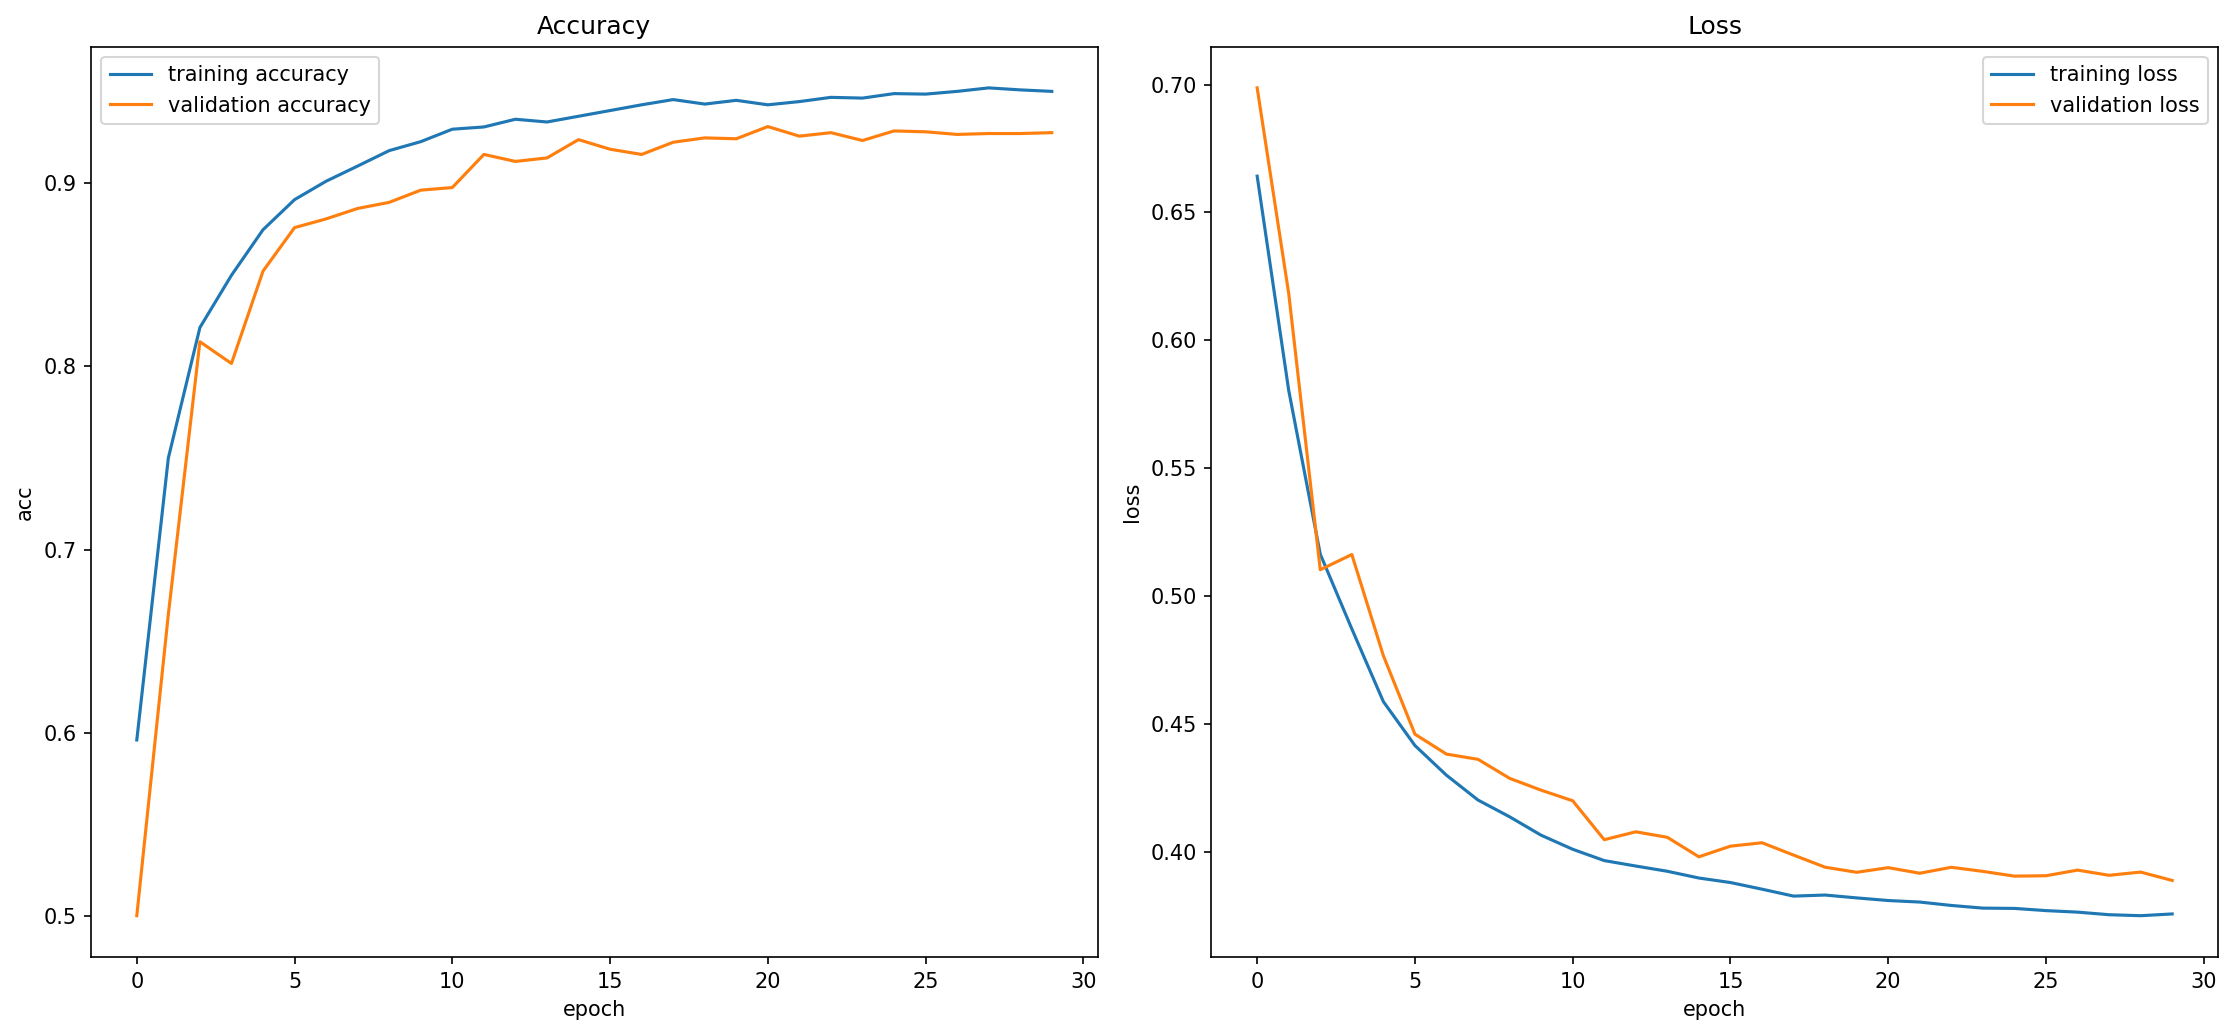

In [34]:
epoches = 30
lr = 1e-4
print(lr)
model_resnet31 = ResNet31(num_leads=3).to(device)
loss = nn.CrossEntropyLoss()
opt = optim.Adam(model_resnet31.parameters(),lr=lr)

datasave = pd.DataFrame(columns=['step','train_acc','train_loss','val_acc','val_loss'])

scheduler = optim.lr_scheduler.StepLR(opt,step_size=6,gamma=0.5)
for epoch in range(epoches):
    scheduler.step()
    ltrn,atrn = train(train_loader,model_resnet31,opt,loss)
    lval,aval = val(val_loader,model_resnet31,opt,loss)
    print('trn_loss: ',ltrn, 'val_loss: ',lval,'trn_acc: ',atrn, 'val_acc: ',aval)
    #datasave.append({'step':epoch,'train_acc':atrn,'train_loss':ltrn,'val_acc':aval,'val_loss':lval},ignore_index=True)
    datasave = pd.concat([datasave, pd.DataFrame({'step':epoch,'train_acc':atrn,'train_loss':ltrn,'val_acc':aval,'val_loss':lval}, index=[0])], ignore_index=True)
    
draw(datasave)

In [35]:
#model save
torch.save(model_resnet31,'/kaggle/working/resnet31.pt')

0.0001
trn_loss:  0.6608562037862581 val_loss:  0.693910721470328 trn_acc:  0.6012778684067428 val_acc:  0.5
trn_loss:  0.5947098547014696 val_loss:  0.5741660700124853 trn_acc:  0.717373572593801 val_acc:  0.7488106565176023
trn_loss:  0.5484198670962761 val_loss:  0.5397994237787583 trn_acc:  0.7748776508972267 val_acc:  0.7773549000951475
trn_loss:  0.5104365266602615 val_loss:  0.5144739676924313 trn_acc:  0.8153887982599238 val_acc:  0.7949571836346336
trn_loss:  0.47651168909566155 val_loss:  0.47321607260143056 trn_acc:  0.8516856987493203 val_acc:  0.8491912464319695
trn_loss:  0.4489174038171768 val_loss:  0.4573353020583882 trn_acc:  0.8809135399673735 val_acc:  0.8644148430066603
trn_loss:  0.4334207084672204 val_loss:  0.4417324504431556 trn_acc:  0.898042414355628 val_acc:  0.8782112274024738
trn_loss:  0.42161590991349057 val_loss:  0.42601155533510093 trn_acc:  0.9090538336052202 val_acc:  0.89581351094196
trn_loss:  0.41185548233574837 val_loss:  0.43228809973772836 trn

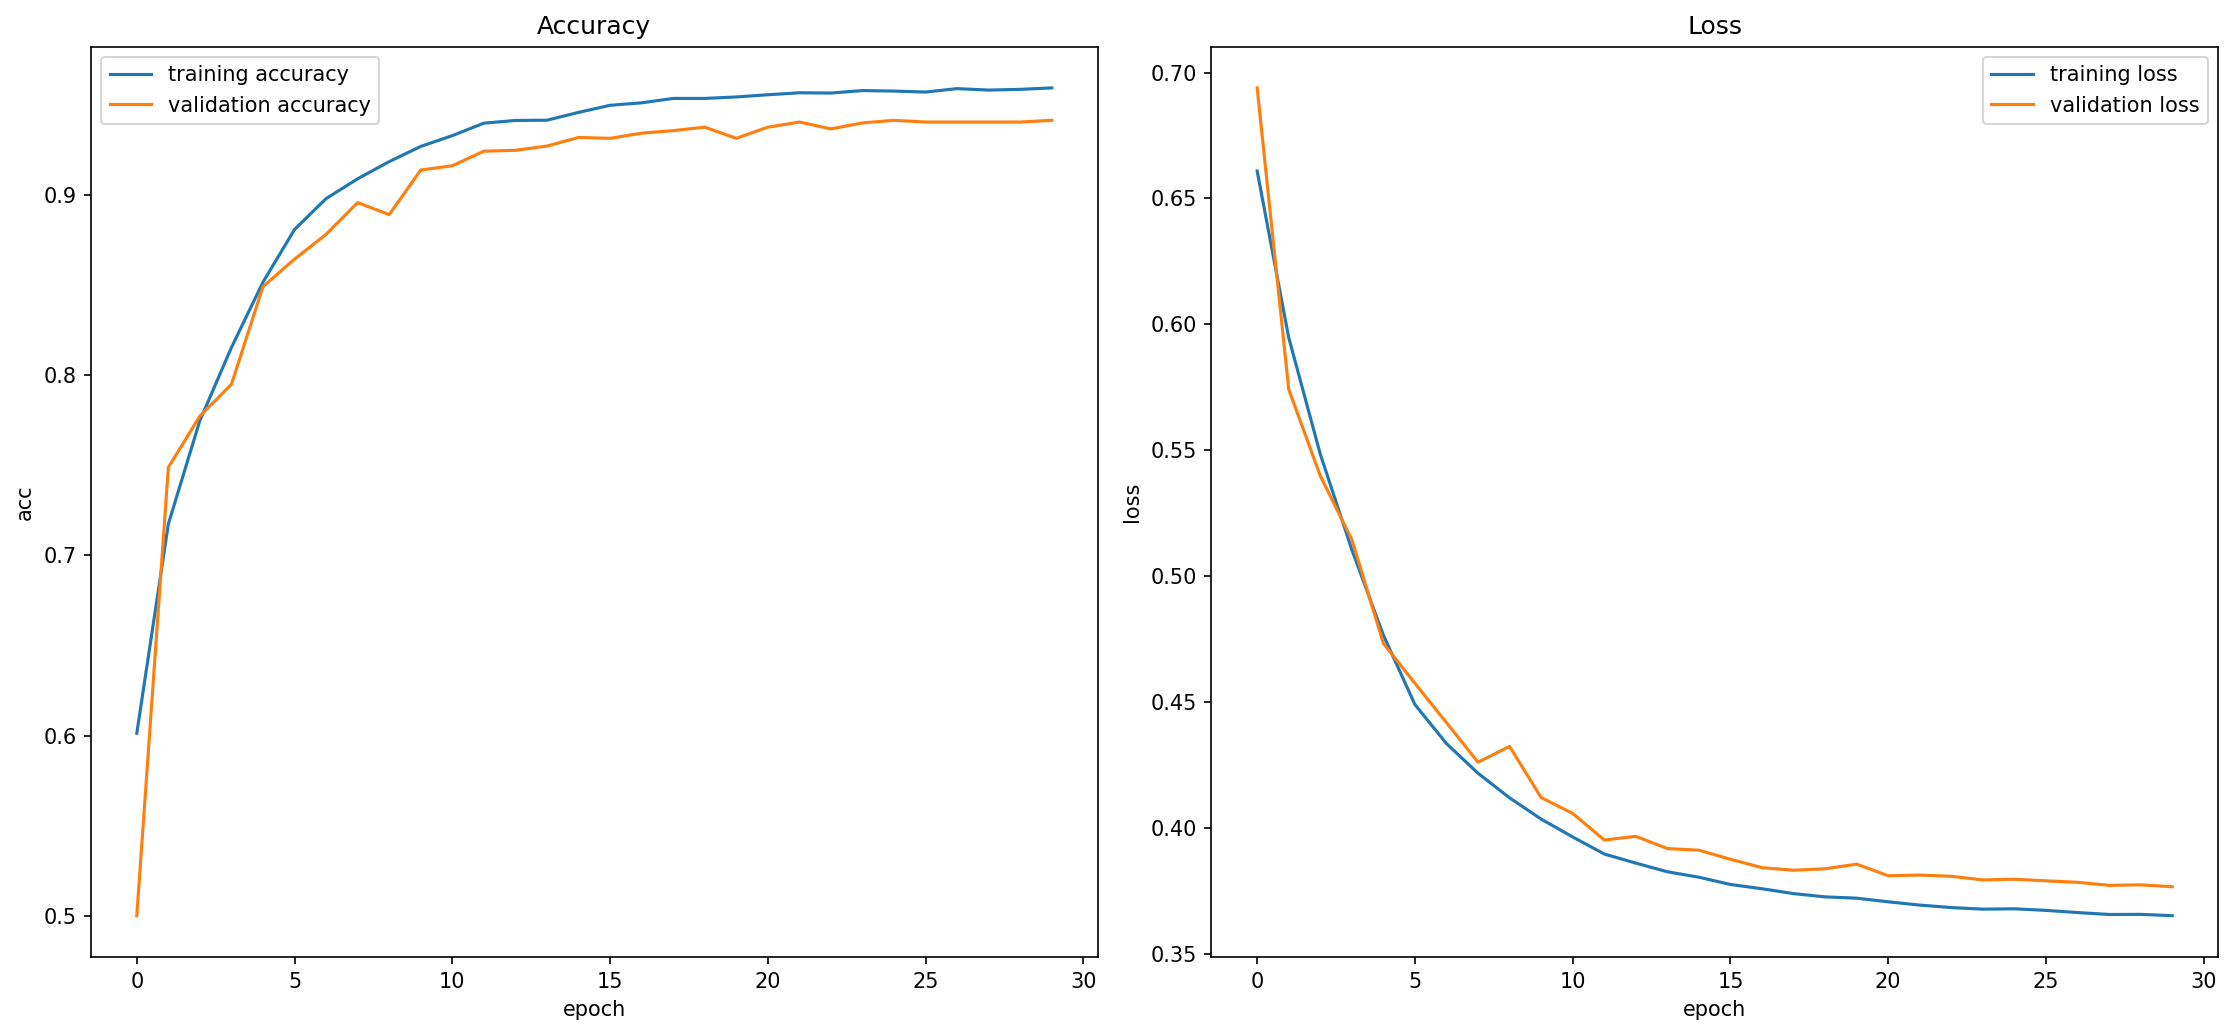

In [35]:
# 12leads model
epoches = 30
lr = 1e-4
print(lr)
model12 = ResNet31(num_leads=12).to(device)
loss12 = nn.CrossEntropyLoss()
opt12 = optim.Adam(model12.parameters(),lr=lr)

datasave_12 = pd.DataFrame(columns=['step','train_acc','train_loss','val_acc','val_loss'])

scheduler12 = optim.lr_scheduler.StepLR(opt12,step_size=6,gamma=0.5)
for epoch in range(epoches):
    scheduler12.step()
    ltrn12,atrn12 = train(train12_loader,model12,opt12,loss12)
    lval12,aval12 = val(val12_loader,model12,opt12,loss12)
    print('trn_loss: ',ltrn12, 'val_loss: ',lval12,'trn_acc: ',atrn12, 'val_acc: ',aval12)
    #datasave.append({'step':epoch,'train_acc':atrn,'train_loss':ltrn,'val_acc':aval,'val_loss':lval},ignore_index=True)
    datasave_12 = pd.concat([datasave_12, pd.DataFrame({'step':epoch,'train_acc':atrn12,'train_loss':ltrn12,'val_acc':aval12,'val_loss':lval12}, index=[0])], ignore_index=True)
    
draw(datasave_12)

In [36]:
#model12 save
torch.save(model12,'/kaggle/working/resnet31_leads12.pt')

# Eval Model

In [31]:
#load model
model_resnet31 = torch.load('/kaggle/input/mscproject-data/resnet31.pt')

In [ ]:
model12 = torch.load('/kaggle/input/mscproject-data/resnet31_leads12.pt')

In [32]:
#test set
test_set = ECGDataset(test_df,three_leads)
test_loader = data.DataLoader(test_set,batch_size=1,shuffle=False)
print(test_set[0][0])
print(test_set[0][1])

/kaggle/input/mscproject-data/mscproject_data/mscproject_dataset/JS05524.mat
tensor([[ 1.6234e-03,  1.5618e-03,  1.5117e-03,  ..., -5.1532e-05,
         -5.8431e-05, -7.4041e-05],
        [-6.3630e-05, -3.7636e-05, -1.2556e-05,  ..., -1.7604e-05,
         -2.1894e-05, -2.9193e-05],
        [-1.9537e-04, -1.7713e-04, -1.5559e-04,  ...,  1.3581e-04,
          1.0419e-04,  6.6813e-05]], dtype=torch.float64)


In [47]:
#test set for 12leads
test12_set = ECGDataset(test_df,twelve_leads)
test12_loader = data.DataLoader(test12_set,batch_size=1,shuffle=False)

In [33]:
#generate preds of testset
test_result = pd.DataFrame(columns=['filenames','labels','preds'])
model_resnet31.eval()
with torch.no_grad():
    for i,data in enumerate(test_loader):
        filenames,ecgs,labels = data
        ecgs = ecgs.float().to(device)
        outputs = model_resnet31(ecgs)
        _,preds = torch.max(outputs.data,1)
        
        #out = [filenames[0],labels[0],preds.cpu().numpy().item()]
        test_result = pd.concat([test_result,pd.DataFrame({'filenames':filenames[0],'labels':labels[0].item(),'preds':preds.cpu().numpy().item()}, index=[0])],ignore_index=True)
test_result

filenames labels preds
0     /kaggle/input/mscproject-data/mscproject_data/...      1     1
1     /kaggle/input/mscproject-data/mscproject_data/...      1     1
2     /kaggle/input/mscproject-data/mscproject_data/...      1     1
3     /kaggle/input/mscproject-data/mscproject_data/...      1     0
4     /kaggle/input/mscproject-data/mscproject_data/...      1     1
...                                                 ...    ...   ...
1047  /kaggle/input/mscproject-data/mscproject_data/...      0     0
1048  /kaggle/input/mscproject-data/mscproject_data/...      0     1
1049  /kaggle/input/mscproject-data/mscproject_data/...      0     0
1050  /kaggle/input/mscproject-data/mscproject_data/...      0     0
1051  /kaggle/input/mscproject-data/mscproject_data/...      0     0

[1052 rows x 3 columns]

### confusion matrix

In [38]:
# cm
class_num = 2
classes = ['AF','Normal']
def confusion_matrix(preds,labels,cm):
    _,preds = torch.max(preds.data,1)
    labelc = [0 if label==1 else 1 for label in labels]
    predc = [0 if pred==1 else 1 for pred in preds]
    for t,p in zip(labelc,predc):
        cm[t,p] +=1
    return cm

def get_cm(dataloader,model):
    cm = torch.zeros(class_num,class_num)
    with torch.no_grad():
        for data in dataloader:
            _,ecg,labels = data
            ecg = ecg.float().to(device)
            labels = labels.to(device)
            preds = model(ecg)
            cm = confusion_matrix(preds,labels,cm)
            cm = cm.cpu()
    cm = np.array(cm.cpu())
    #cm_p = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    return cm

def draw_cm(cm):
    plt.imshow(cm,cmap=plt.cm.Blues)
    thresh = cm.max()/2
    for x in range(class_num):
        for y in range(class_num):
            info = cm[y,x].astype(int)
            plt.text(x,y,'{}'.format(info),verticalalignment='center',horizontalalignment='center',color='white'if info>thresh else 'black')
    plt.tight_layout()
    plt.xticks(range(class_num),classes)
    plt.yticks(range(class_num),classes)

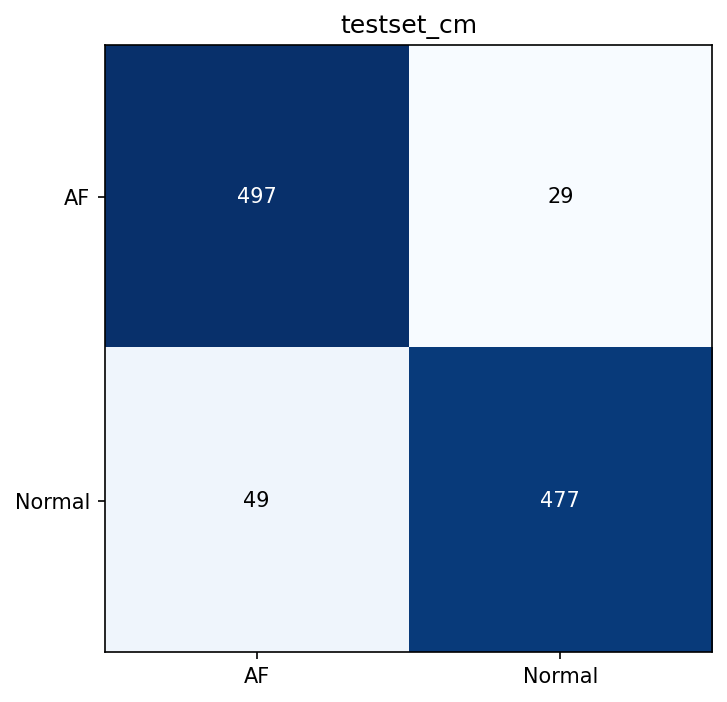

In [34]:
model = model_resnet31
#testset_cm
cm = get_cm(test_loader,model)

plt.figure(figsize=(5,5),dpi=150)
draw_cm(cm)
plt.title('testset_cm')
plt.show()

### ROC

In [40]:
def get_roc(loader,model):
    score = []
    label = []
    with torch.no_grad():
        for data in loader:
            filenames,ecgs,labels = data
            ecgs = ecgs.float().to(device)
            labels = labels.to(device)
            outputs = model(ecgs)
            score.extend(outputs.detach().cpu().numpy())
            label.extend(labels.cpu().numpy())
    score = np.array(score)
    label_tensor = torch.tensor(label)
    label_tensor = label_tensor.reshape((label_tensor.shape[0],1))
    label_onehot = torch.zeros(label_tensor.shape[0],class_num)
    label_onehot.scatter_(dim=1,index=label_tensor,value=1)
    label_onehot = np.array(label_onehot)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(class_num):
        fpr[i],tpr[i],_ = roc_curve(label_onehot[:,i],score[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    
    #draw
    for i in range(class_num):
        plt.plot(fpr[i],tpr[i],label='%s,auc=%f'%(classes[i],roc_auc[i]))
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

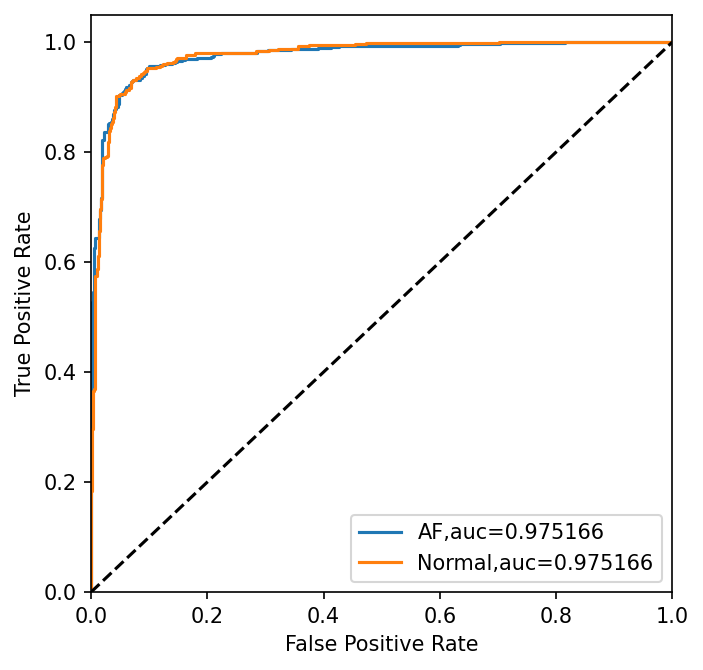

In [35]:
model = model_resnet31
plt.figure(figsize=(5,5),dpi=150)
get_roc(test_loader,model)
plt.show()

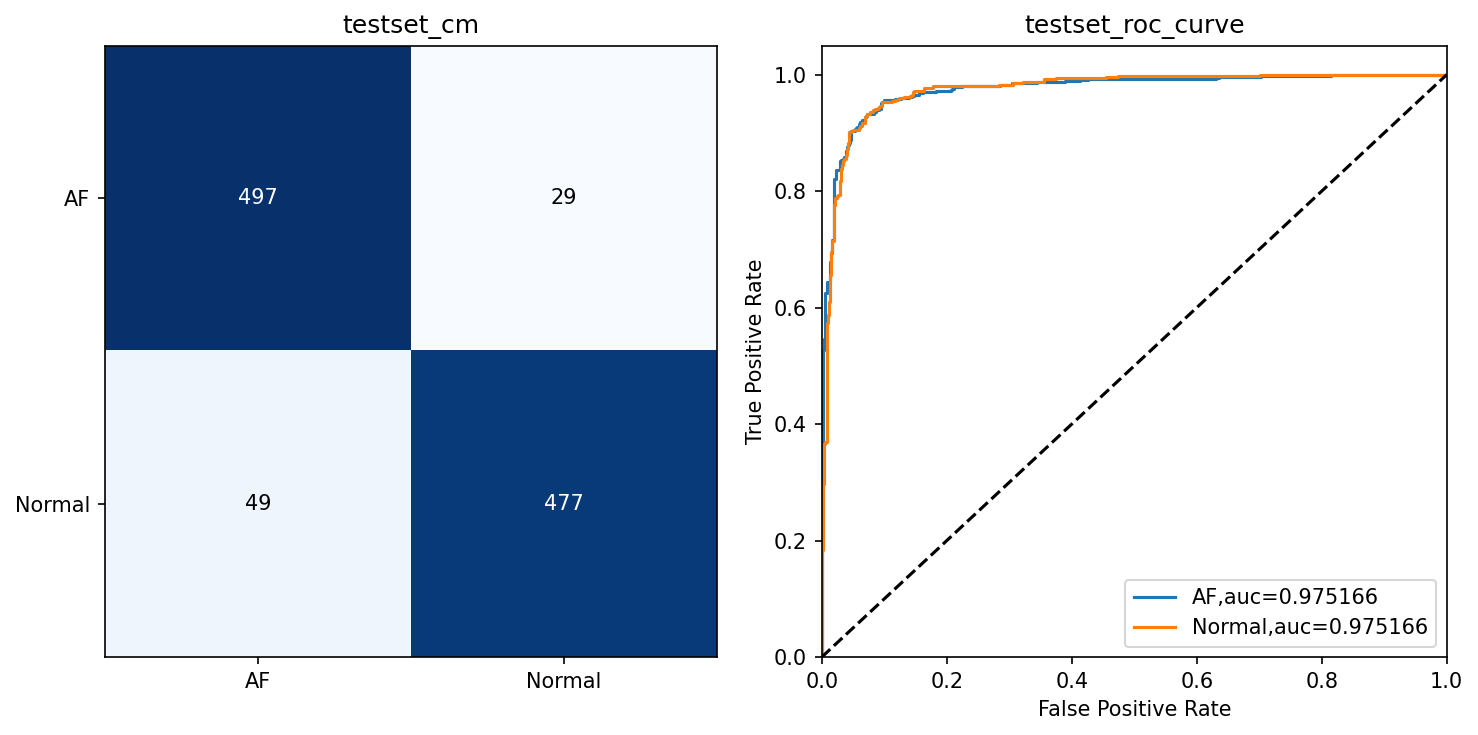

In [39]:
plt.figure(figsize=(10,5),dpi=150)
plt.subplot(1,2,1)
draw_cm(cm)
plt.title('testset_cm')

plt.subplot(1,2,2)
get_roc(test_loader,model)
plt.title('testset_roc_curve')
plt.tight_layout()
plt.show()

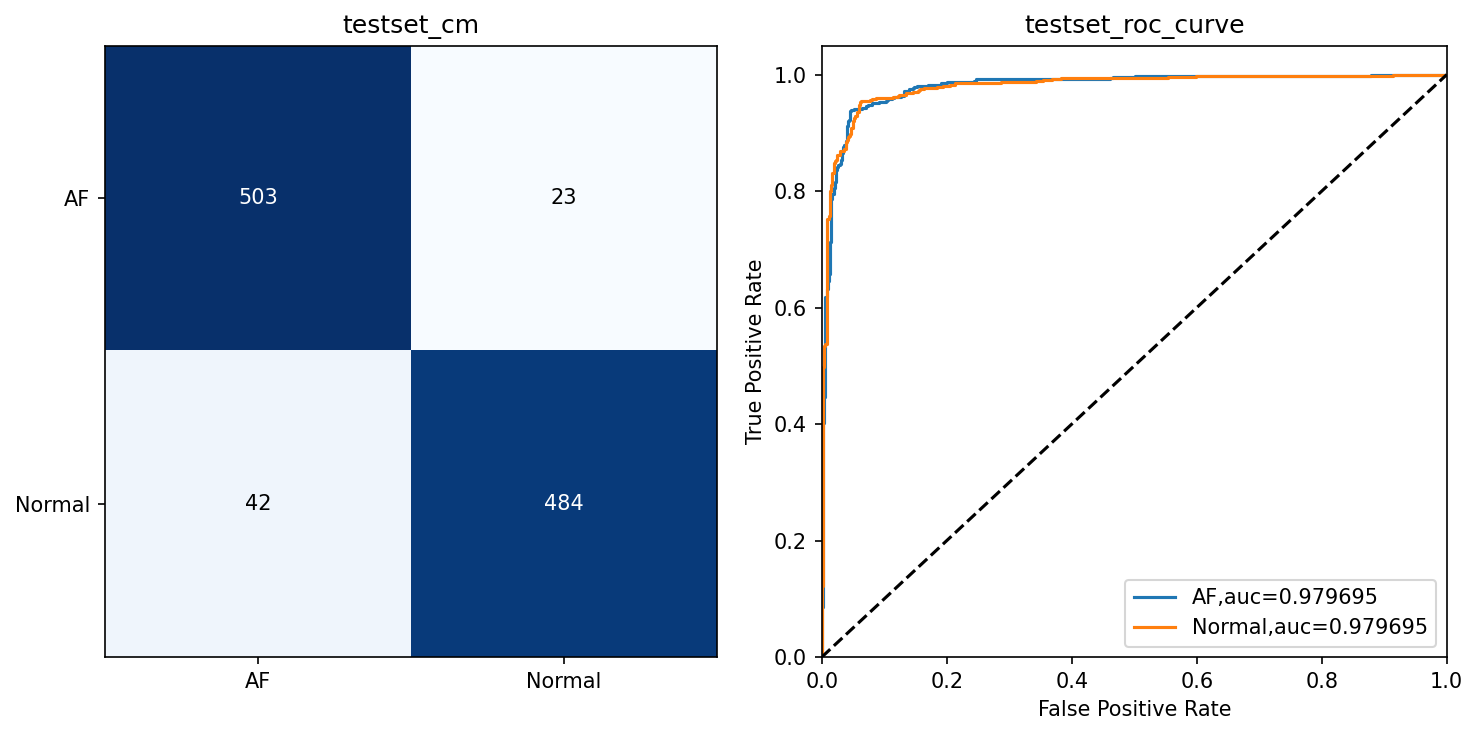

In [41]:
# cm and roc for 12leads
plt.figure(figsize=(10,5),dpi=150)
plt.subplot(1,2,1)
cm12 = get_cm(test12_loader,model12)
draw_cm(cm12)
plt.title('testset_cm')

plt.subplot(1,2,2)
get_roc(test12_loader,model12)
plt.title('testset_roc_curve')
plt.tight_layout()
plt.show()

### other metrics

In [37]:
tp = cm[0,0].astype(float)
fn = cm[0,1].astype(float)
fp = cm[1,0].astype(float)
tn = cm[1,1].astype(float)

#ACC
acc = (tp+tn)/(tp+fn+fp+tn)
print('ACC of test_set: ', acc)

# recall (sensitivity)
recall = tp/(tp+fn)
print('\nRecall of test_set: ', recall)

# precision
precision = tp/(tp+fp)
print('\nPrecision of test_set: ', precision)

# F1
f1 = 2*((precision*recall)/(precision+recall))
print('\nF1-score of test_set: ', f1)

ACC of test_set:  0.9258555133079848

Recall of test_set:  0.9448669201520913

Precision of test_set:  0.9102564102564102

F1-score of test_set:  0.9272388059701493


In [43]:
tp12 = cm12[0,0].astype(float)
fn12 = cm12[0,1].astype(float)
fp12 = cm12[1,0].astype(float)
tn12 = cm12[1,1].astype(float)

#ACC
acc12 = (tp12+tn12)/(tp12+fn12+fp12+tn12)
print('ACC of test12_set: ', acc12)

# recall (sensitivity)
recall12 = tp12/(tp12+fn12)
print('\nRecall of test12_set: ', recall12)

# precision
precision12 = tp12/(tp12+fp12)
print('\nPrecision of test12_set: ', precision12)

# F1
f112 = 2*((precision12*recall12)/(precision12+recall12))
print('\nF1-score of test12_set: ', f112)

ACC of test12_set:  0.938212927756654

Recall of test12_set:  0.9562737642585551

Precision of test12_set:  0.9229357798165138

F1-score of test12_set:  0.9393090569561158


# Explain

In [34]:
#select 4 datafile: Normal (correct,wrong) AF(correct,wrong)
normal_c = test_result.loc[(test_result['labels'] == 0) & (test_result['preds'] == 0), 'filenames'].sample(n=1).values[0]
normal_w = test_result.loc[(test_result['labels'] == 0) & (test_result['preds'] == 1), 'filenames'].sample(n=1).values[0]
af_c = test_result.loc[(test_result['labels'] == 1) & (test_result['preds'] == 1), 'filenames'].sample(n=1).values[0]
af_w = test_result.loc[(test_result['labels'] == 1) & (test_result['preds'] == 0), 'filenames'].sample(n=1).values[0]

to_explain = [normal_c,normal_w,af_w,af_c]
print(normal_c)

/kaggle/input/mscproject-data/mscproject_data/mscproject_dataset/HR05030.mat


In [35]:
# prepare explain ecg data
def prepare_input(path,num_leads):
    data,header = load_data(path)
    init_ecg_data = choose_leads(data,header,num_leads)
        
    #data preprocess
    psc_ecg_data = resample(header,init_ecg_data)
    psc_ecg_data = filt(psc_ecg_data)
    psc_ecg_data = norm(psc_ecg_data)
    adc_gains = get_adc_gains(header,three_leads)
    baselines = get_baselines(header,three_leads)
    for i in range(len(three_leads)):
        psc_ecg_data[i,:] = (psc_ecg_data[i,:]-baselines[i])/adc_gains[i]
        
    # <max_len --> pad 0 /// >max_len ---> select 0:max_len
    if psc_ecg_data.shape[1]>=5000:
        ecg_data = torch.tensor(psc_ecg_data[:,0:5000])
    elif psc_ecg_data.shape[1]<5000:
        pad = 5000-psc_ecg_data.shape[1]
        ecg_data = np.hstack((psc_ecg_data, np.zeros((psc_ecg_data.shape[0], pad))))
        ecg_data = torch.tensor(ecg_data)
    return ecg_data

#### Grad-CAM 1d

In [79]:
def target_category_loss(x,category_index,nb_classes):
    return torch.mul(x,F.one_hot(category_index,nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    return x/(torch.sqrt(torch.mean(torch.square(x)))+1e-5)

def resize_1d(array,shape):
    res = np.zeros(shape)
    if array.shape[0] >=shape:
        ratio = array.shape[0]/shape
        for i in range(array.shape[0]):
            res[int(i/ratio)] += array[i]*(1-(i/ratio-int(i/ratio)))
            if int(i/ratio) !=shape-1:
                res[int(i/ratio)+1] += array[i]*(i/ratio-int(i/ratio))
            else:
                res[int(i/ratio)] += array[i]*(i/ratio-int(i/ratio))
        res = res[::-1]
        array = array[::-1]
        for i in range(array.shape[0]):
            res[int(i/ratio)] += array[i]*(1-(i/ratio-int(i/ratio)))
            if int(i/ratio) !=shape-1:
                res[int(i/ratio)+1] += array[i]*(i/ratio-int(i/ratio))
            else:
                res[int(i/ratio)] += array[i]*(i/ratio-int(i/ratio))
        res = res[::-1]/(2*ratio)
        array = array[::-1]
    else:
        ratio = shape/array.shape[0]
        left = 0
        right = 1
        for i in range(shape):
            if left < int(i/ratio):
                left +=1
                right +=1
            if right > array.shape[0]-1:
                res[i] +=array[left]
            else:
                res[i] += array[right] * \
                    (i - left * ratio)/ratio+array[left]*(right*ratio-i)/ratio
        res = res[::-1]
        array = array[::-1]
        left = 0
        right = 1
        for i in range(shape):
            if left < int(i/ratio):
                left +=1
                right +=1
            if right > array.shape[0]-1:
                res[i] +=array[left]
            else:
                res[i] += array[right] * \
                    (i - left * ratio)/ratio+array[left]*(right*ratio-i)/ratio
        res = res[::-1]/2
        array = array[::-1]
    return res


In [80]:
class ActivationAndGradients:
    def __init__(self,model,target_layer):
        self.model = model
        self.gradients = []
        self.activations = []
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
        
    def save_activation(self,module,input,output):
        self.activations.append(output)
    def save_gradient(self,module,grad_input,grad_output):
        self.gradients = [grad_output[0]]+self.gradients
    def __call__(self,x):
        self.gradients = []
        self.activations = []
        return self.model(x)
    
class BaseCAM:
    def __init__(self,model,target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        
        self.activations_and_grads = ActivationAndGradients(self.model,target_layer)
        
    def forward(self,input_img):
        return self.model(input_img)
    
    def get_cam_weights(self,input_tensor,target_category,activations,grads):
        raise Exception('Not Implemented')
    def get_loss(self,output,target_category):
        return output[:,target_category]
    def __call__(self,input_tensor,target_category=None):
        input_tensor = input_tensor
        output = self.activations_and_grads(input_tensor)
        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())
        self.model.zero_grad()
        loss = self.get_loss(output,target_category)
        loss.backward(retain_graph=True)
        
        activations = self.activations_and_grads.activations[-1].cpu().data.numpy()[0,:]
        grads = self.activations_and_grads.gradients[-1].cpu().data.numpy()[0,:]
        weights = self.get_cam_weights(input_tensor,target_category,activations,grads)
        cam = np.zeros(activations.shape[1:],dtype=np.float32)
        for i,w in enumerate(weights):
            cam += w*activations[i,:]
        cam = resize_1d(cam,(input_tensor.shape[2]))
        cam = np.maximum(cam,0)
        heatmap = (cam-np.min(cam))/(np.max(cam)-np.min(cam)+1e-10)
        return heatmap
    
class GradCAM(BaseCAM):
    def __init__(self,model,target_layer):
        super(GradCAM,self).__init__(model,target_layer)
    def get_cam_weights(self,input_tensor,target_category,activations,grads):
        return np.mean(grads,axis=1)

In [69]:
# show Normal(true and false) AF(true and false)
# heatmap a line, three leads in a plot next line
classes = ['Normal','AF']
def draw_heatmap(ecg):
    heatmap = net(ecg)
    heatmape = np.expand_dims(heatmap,0)
    #print(heatmap.min(), heatmap.max())
    #print(heatmap)
    im = axs.imshow(heatmape,cmap='Reds',aspect='auto',interpolation='nearest',vmin=heatmape.min(),vmax=heatmape.max(),alpha=1.0,
                 extent=[0,5000,ecg.cpu().numpy()[0][2].min()-0.015,ecg.cpu().numpy()[0][0].max()+0.015])
    axs.plot(x,ecg.cpu().numpy()[0][0]+0.01,label='aVF')
    axs.plot(x,ecg.cpu().numpy()[0][1],label='V5')
    axs.plot(x,ecg.cpu().numpy()[0][2]-0.01,label='V6')
    axs.set_xlim((0,5000))
    axs.legend()
    fig.colorbar(im,ax=axs,fraction=0.01)
    return heatmap
    #plt.show()

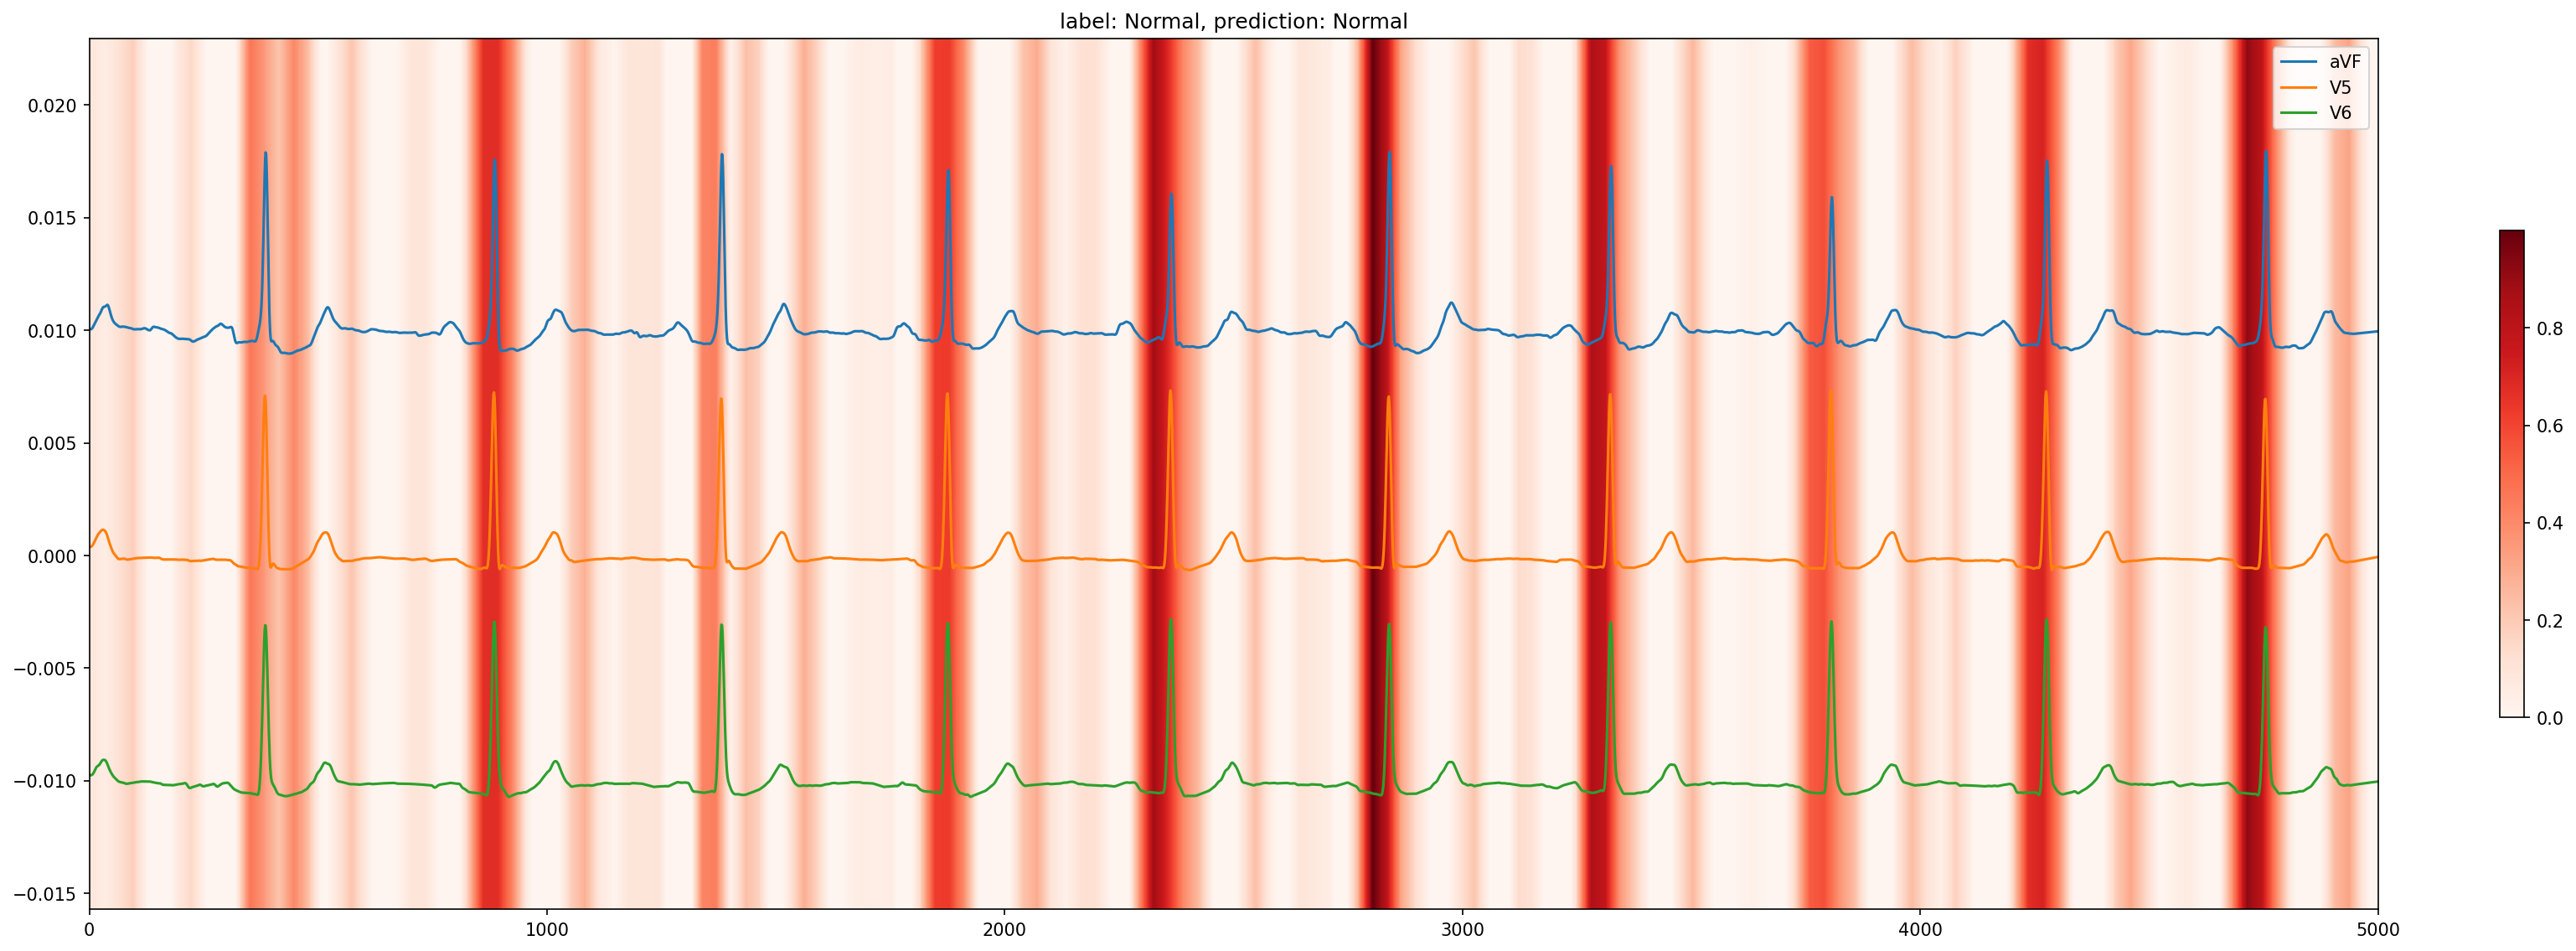

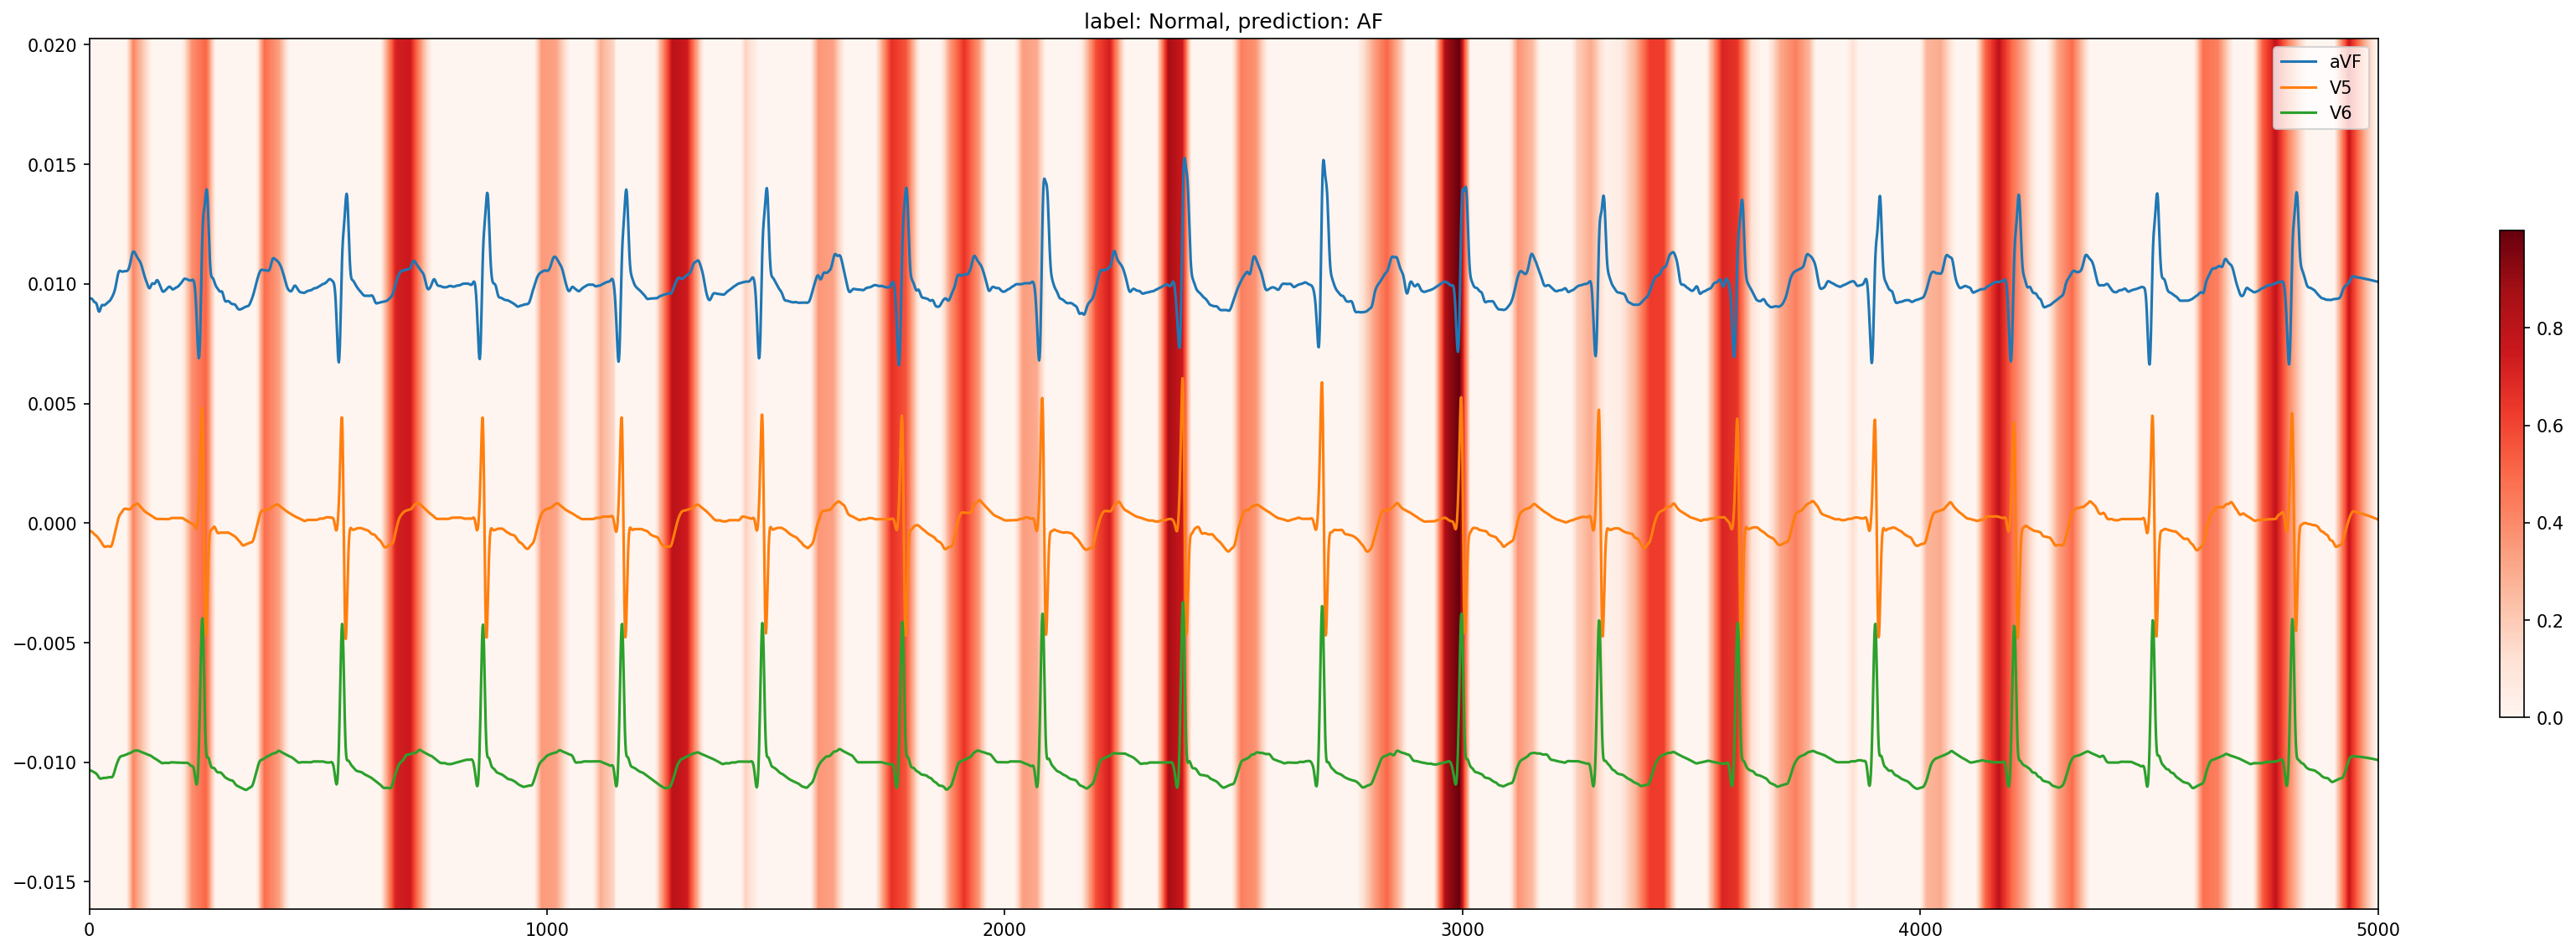

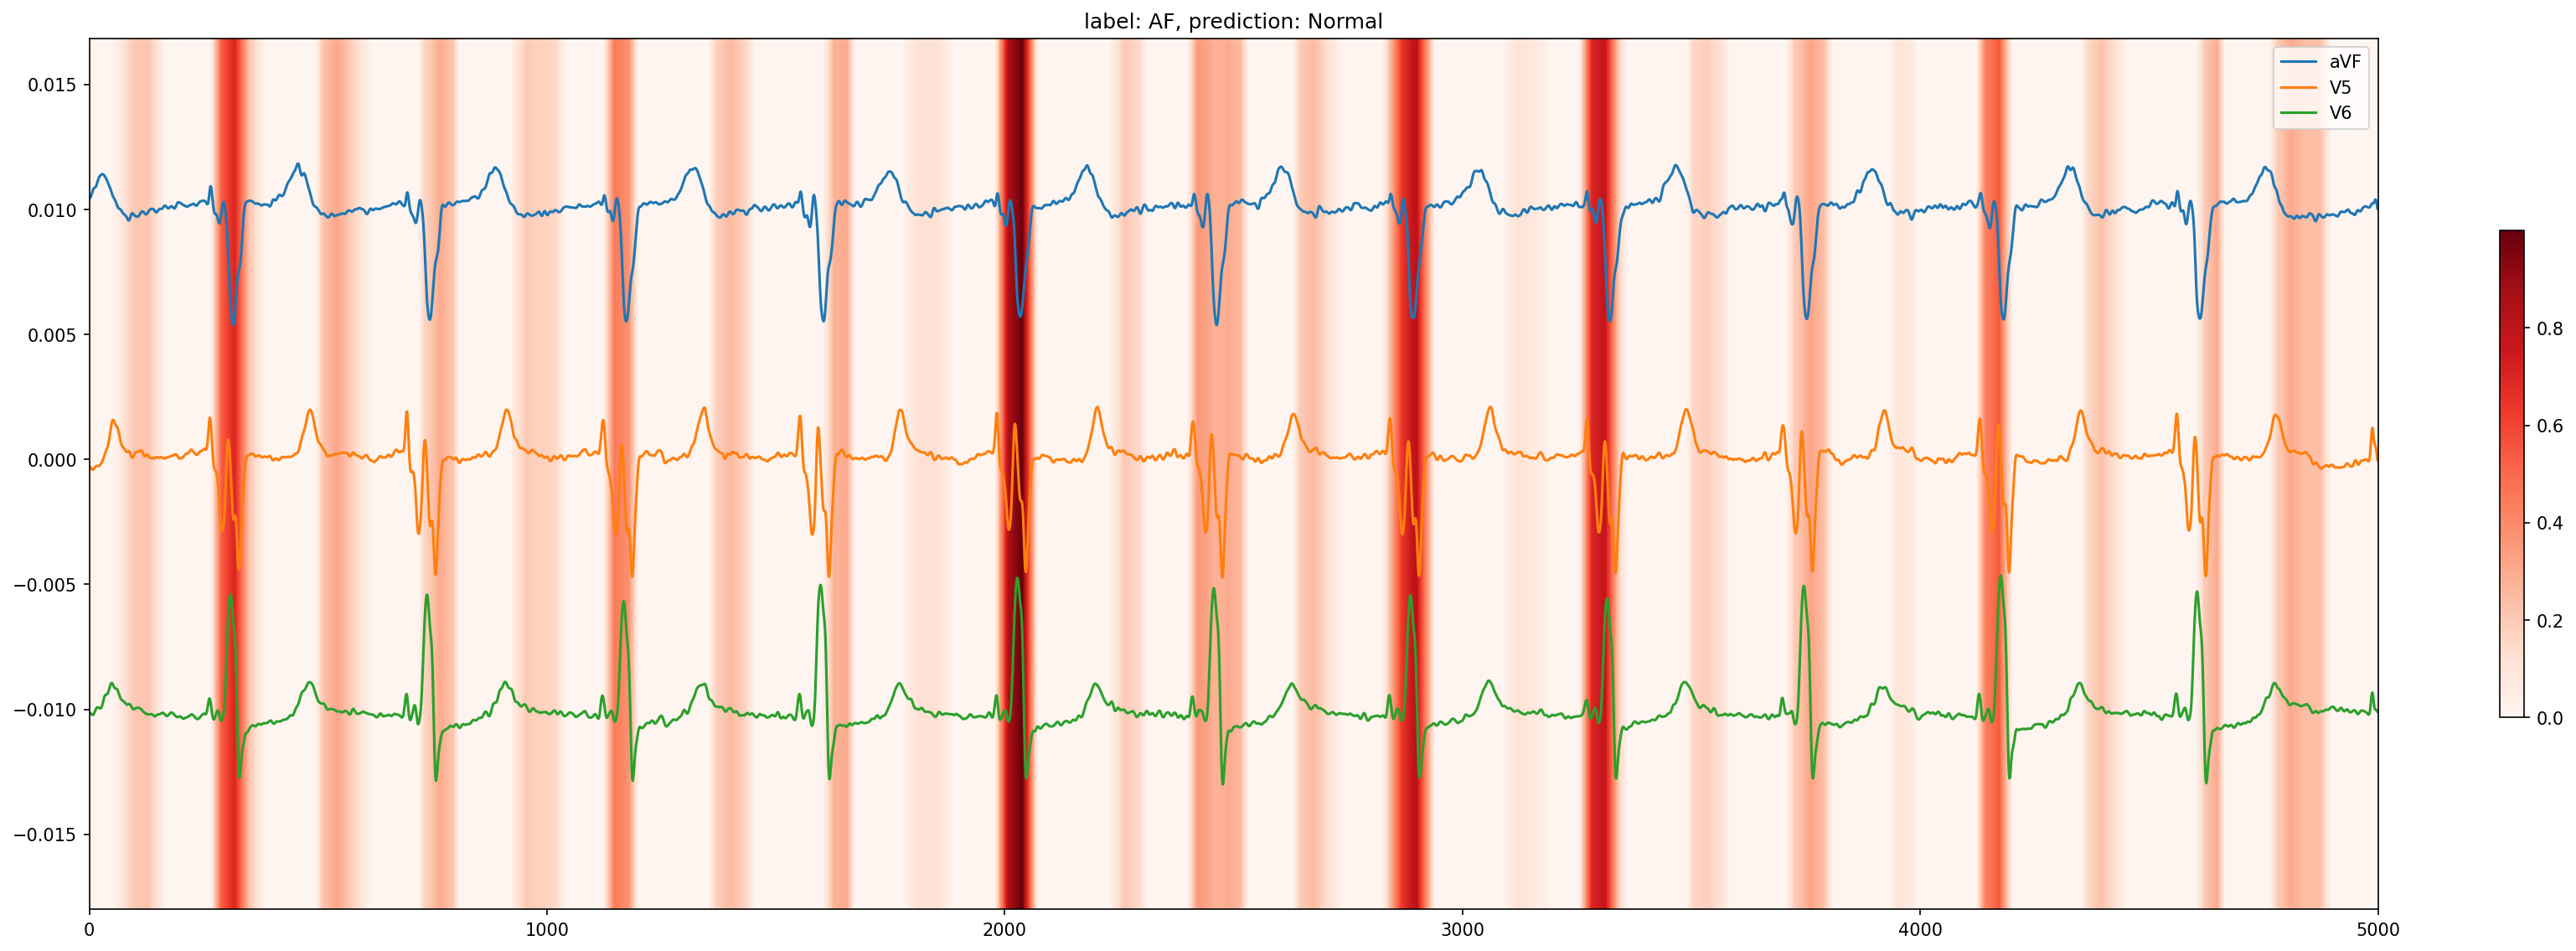

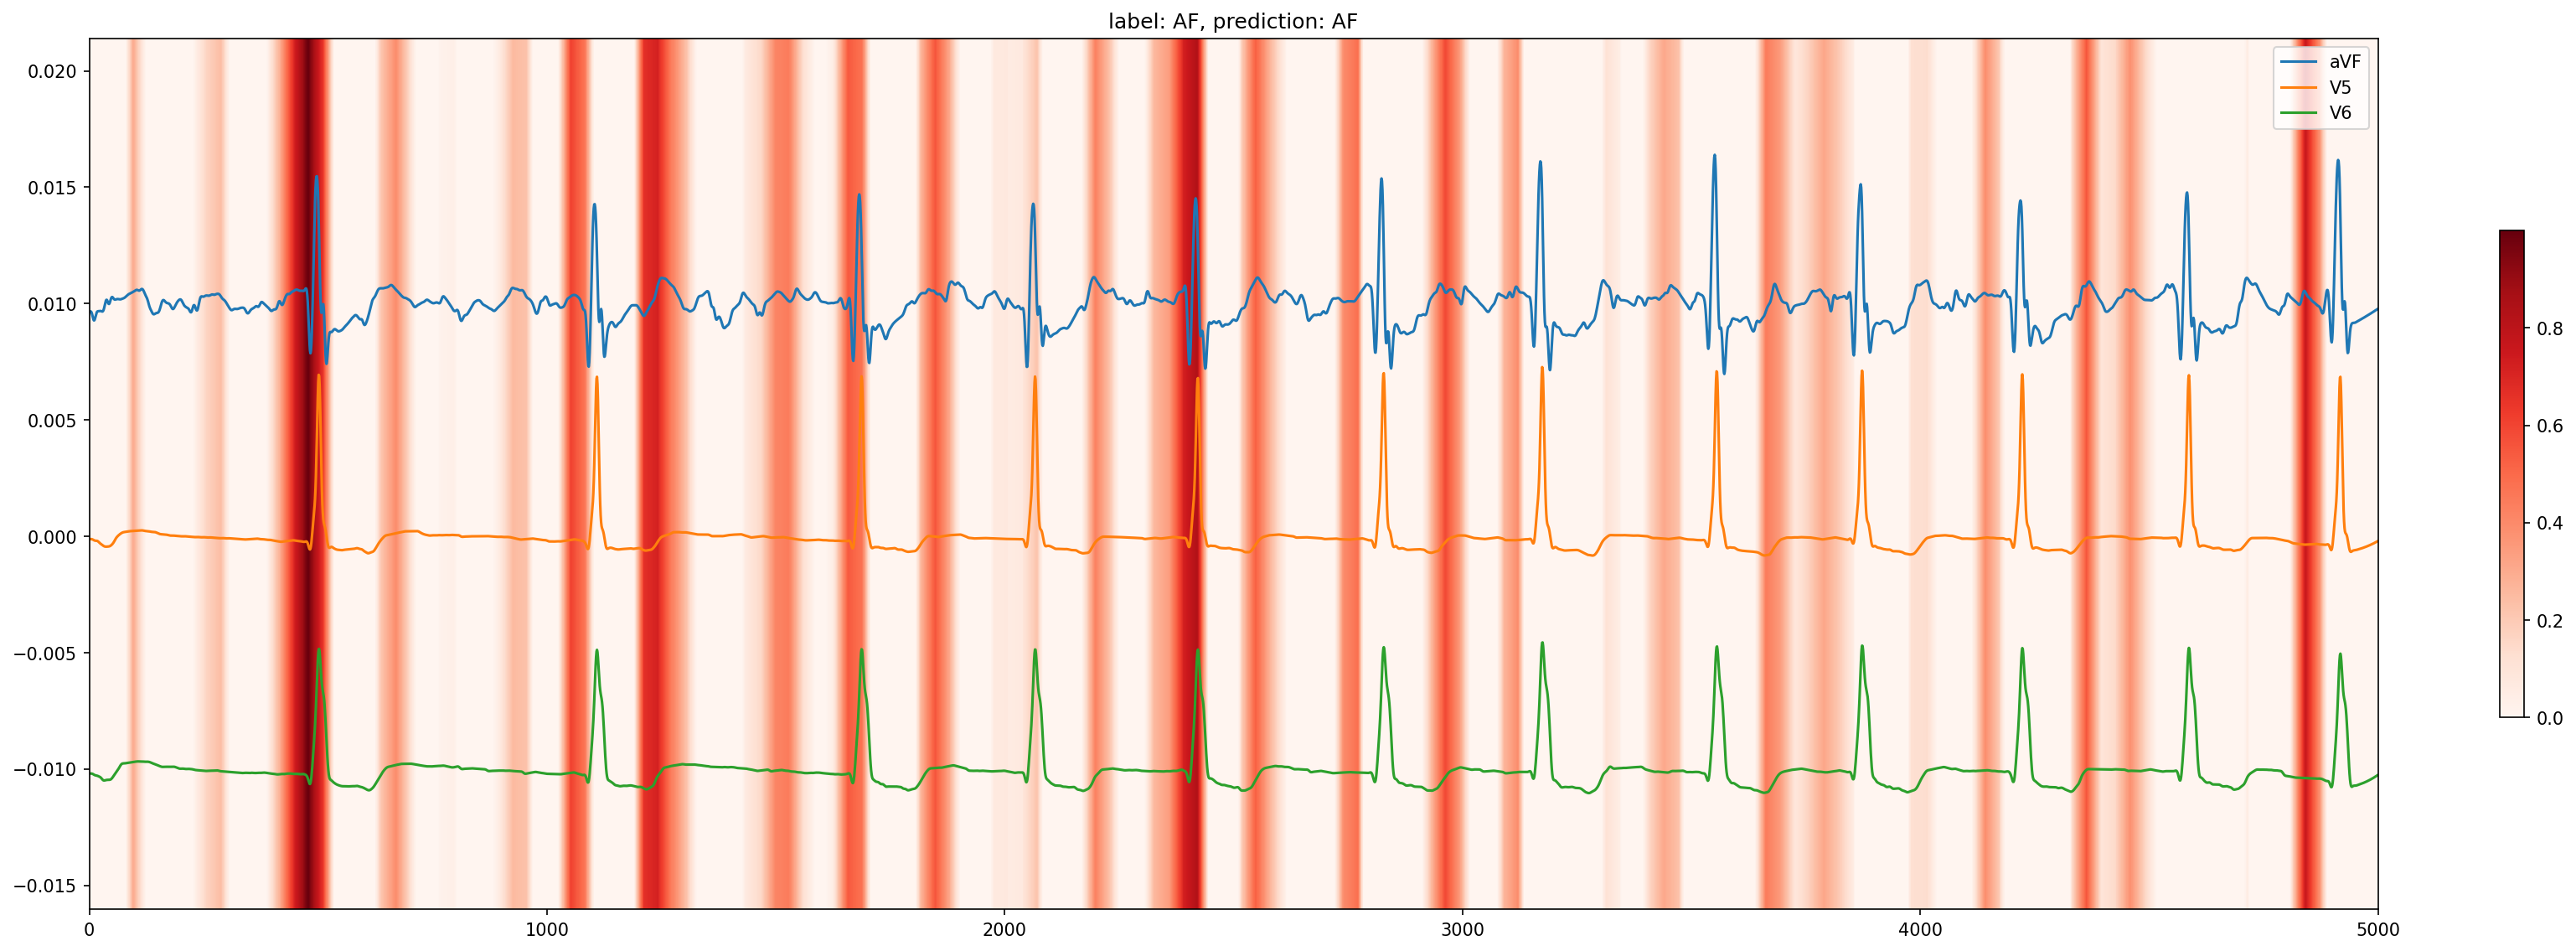

In [38]:
model = model_resnet31
target_layer = model.res_block3.conv3
net = GradCAM(model,target_layer)

x = np.arange(5000)
hotmap = np.zeros((4,5000))
for i,file in enumerate(to_explain):
    fig,axs = plt.subplots(1,1,figsize=(25,9),dpi=150)
    ecg = torch.unsqueeze(prepare_input(file,three_leads).float().to(device),dim=0)
    axs.set_title('label: %s, prediction: %s' %(classes[i//2],classes[i%2]))
    heatmap = draw_heatmap(ecg)
    hotmap[i] = [1 if x>=0.6 else 0 for x in heatmap]
    plt.savefig('grad_cam_%d.png'%(i+1))
    plt.show()

In [54]:
def perturb_random(ecg,hotmap):
    out = np.copy(ecg)
    if len(hotmap.shape)==1:
        for i in range(ecg.shape[0]):
            noise = np.random.uniform(ecg[i].min(),ecg[i].max(),ecg[i].shape)
            out[i][hotmap==1] = noise[hotmap==1]
    elif len(hotmap.shape)==len(ecg.shape):
        for i in range(ecg.shape[0]):
            noise = np.random.uniform(ecg[i].min(),ecg[i].max(),ecg[i].shape)
            out[i][hotmap[i]==1] = npise[hotmap[i]==1] 
    return out

def perturb_mean(ecg,hotmap):
    out = np.copy(ecg)
    if len(hotmap.shape)==1:
        for i in range(ecg.shape[0]):
            mean = np.sum(ecg[i]*hotmap)/np.sum(hotmap)
            out[i][hotmap==1] = mean
    elif len(hotmap.shape) == len(ecg.shape):
        mean = np.sum(ecg*hotmap,axis=1)/np.sum(hotmap,axis=1)
        for i in range(ecg.shape[0]):
            out[i][hoymap[i]==1] = mean[i]
    return out

def perturb_inverse(ecg,hotmap):
    out = np.copy(ecg)
    if len(hotmap.shape)==1:
        for i in range(ecg.shape[0]):
            start_idx=0
            while start_idx<ecg.shape[1]:
                if hotmap[start_idx]==1:
                    end_idx = start_idx+1
                    while end_idx<ecg.shape[1] and hotmap[end_idx]==1:
                        end_idx+=1
                    out[i,start_idx:end_idx] = np.flip(out[i,start_idx:end_idx])
                    start_idx=end_idx
                else:
                    start_idx +=1
                
    elif len(hotmap.shape)==len(ecg.shape):
        for i in range(ecg.shape[0]):
            start_idx=0
            while start_idx<ecg.shape[1]:
                if hotmap[i,start_idx]==1:
                    end_idx = start_idx+1
                    while end_idx<ecg.shape[1] and hotmap[i,end_idx]==1:
                        end_idx +=1
                    out[i,start_idx:end_idx] = np.flip(out[i,start_idx:end_idx])
                    start_idx = end_idx
                else:
                    start_idx +=1
    return out

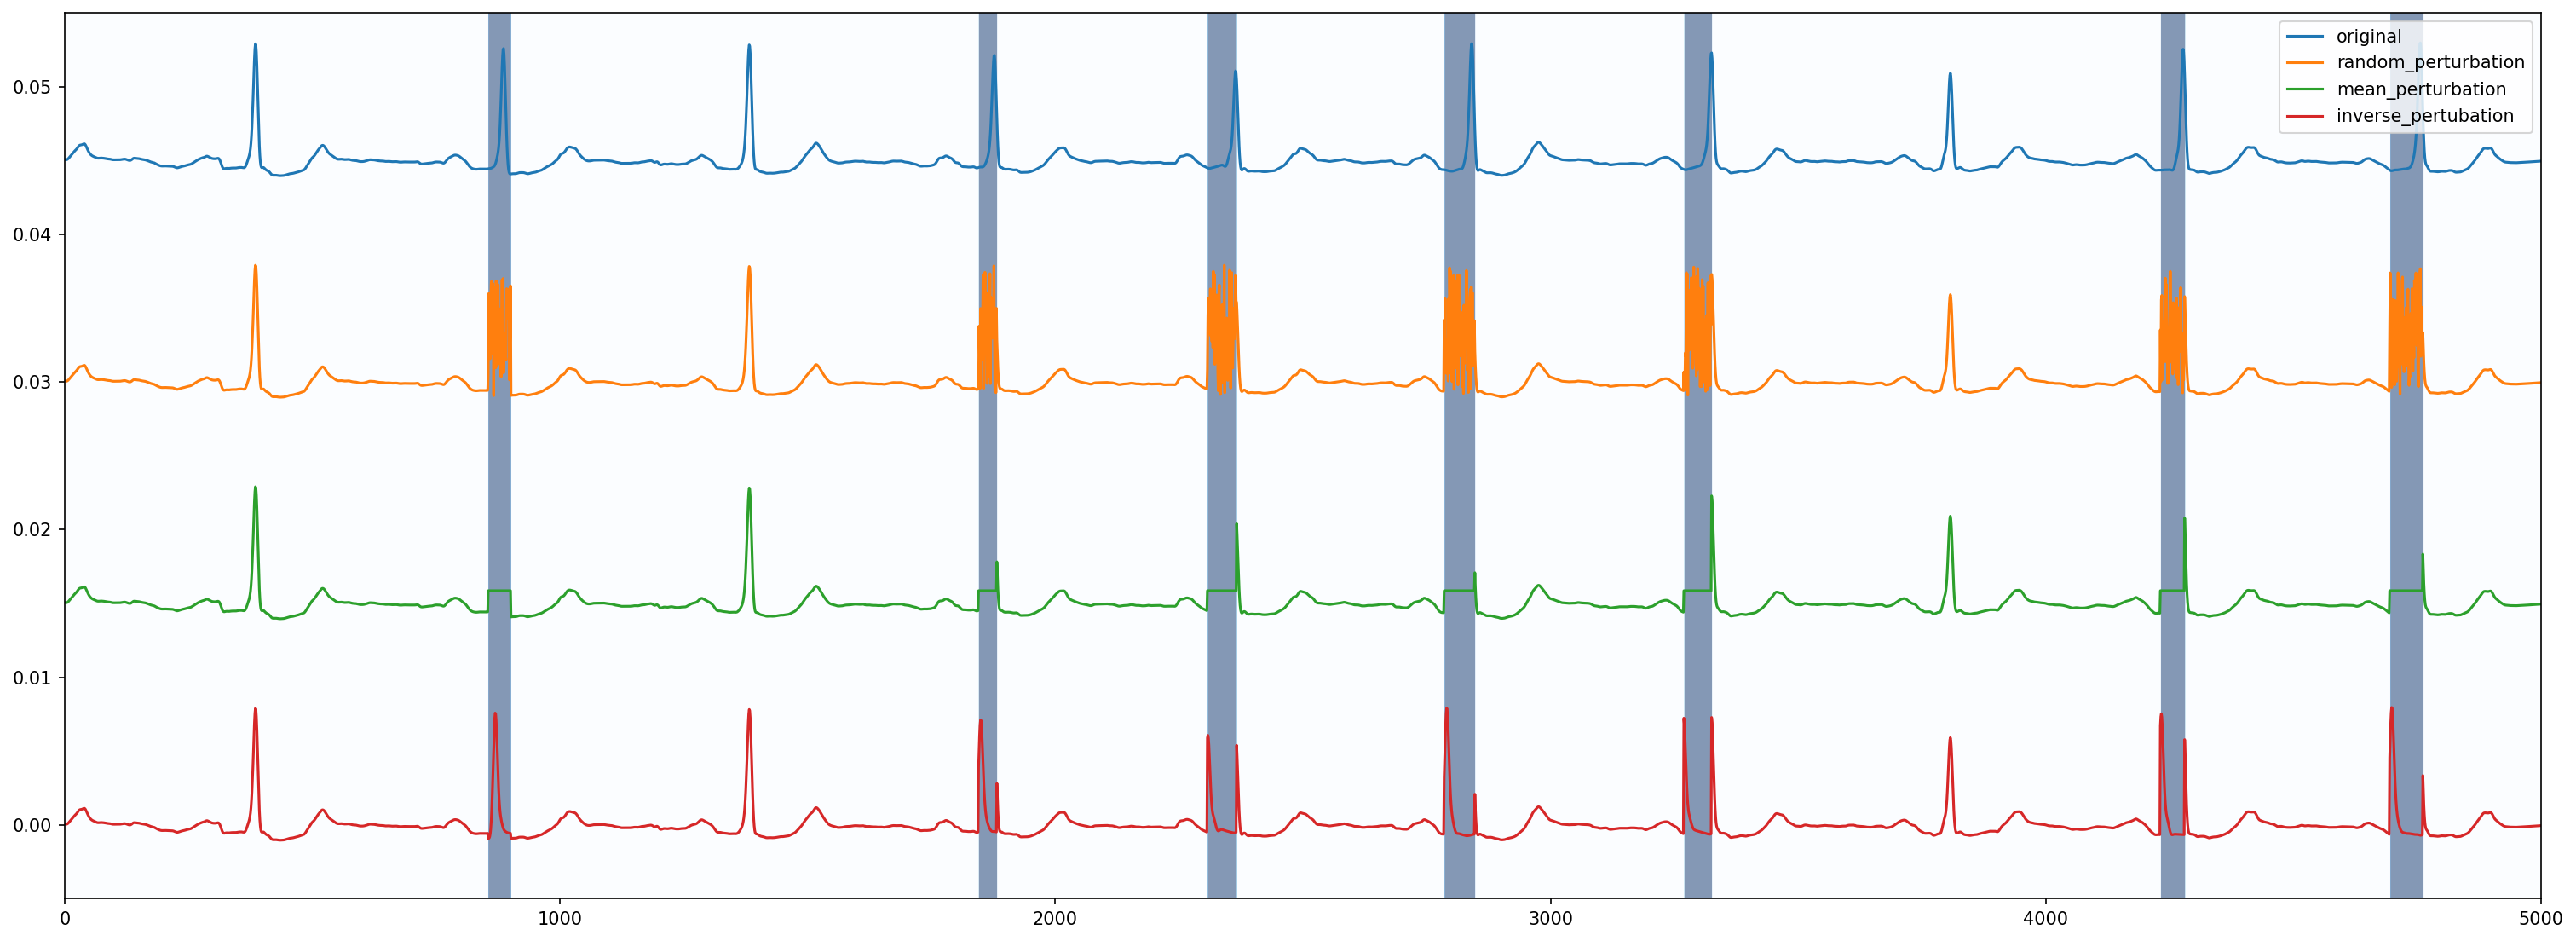

In [61]:
ecg_tmp = prepare_input(to_explain[0],three_leads).cpu().numpy()
random_data = perturb_random(ecg_tmp,hotmap[0])
mean_data = perturb_mean(ecg_tmp,hotmap[0])
inver_data = perturb_inverse(ecg_tmp,hotmap[0])

x = np.arange(5000)
plt.figure(figsize=(25,9),dpi=150)
plt.plot(x,ecg_tmp[0]+0.045,label='original')
plt.plot(x,random_data[0]+0.03,label='random_perturbation')
plt.plot(x,mean_data[0]+0.015,label='mean_perturbation')
plt.plot(x,inver_data[0],label='inverse_pertubation')
plt.imshow(np.expand_dims(hotmap[0],0),aspect='auto',cmap='Blues',extent=[0,5000,-0.005,0.055],alpha=0.5)
plt.legend(loc='upper right')
plt.xlim((0,5000))
plt.savefig('pert.png')
plt.show()

#### SHAP

In [77]:
def plot_shap(ecg_data,sv_data,leads,pred_idx):
    ecg_data = ecg_data.cpu().numpy()
    nleads = len(leads)
    nsteps = 5000
    x = range(nsteps)
    ecg_data = ecg_data[:,0:nsteps]
    sv_data = sv_data[:,0:nsteps]
    shap_map = np.maximum(sv_data,0)
    shap_min = np.min(shap_map,axis=1,keepdims=True)
    shap_max = np.max(shap_map,axis=1,keepdims=True)
    heatmap = (shap_map-shap_min)/(shap_max-shap_min+1e-10)
    slice_len = 50
    slice_num = nsteps//slice_len
    for i in range(heatmap.shape[0]):
        for j in range(slice_num):
            start = j*slice_len
            end = (j+1)*slice_len
            slice_mean = np.mean(heatmap[i][start:end])
            heatmap[i][start:end] = slice_mean
    
    for i,lead in enumerate(leads):
        ax = axs[i]
        
        ax.plot(x,ecg_data[i])
        show_map = np.expand_dims(heatmap[i],0)
        im = ax.imshow(show_map,cmap='Reds',aspect='auto',interpolation='nearest',vmin=show_map.min(),vmax=show_map.max(),alpha=1.0,
                      extent=[0,5000,ecg_data[i].min()-0.001,ecg_data[i].max()+0.001])
        
        ax.set_xlim((0,5000))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(leads[i])
    
    fig.colorbar(im,ax=axs[:],fraction=0.01)  

In [38]:
background = 200
background_files = test_df.head(background)['filenames']
background_inputs = torch.stack([prepare_input(file,three_leads) for file in background_files]).float().to(device)
e = shap.GradientExplainer(model_resnet31,background_inputs)

In [39]:
svs = []
y_scores = []
for i,file in enumerate(to_explain):
    ecg = torch.unsqueeze(prepare_input(file,three_leads),dim=0).float().to(device)
    
    y_scores.append(torch.sigmoid(model_resnet31(ecg)).detach().cpu().numpy())
    sv = np.array(e.shap_values(ecg))
    #print(sv.shape) ---> (2, 1, 3, 5000)
    svs.append(sv)
svs = np.concatenate(svs,axis=1)
y_scores = np.concatenate(y_scores,axis=0)
print(svs.shape)
print(y_scores.shape)

(2, 4, 3, 5000)
(4, 2)


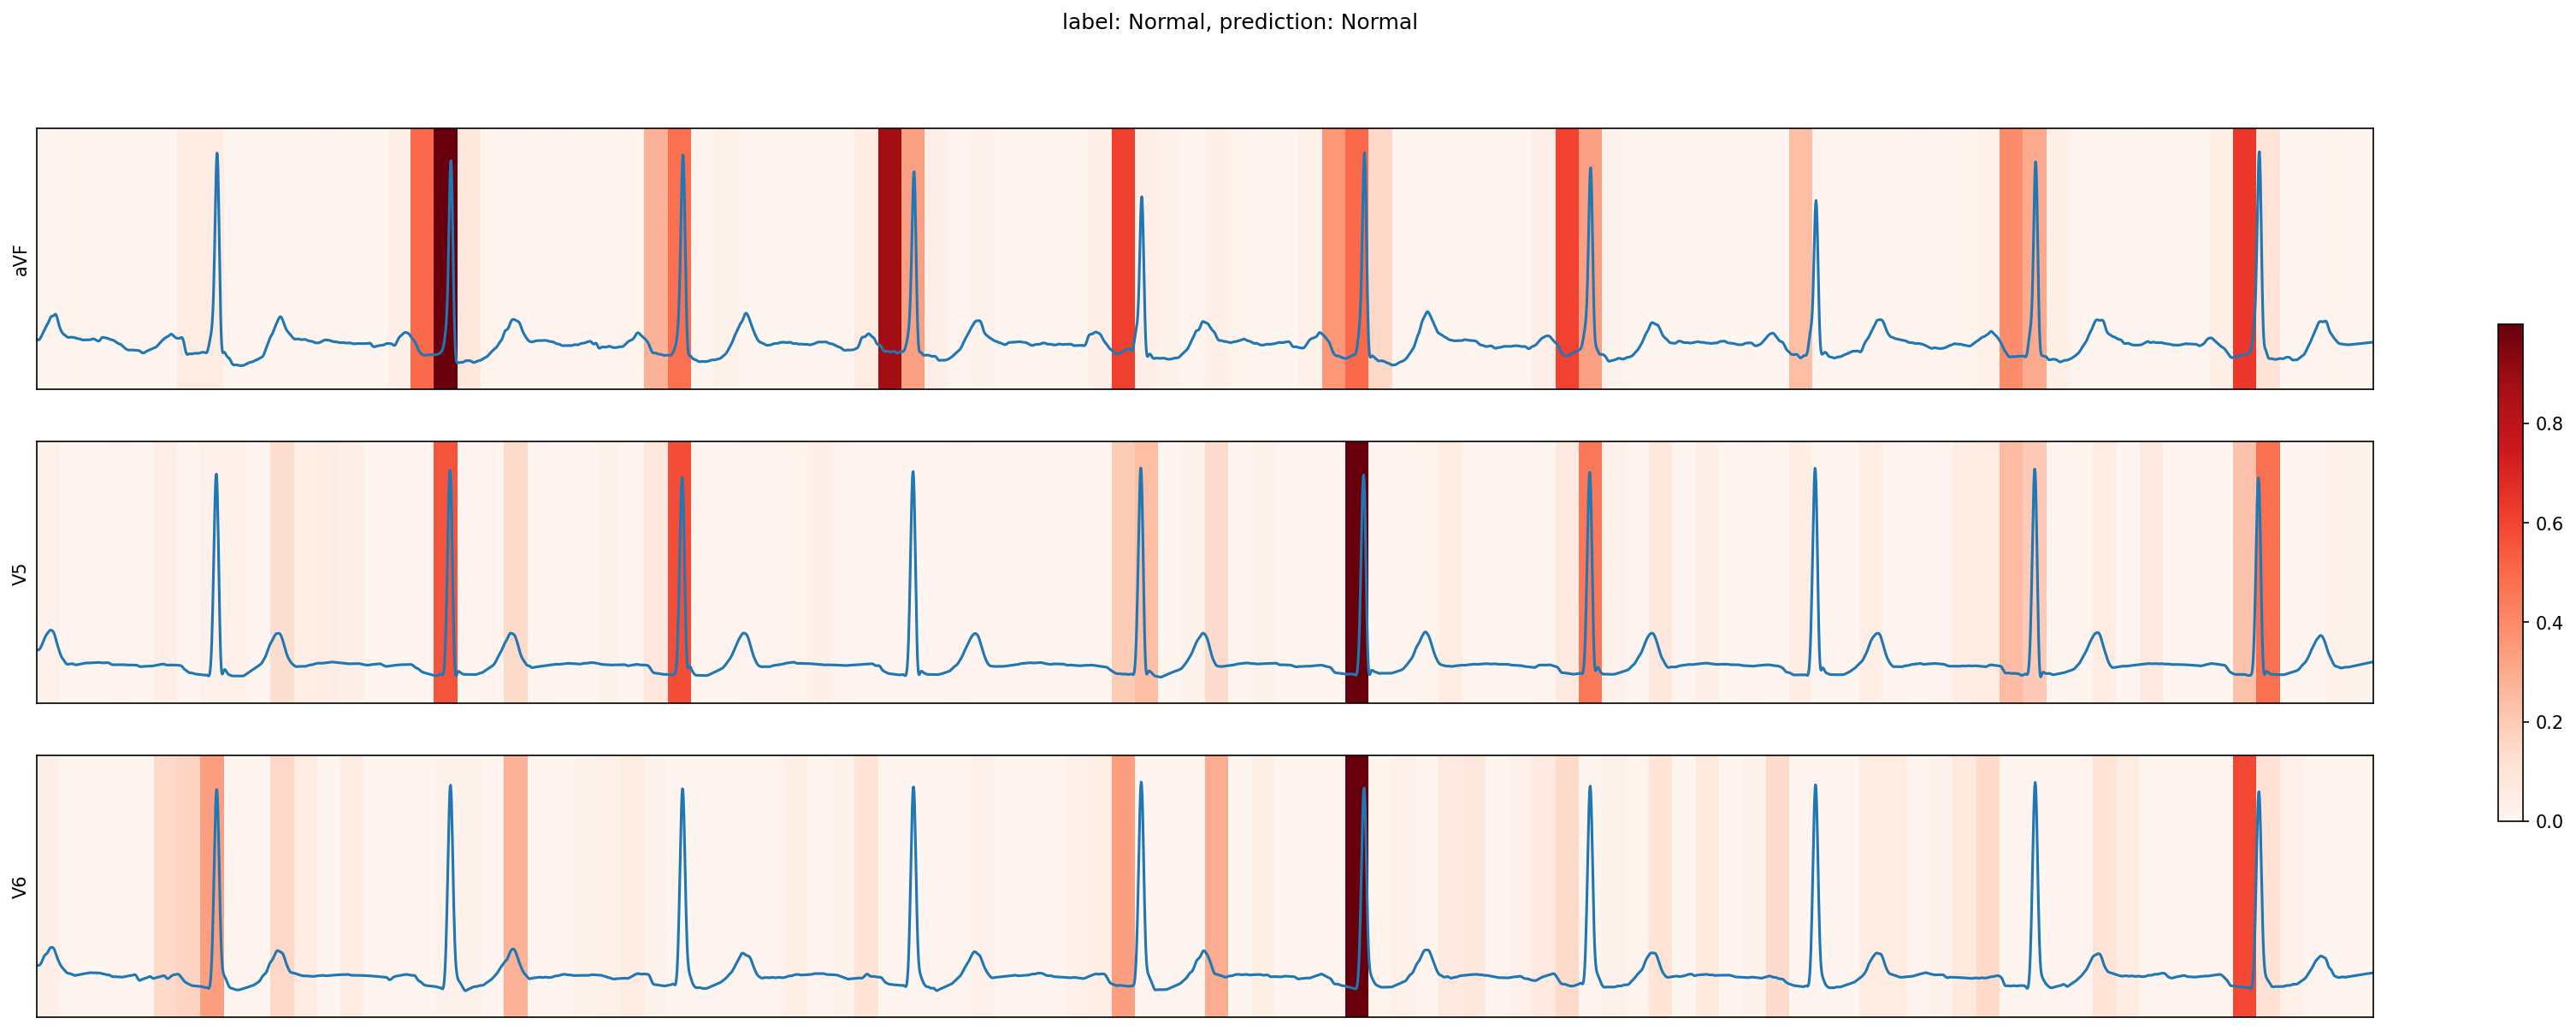

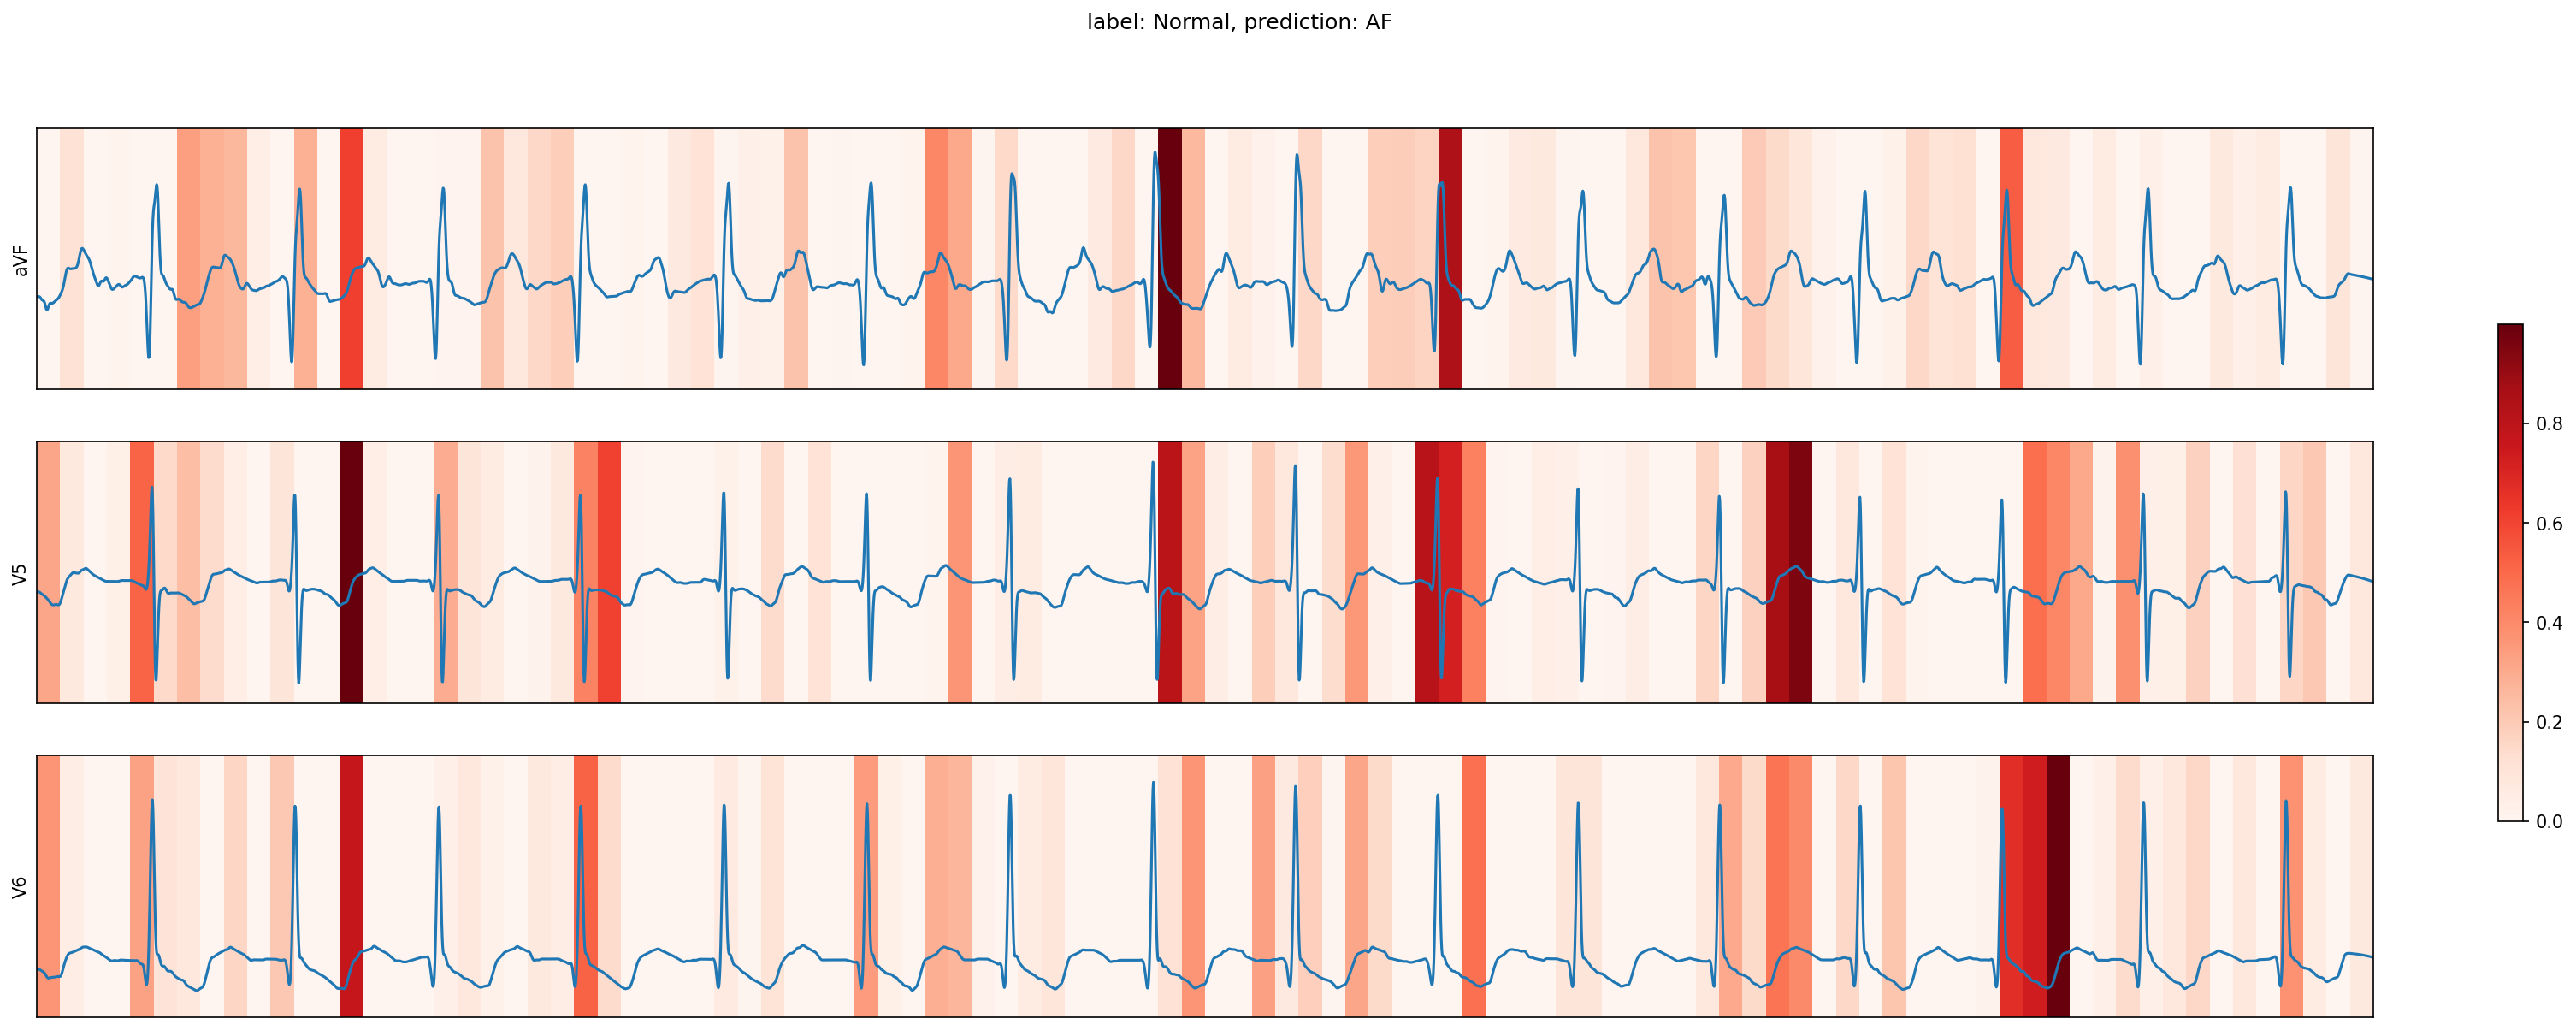

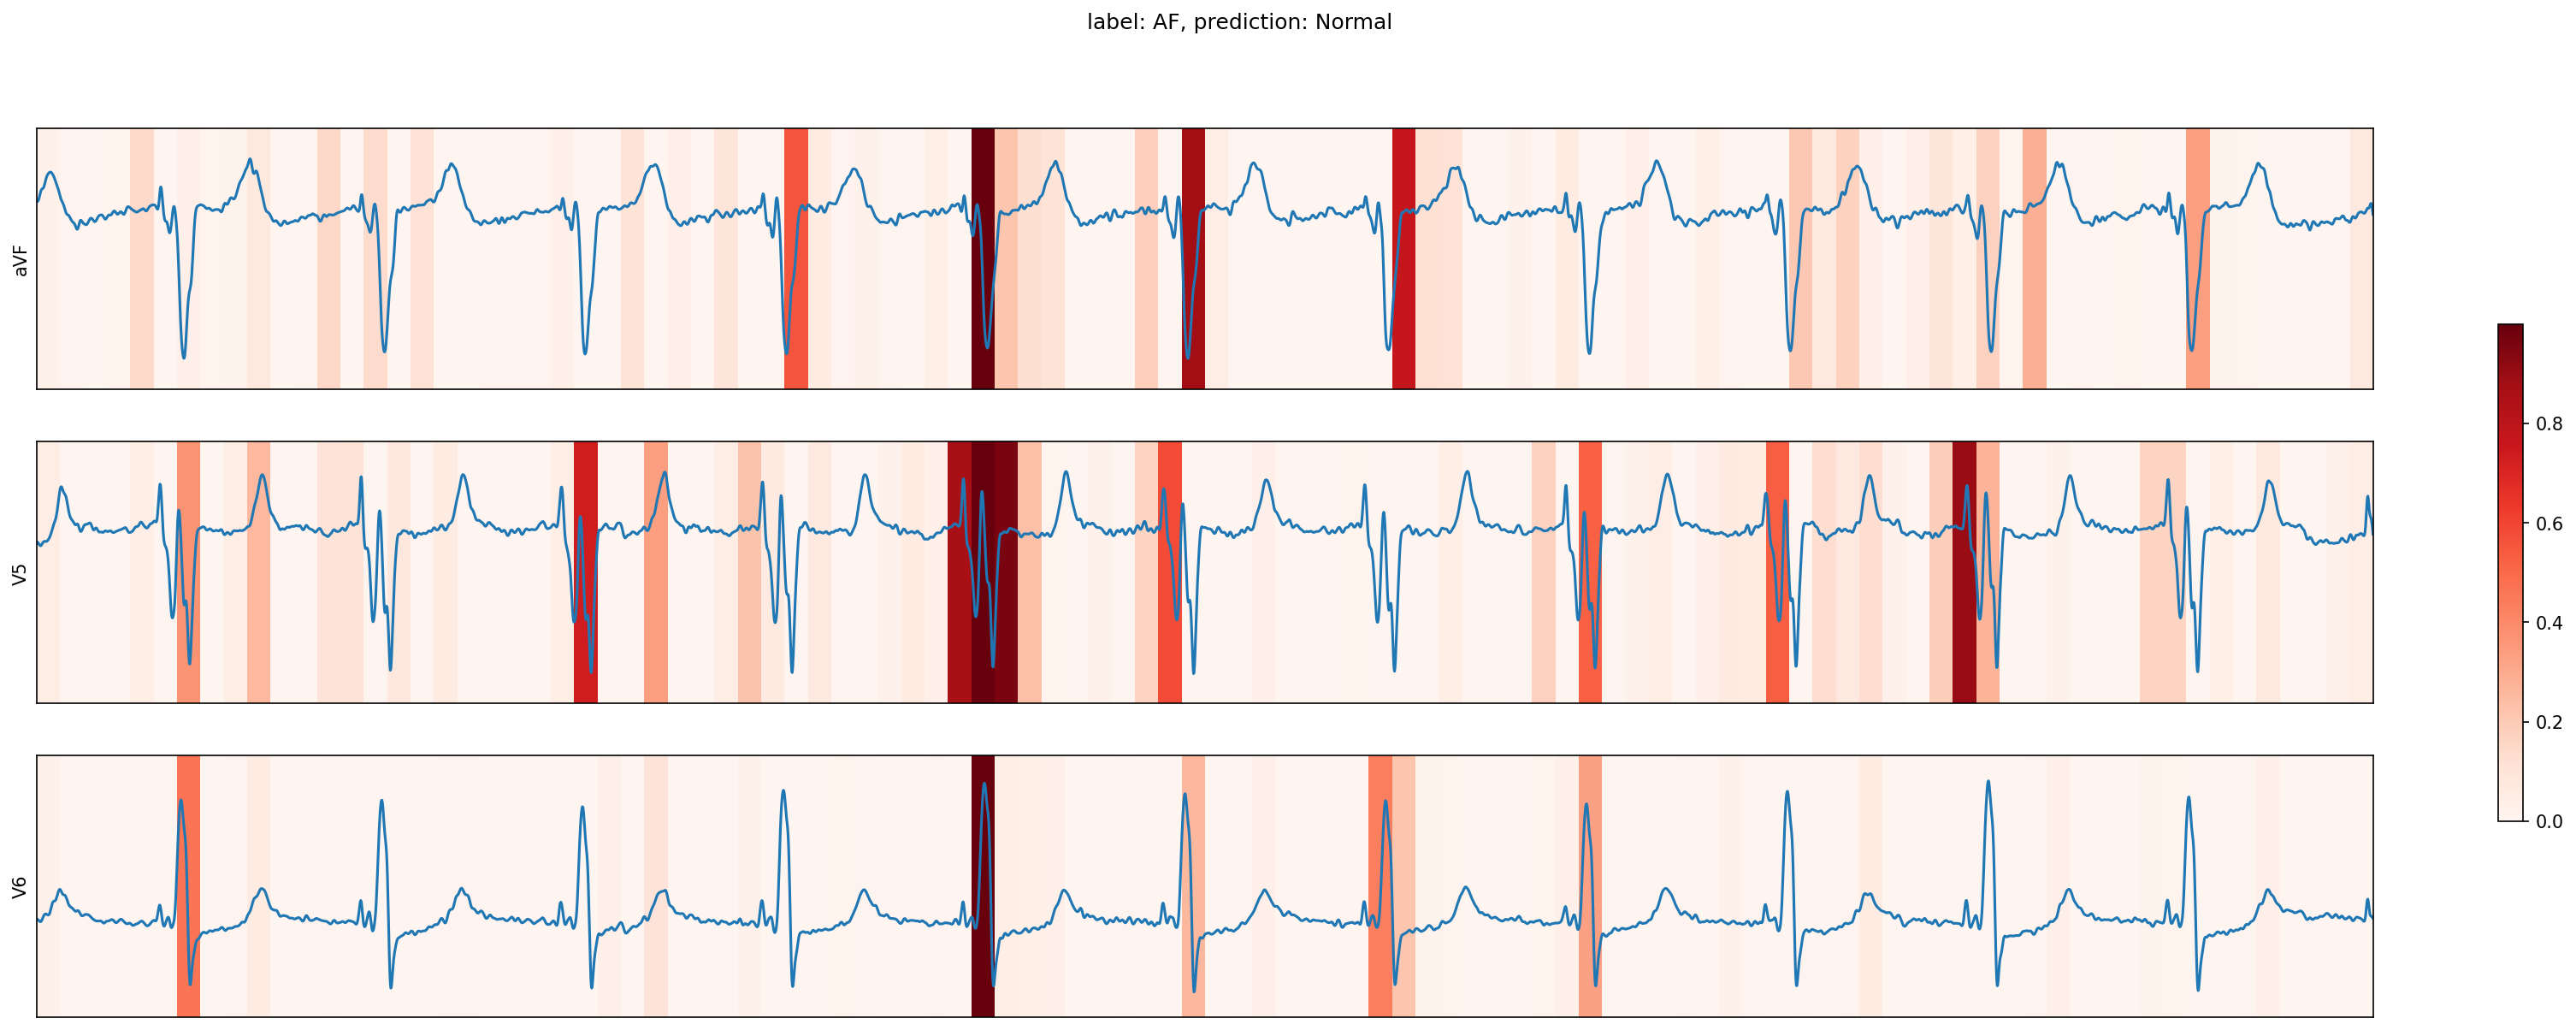

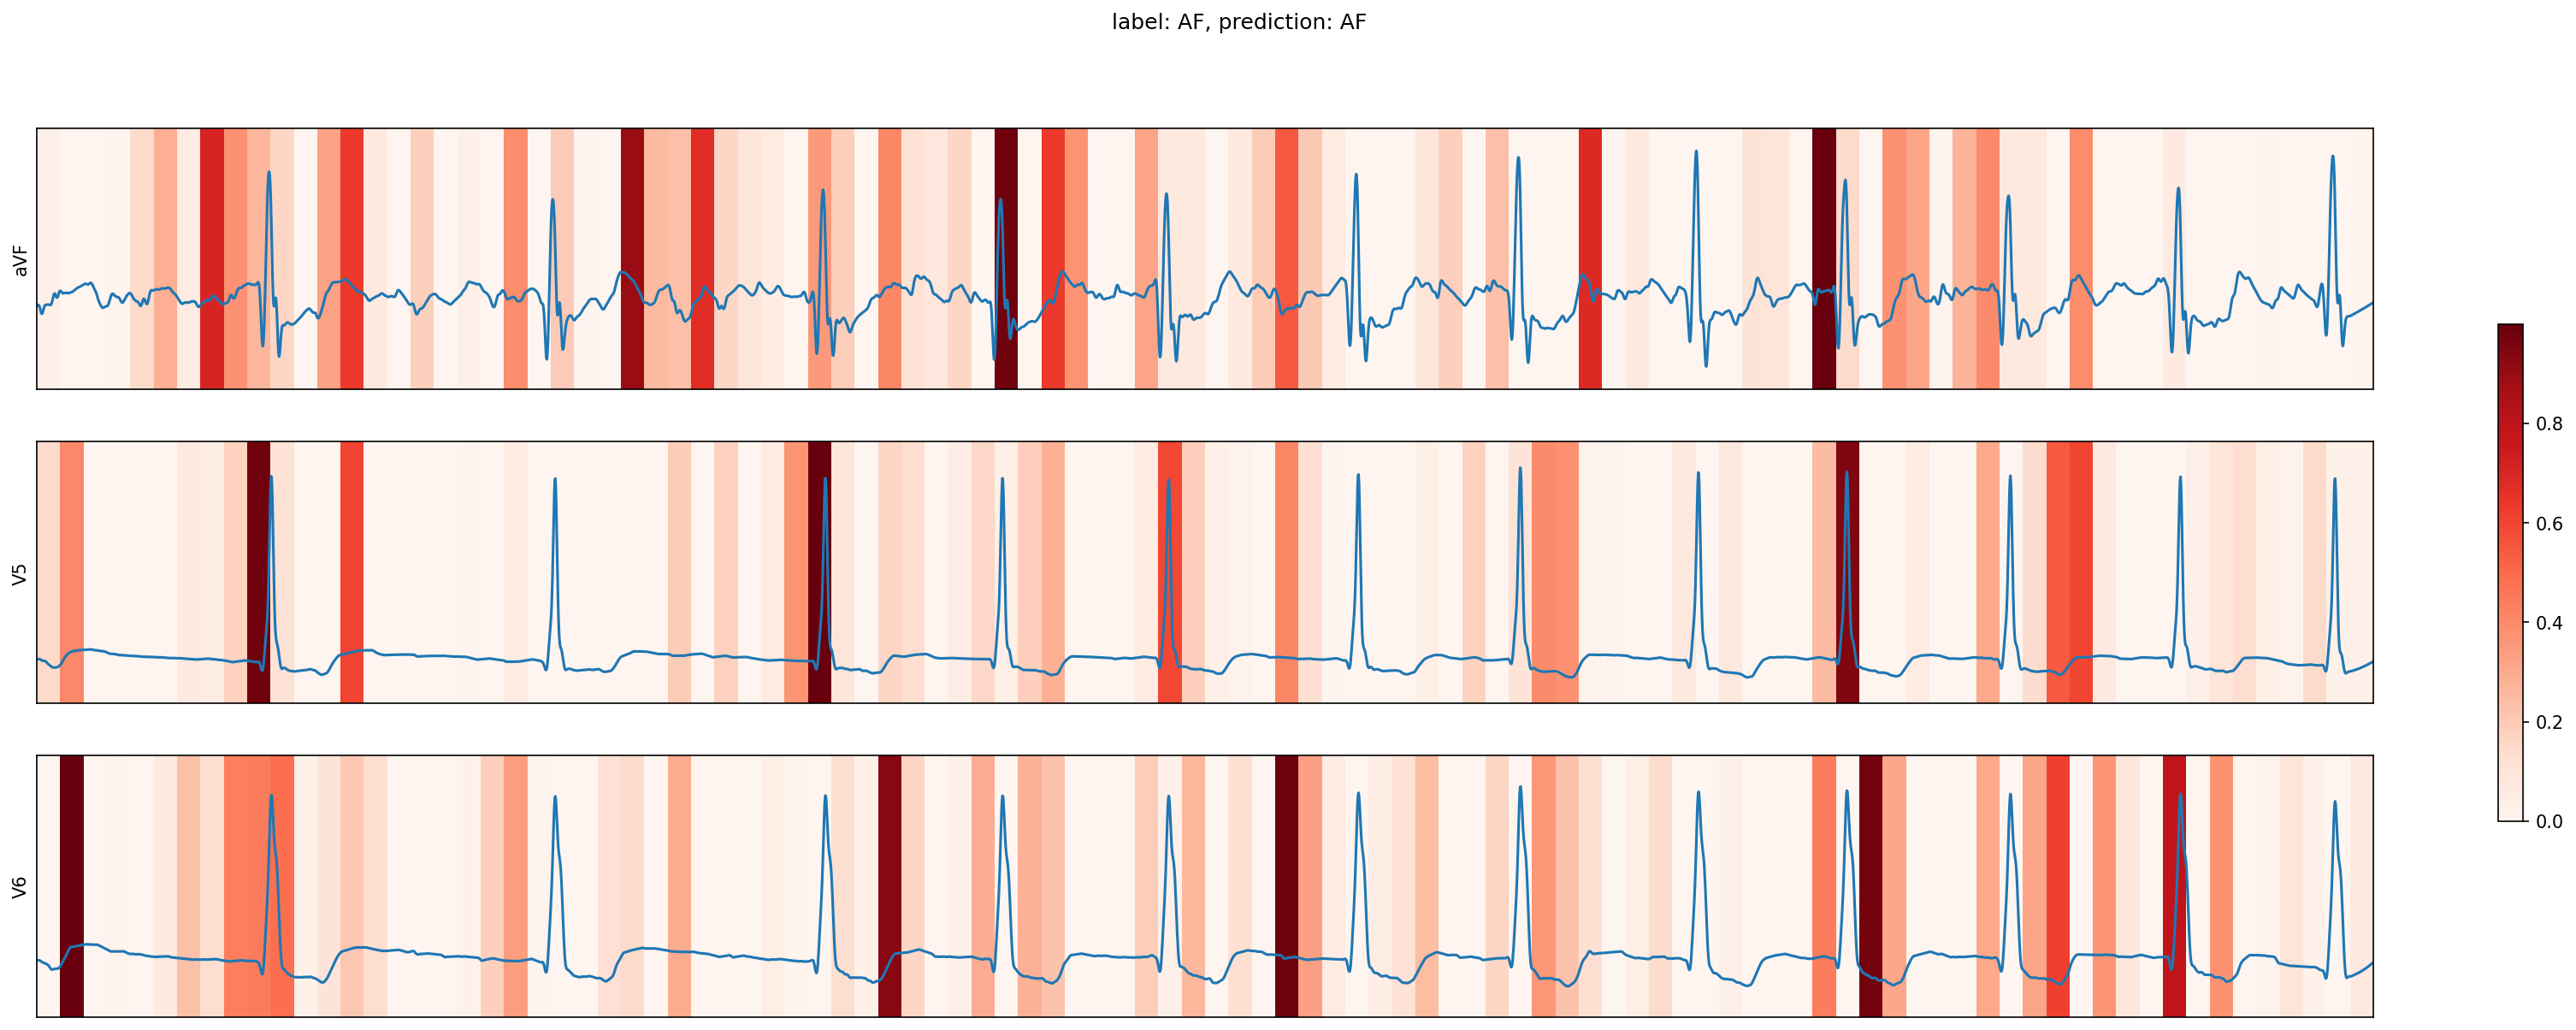

In [78]:
#fig,axs = plt.subplots(4,1,figsize=(20,10))
classes = ['Normal','AF']
for i,file in enumerate(to_explain):
    label_idx = np.argmax(y_scores[i])
    sv_data = svs[label_idx,i]
    sv_data_mean = np.mean(sv_data,axis=1)
    #print(sv_data_mean)
    #top_leads = np.where(sv_data_mean>1e-5)[0]
    #print(top_leads)
    ecg = prepare_input(file,three_leads)
    fig,axs = plt.subplots(3,1,figsize=(25,9),dpi=150)
    fig.suptitle('label: %s, prediction: %s' %(classes[i//2],classes[i%2]))
    plot_shap(ecg,sv_data,three_leads,i%2)
    plt.savefig('SHAP_%d.png'%(i+1))
    plt.show()

#### LIME

In [81]:
# create Lime for timeseries
class TSDomainMapper(explanation.DomainMapper):
    def __init__(self,signal_names,num_slices,is_multivariate):
        self.num_slices = num_slices
        self.signal_names = signal_names
        self.is_multivariate = is_multivariate
    def map_exp_ids(self,exp,**kwargs):
        if not self.is_multivariate:
            return exp
        names = []
        for _id,weight in exp:
            nsignal = int(_id/self.num_slices)
            nslice = _id%self.num_slices
            signalname = self.signal_names[nsignal]
            featurename = '%d-%s' % (nslice,signalname)
            names.append((featurename,weight))
        return names

class LimeTimeSeriesExplainer(object):
    def __init__(self,kernel_width=25,verbose=False,class_names=None,feature_selection='auto',signal_names=['not specified']):
        def kernel(d): return np.sqrt(np.exp(-(d**2)/kernel_width**2))
        self.base = lime_base.LimeBase(kernel,verbose)
        self.class_names = class_names
        self.feature_selection = feature_selection
        self.signal_names = signal_names
        
    def explain_instance(self,timeseries,classifier_fn,num_slices,labels=(1,),top_labels=None,num_features=10,num_samples=5000,distance_metric='cosine',model_regressor=None,replacement_method='noise'):
        data,yes,distances = self.__data_labels_distances(timeseries,classifier_fn,num_samples,num_slices,replacement_method)
        is_multivariate = len(timeseries.shape)>1
        if self.class_names is None:
            self.class_names = [str(x) for x in range(yes[0].shape[0])]
        domain_mapper = TSDomainMapper(self.signal_names,num_slices,is_multivariate)
        ret_exp = explanation.Explanation(domain_mapper=domain_mapper,class_names=self.class_names)
        ret_exp.predict_proba = yes[0]
        for label in labels:
            #print(data.shape)
            (ret_exp.intercept[int(label)],
             ret_exp.local_exp[int(label)],
             ret_exp.score,ret_exp.local_pred) = self.base.explain_instance_with_data(data,yes,distances,label,num_features,feature_selection=self.feature_selection)
        #ret_exp.local_exp = {k:[(int(j1), float(j2)) for j1,j2 in v] for k,v in ret_exp.local_exp.items()}
        return ret_exp
    
    #@classmethod
    def __data_labels_distances(cls,time_series,classifier_fn,num_samples,num_slices,replacement_method='noise'):
        def distance_fn(x):
            return sklearn.metrics.pairwise.pairwise_distances(x,x[0].reshape([1,-1]),metric='cosine').ravel()*100
        num_channels = 1
        len_ts = len(time_series)
        if len(time_series.shape)>1:
            num_channels,len_ts = time_series.shape
        values_per_slice = int(math.ceil(len_ts/num_slices))
        #print(values_per_slice)
        
        sampel = np.random.randint(1,num_slices+1,num_samples-1)
        data = np.ones((num_samples,num_channels,num_slices))
        features_range = range(num_slices)
        inverse_data = [time_series.clone().cpu().numpy()]
        
        for i,size in enumerate(sampel,start=1):
            inactive = np.random.choice(features_range,size,replace=False)
            num_channels_to_data = np.random.randint(1,num_channels+1)
            channels_to_data = np.random.choice(range(num_channels),num_channels_to_data,replace=False)
            for chan in channels_to_data:
                data[i,chan,inactive] = 0
            tmp_series = time_series.clone().cpu().numpy()
            #print(tmp_series.shape)
            
            for i in inactive:
                start_idx = i*values_per_slice
                end_idx = start_idx+values_per_slice
                end_idx = min(end_idx,len_ts)
                if replacement_method == 'noise':
                    if len(tmp_series.shape) ==1:
                        tmp_series[start_idx:end_idx]=np.random.uniform(tmp_series.min(),tmp_series.max(),end_idx-start-idx)
                        return
                    for chan in channels_to_data:
                        tmp_series[chan][start_idx:end_idx] = np.random.uniform(tmp_series[chan].min(),tmp_series[chan].max(),end_idx-start_idx)
            inverse_data.append(tmp_series)
        #print(len(inverse_data[499]))
        labels = classifier_fn(np.array(inverse_data))
        data = data.reshape((num_samples,num_channels*num_slices))
        distances = distance_fn(data)
        return data,labels,distances

In [82]:
def limepred(ecg):
    ecg = torch.tensor(ecg).float().to(device)
    preds = model_resnet31(ecg)
    classpreds = F.softmax(preds,dim=1)
    return classpreds.detach().cpu().numpy()

In [46]:
def plot_lime(ecg_data,hmap,leads):
    ecg_data = ecg_data.cpu().numpy()
    nleads = len(leads)
    nsteps = 5000
    x = range(nsteps)
    ecg_data = ecg_data[:,0:nsteps]
    #heatmap = heatmap[:,0:nsteps]
    hmap = hmap[:,0:nsteps]
    hmap = np.maximum(hmap,0)
    map_min = np.min(hmap,axis=1,keepdims=True)
    map_max = np.max(hmap,axis=1,keepdims=True)
    heatmap = (hmap-map_min)/(map_max-map_min+1e-10)
    for i,lead in enumerate(leads):
        ax = axs[i]
        ax.plot(x,ecg_data[i])
        #im=ax.scatter(x,ecg_data[i],c=heatmap[i],cmap='jet')
        show_map = np.expand_dims(heatmap[i],0)
        im = ax.imshow(show_map,cmap='Reds',aspect='auto',interpolation='nearest',vmin=show_map.min(),vmax=show_map.max(),alpha=1.0,
                      extent=[0,5000,ecg_data[i].min()-0.001,ecg_data[i].max()+0.001])
        ax.set_xlim((0,5000))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(leads[i])
    fig.colorbar(im,ax=axs[:],fraction=0.01)  

50


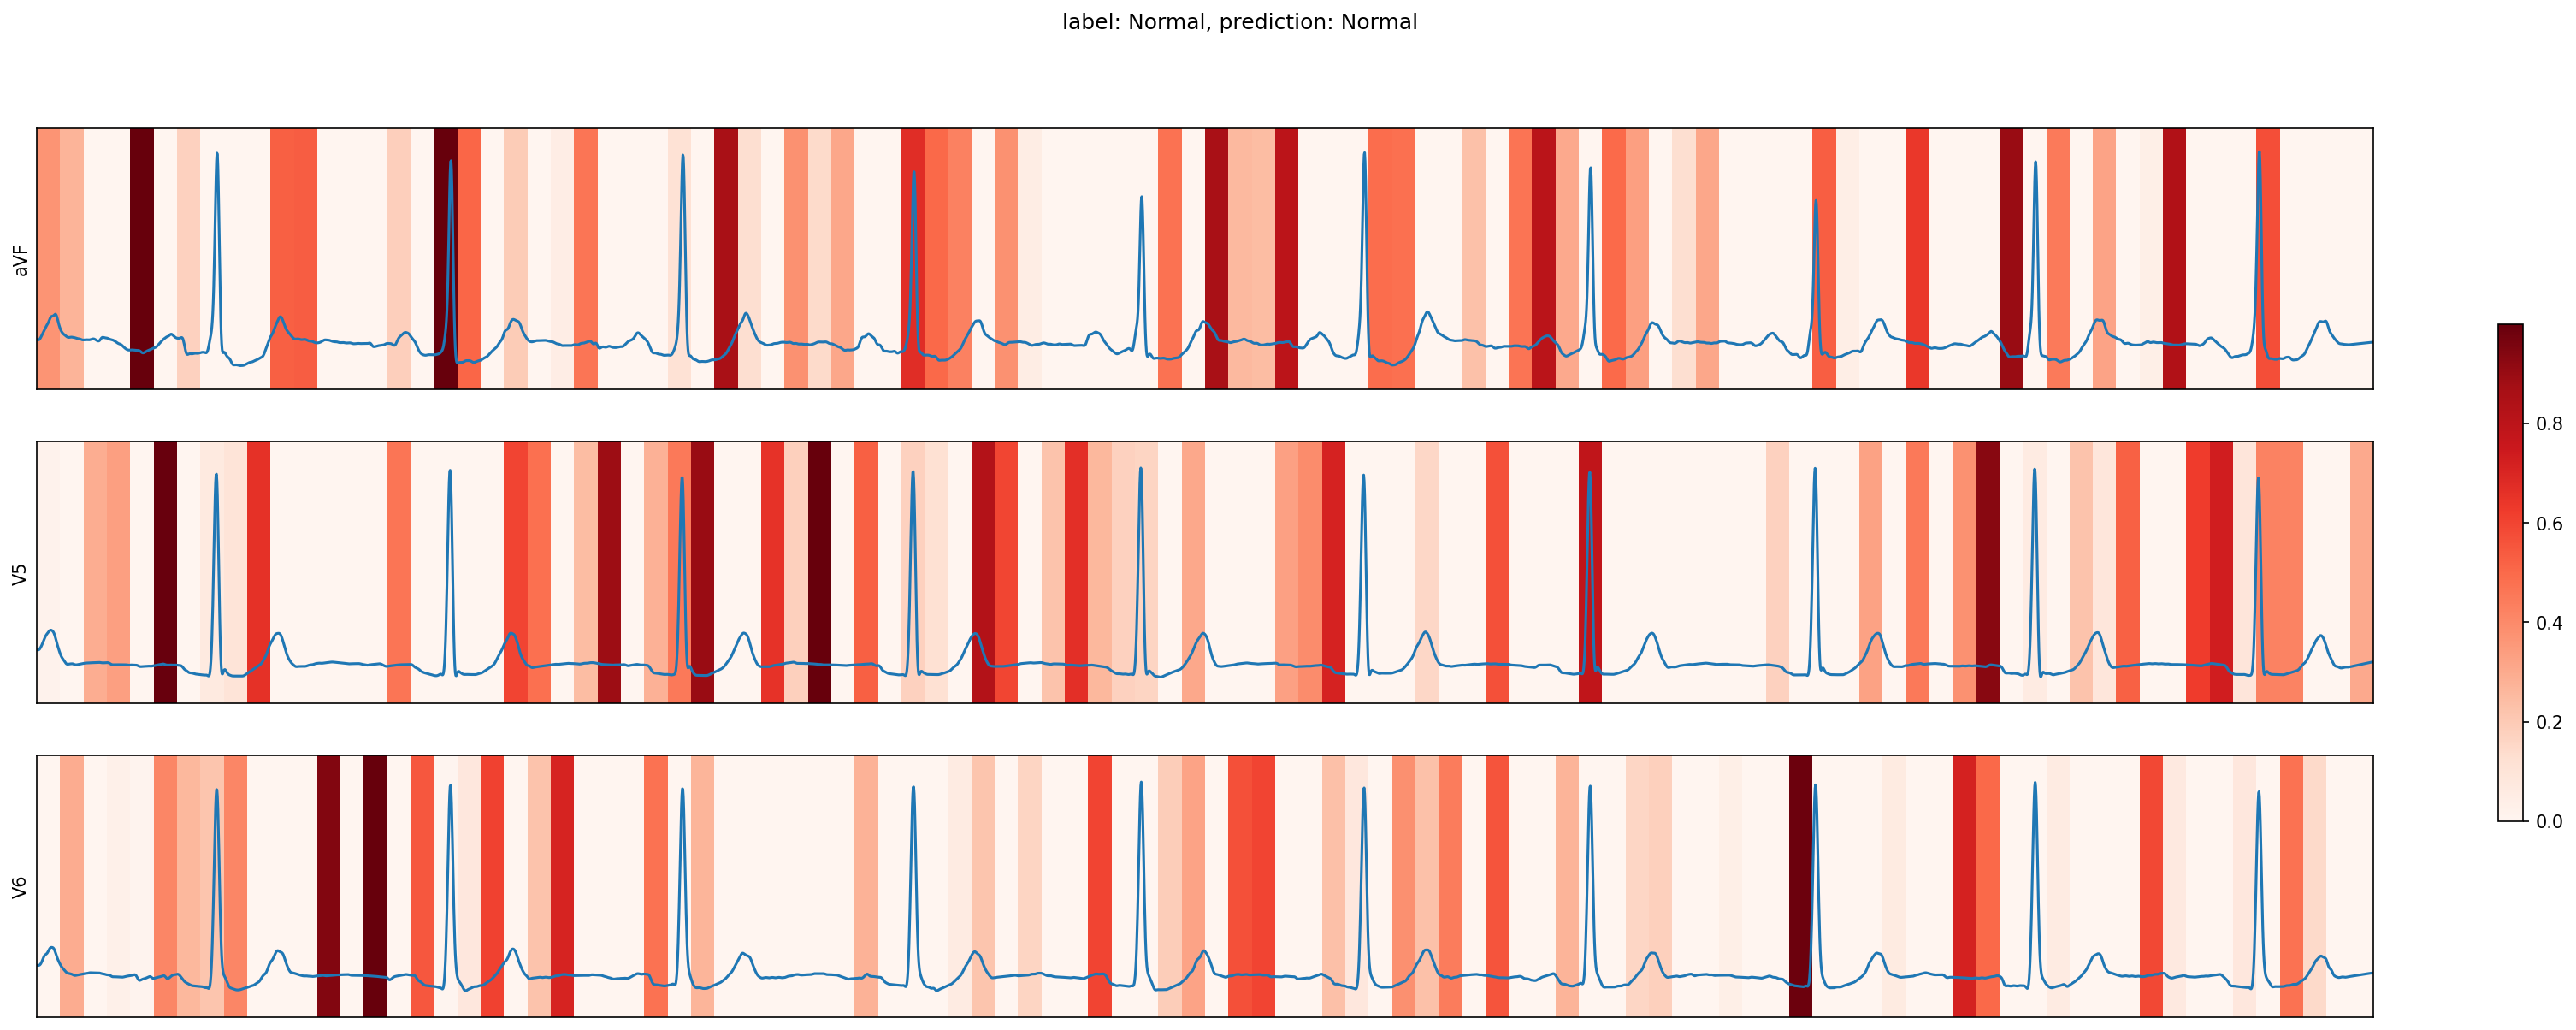

50


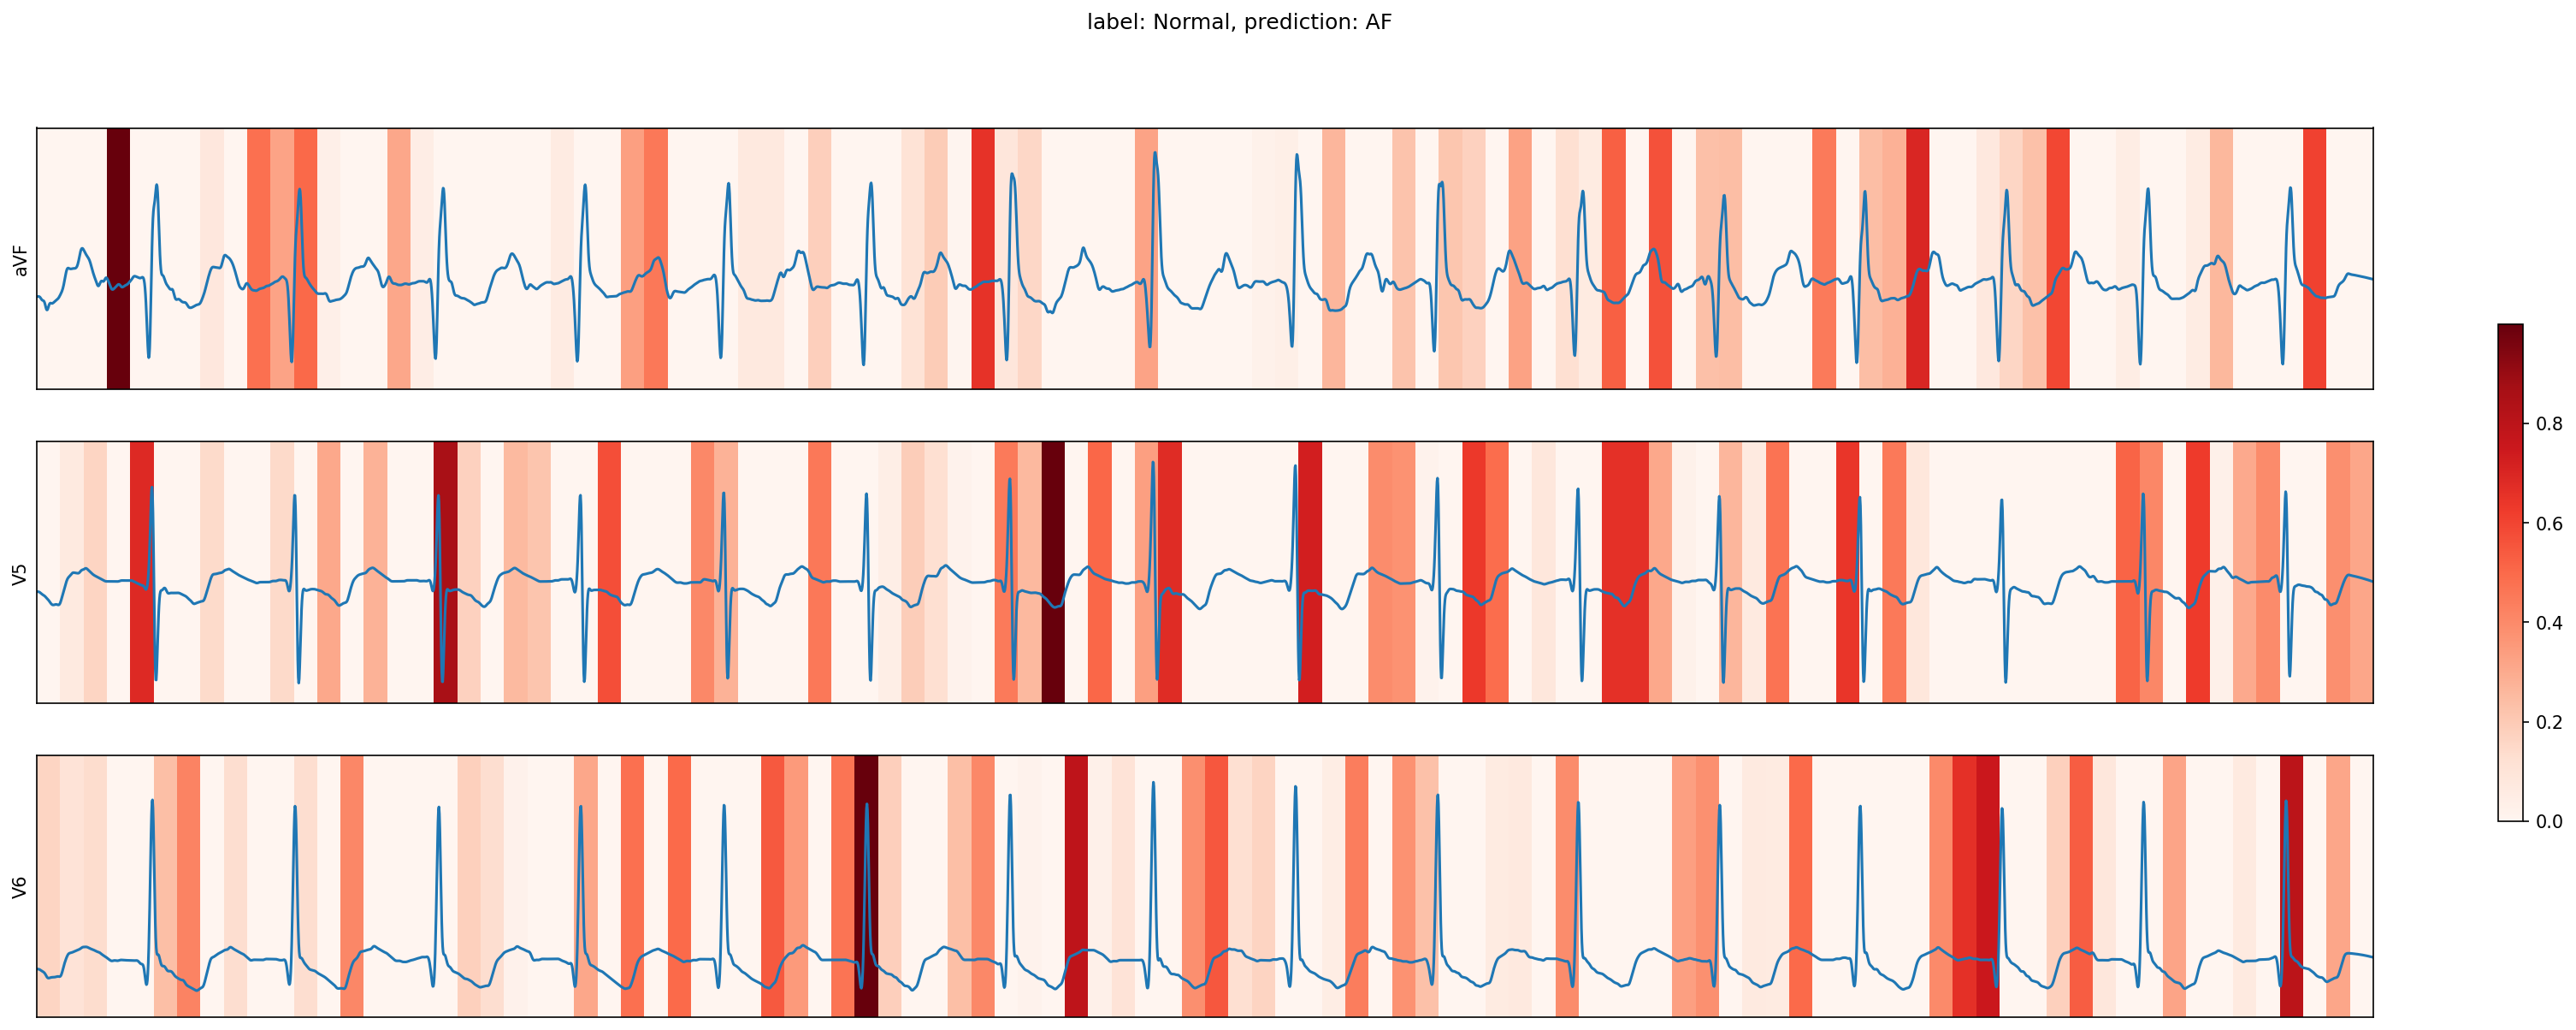

50


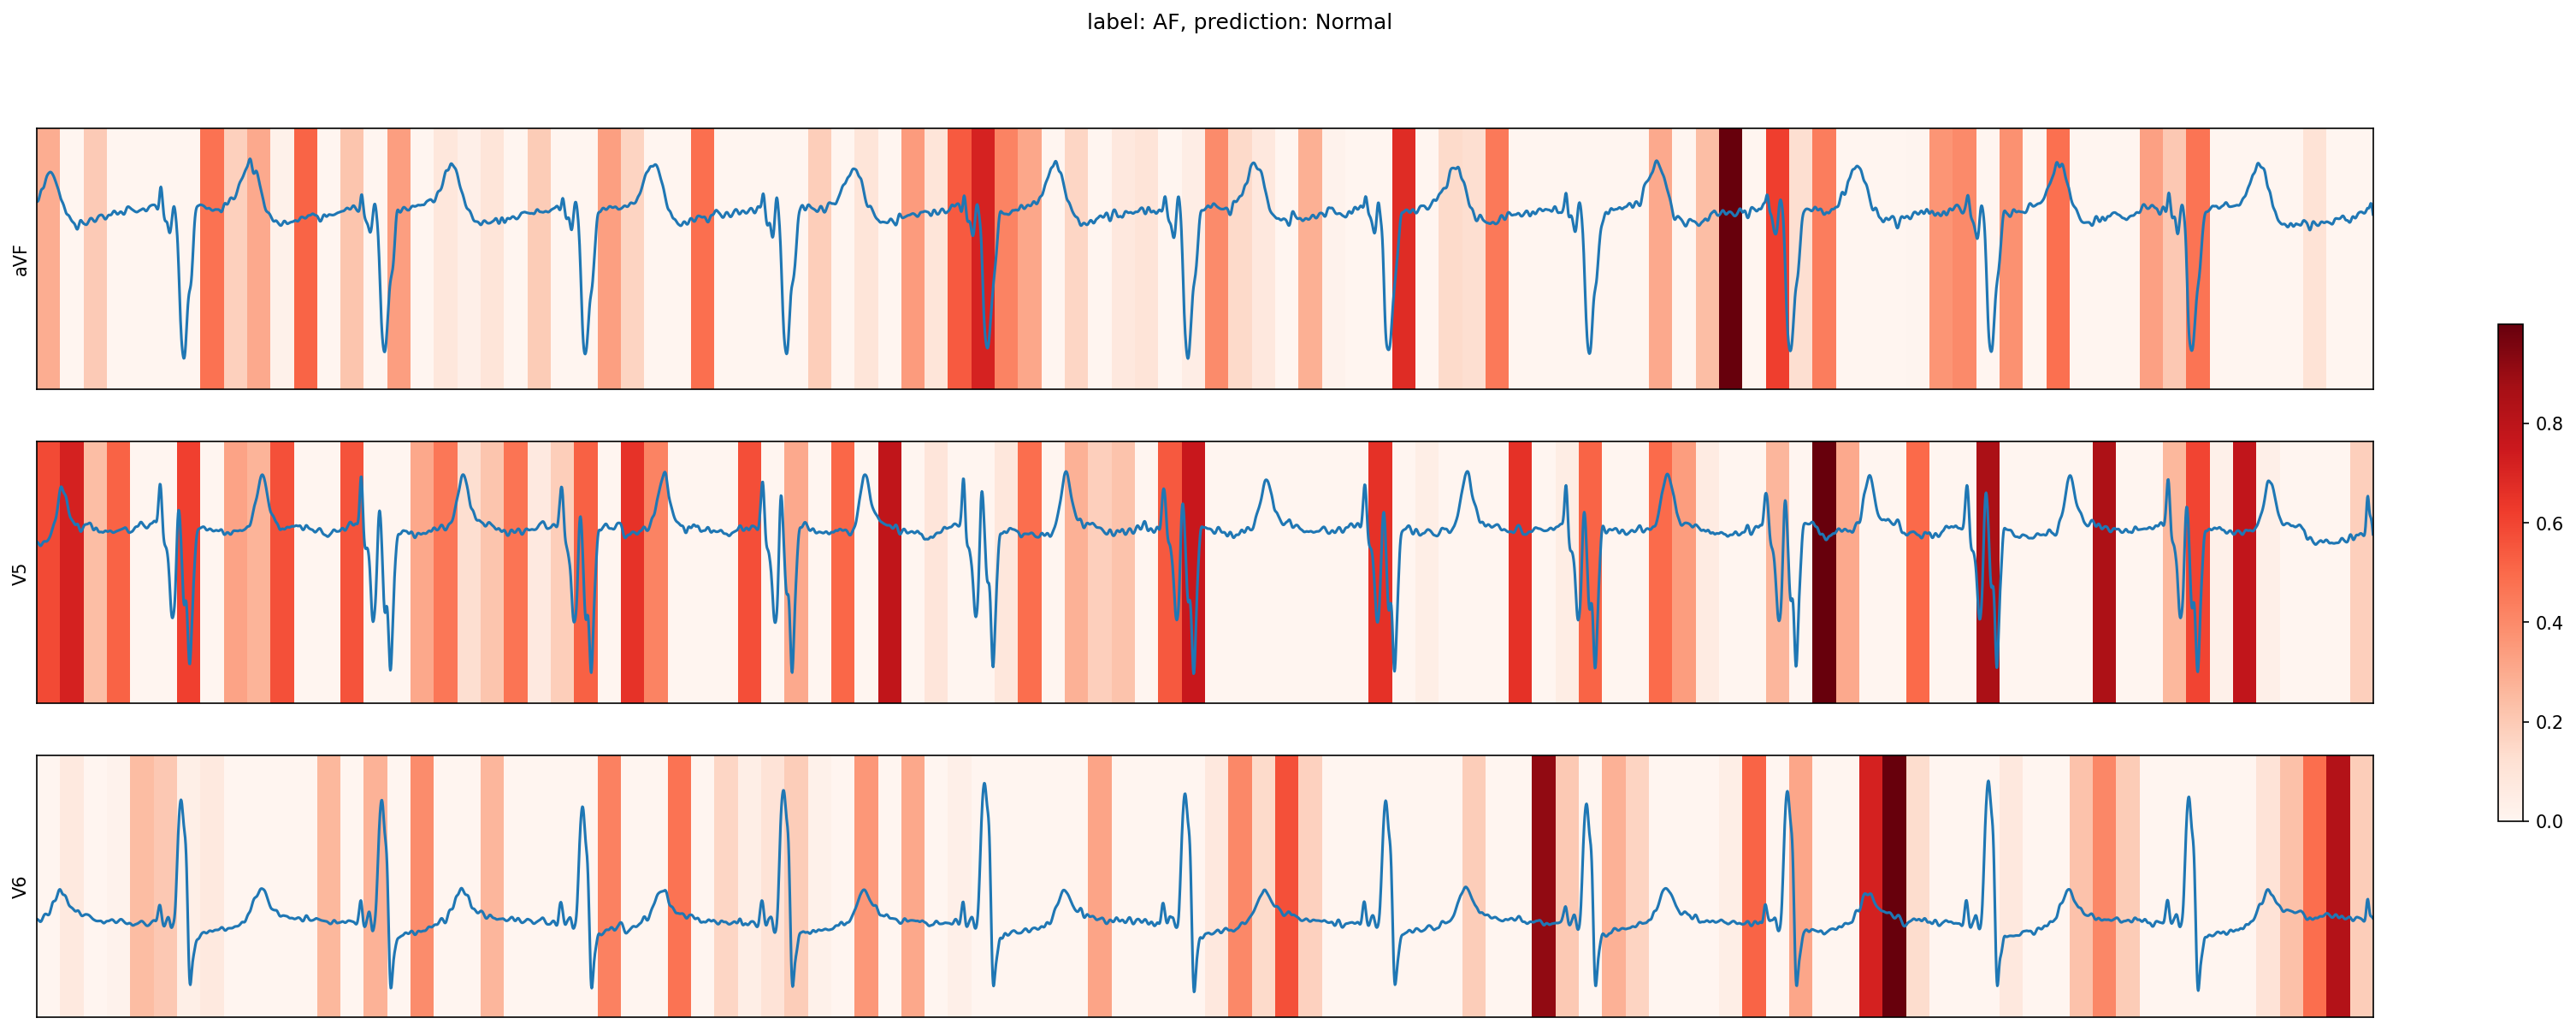

50


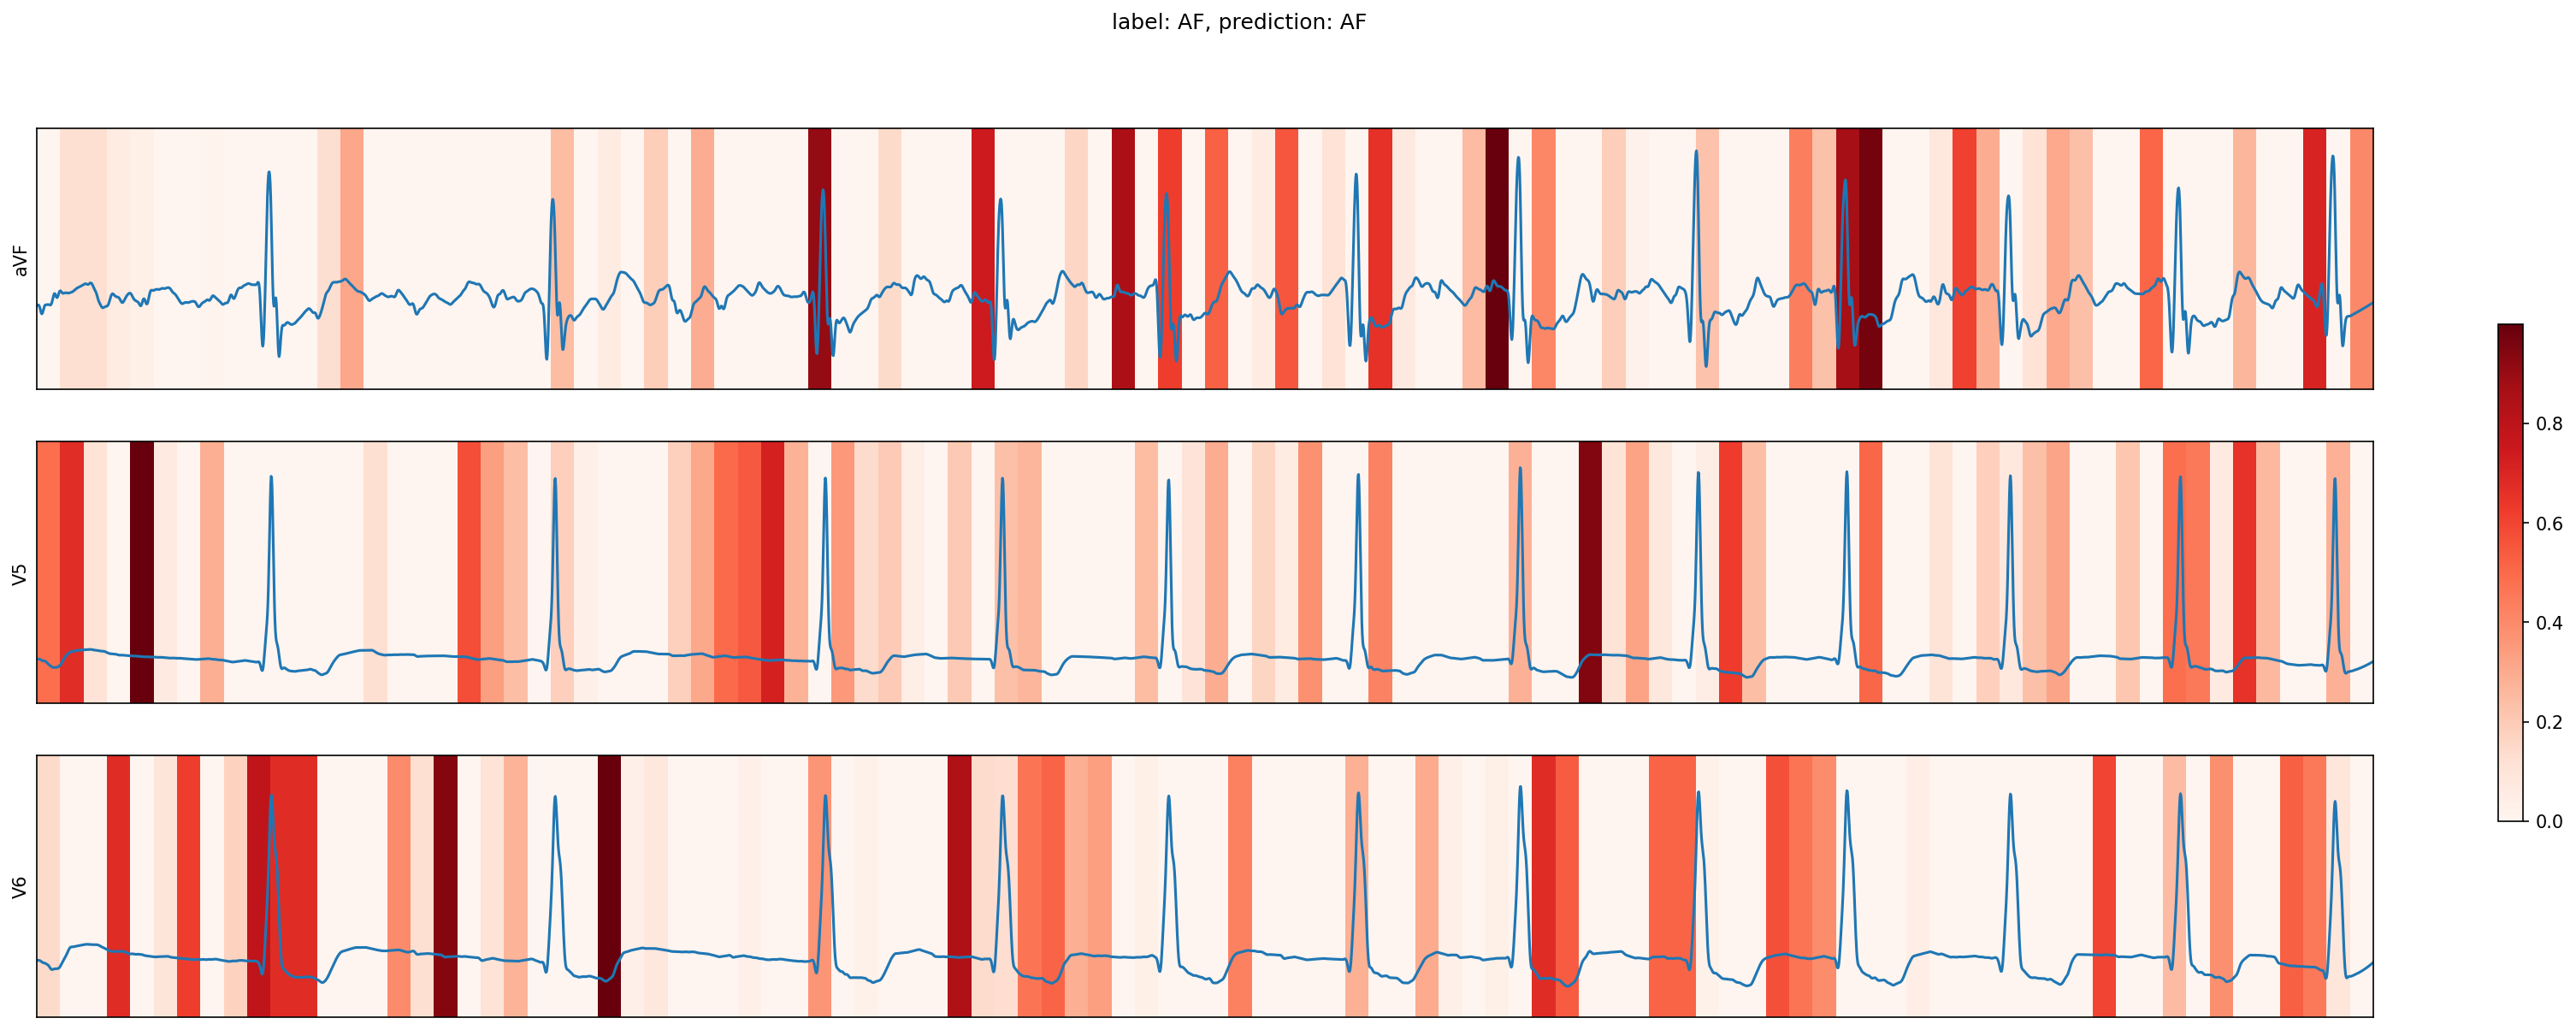

In [47]:
classes = ['Normal','AF']
e = LimeTimeSeriesExplainer(class_names=['0','1'],signal_names=three_leads)
for i,file in enumerate(to_explain):
    ecg = prepare_input(file,three_leads)
    exp = e.explain_instance(ecg,limepred,num_features=300,num_samples=500,num_slices=100,replacement_method='noise')
    explainations = exp.as_list()
    #print(exp.shape)
    #print(explainations)
    heatmap = np.zeros((3,5000))
    slice_len = int(math.ceil(ecg.shape[1]/100))
    print(slice_len)
    for k in explainations:
        start_idx = int(k[0].split('-')[0])*slice_len
        end_idx = start_idx+slice_len
        #print(k[1]* np.ones(slice_len))
        if k[0].split('-')[1]=='aVF':
            heatmap[0][start_idx:end_idx]=k[1]* np.ones(slice_len)
        elif k[0].split('-')[1]=='V5':
            heatmap[1][start_idx:end_idx]=k[1]* np.ones(slice_len)
        elif k[0].split('-')[1]=='V6':
            heatmap[2][start_idx:end_idx]=k[1]* np.ones(slice_len)
    #print(heatmap[0])        
    fig,axs = plt.subplots(3,1,figsize=(25,9),dpi=150)
    fig.suptitle('label: %s, prediction: %s' %(classes[i//2],classes[i%2]))
    plot_lime(ecg,heatmap,three_leads)
    plt.savefig('LIME_%d.png'%(i+1))
    plt.show()

### Use Grad-CAM to compare the difference bewell classified AF and misclassified AF

In [67]:
af_cs = test_result.loc[(test_result['labels'] == 1) & (test_result['preds'] == 1), 'filenames'].sample(n=3).values[0:3]
af_ws = test_result.loc[(test_result['labels'] == 1) & (test_result['preds'] == 0), 'filenames'].sample(n=3).values[0:3]
af_explain = np.concatenate((af_cs,af_ws))
print(af_explain)

['/kaggle/input/mscproject-data/mscproject_data/mscproject_dataset/JS08493.mat'
 '/kaggle/input/mscproject-data/mscproject_data/mscproject_dataset/E08524.mat'
 '/kaggle/input/mscproject-data/mscproject_data/mscproject_dataset/HR20100.mat'
 '/kaggle/input/mscproject-data/mscproject_data/mscproject_dataset/JS09843.mat'
 '/kaggle/input/mscproject-data/mscproject_data/mscproject_dataset/HR14628.mat'
 '/kaggle/input/mscproject-data/mscproject_data/mscproject_dataset/A5380.mat']


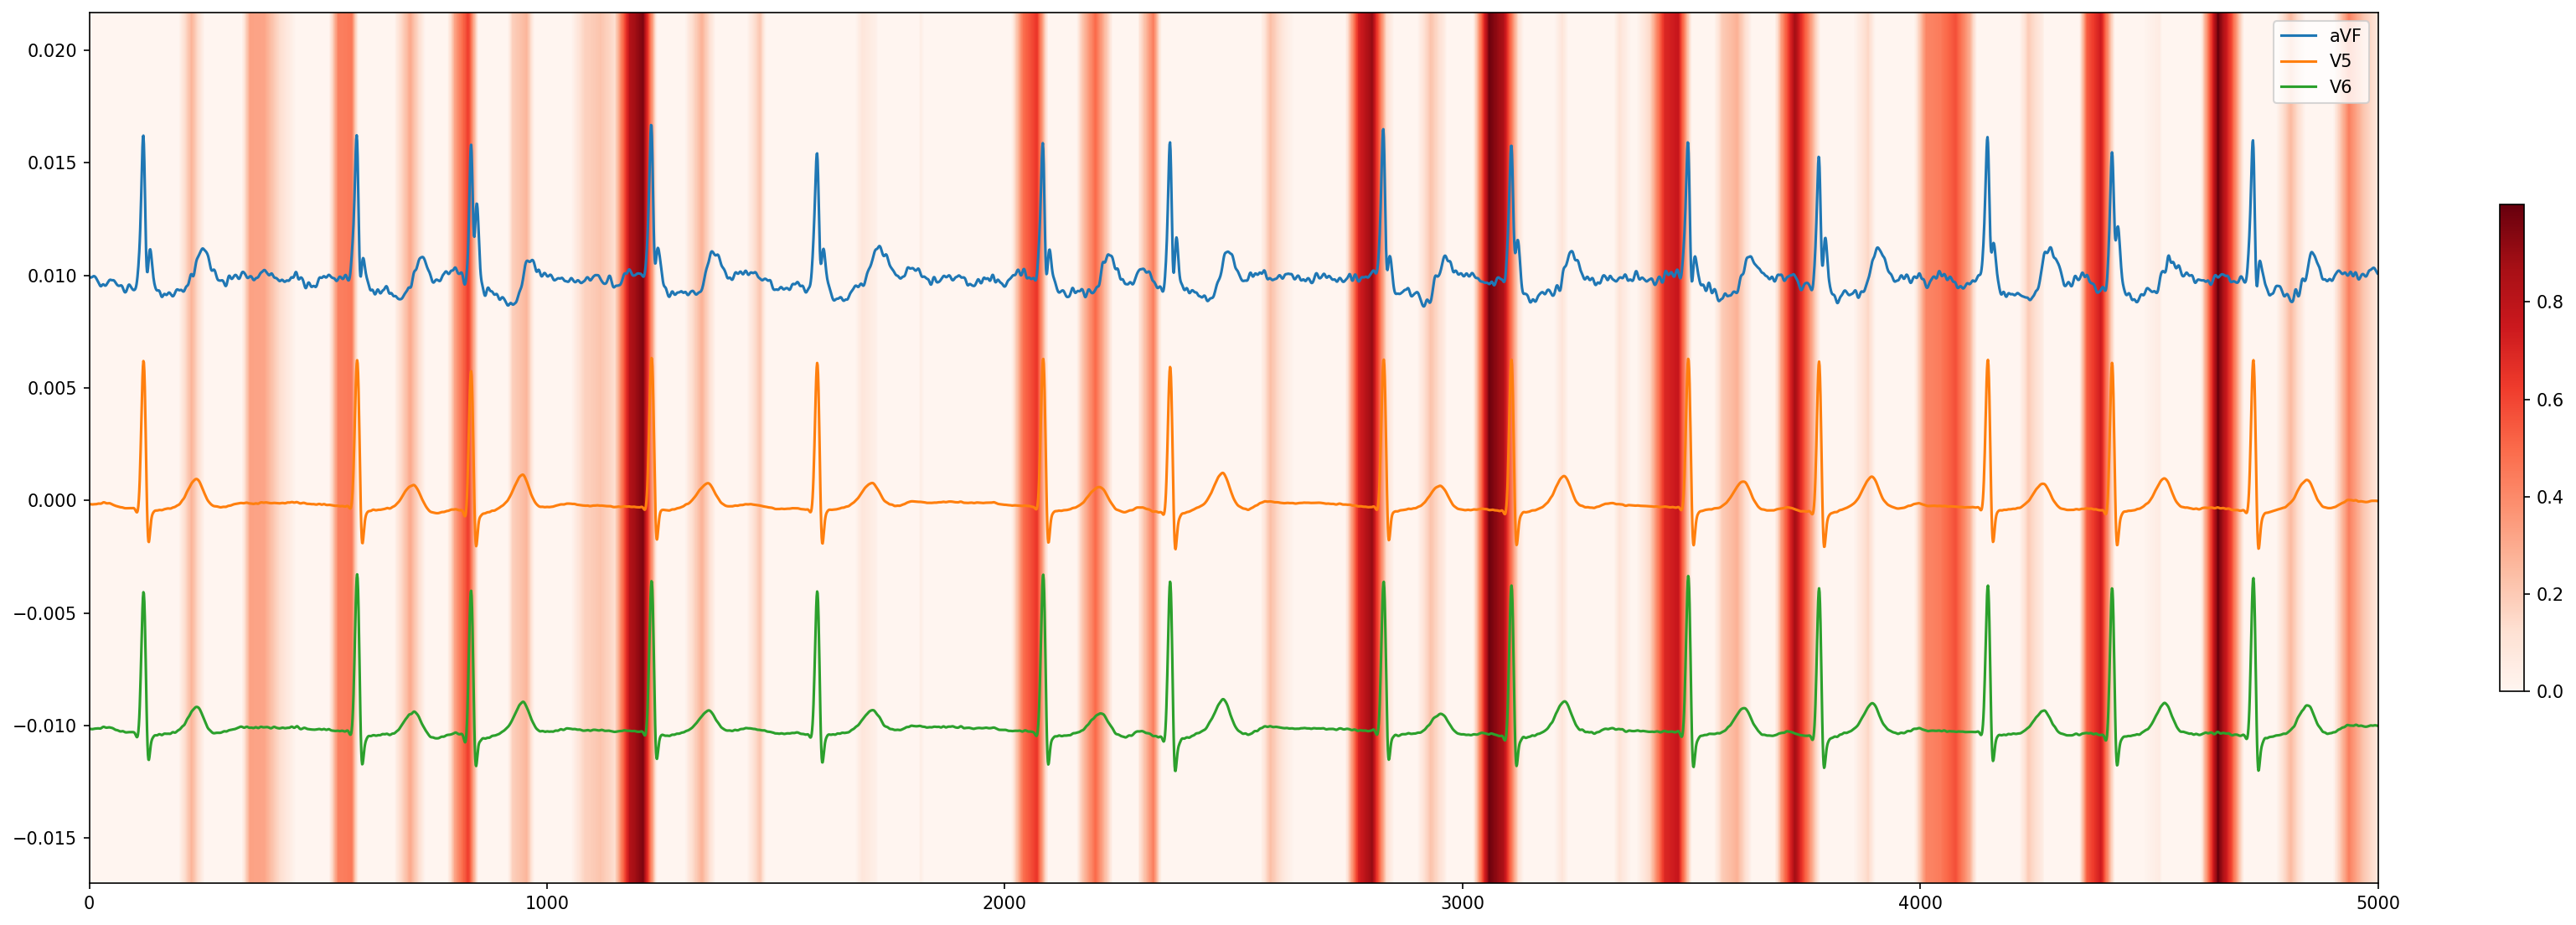

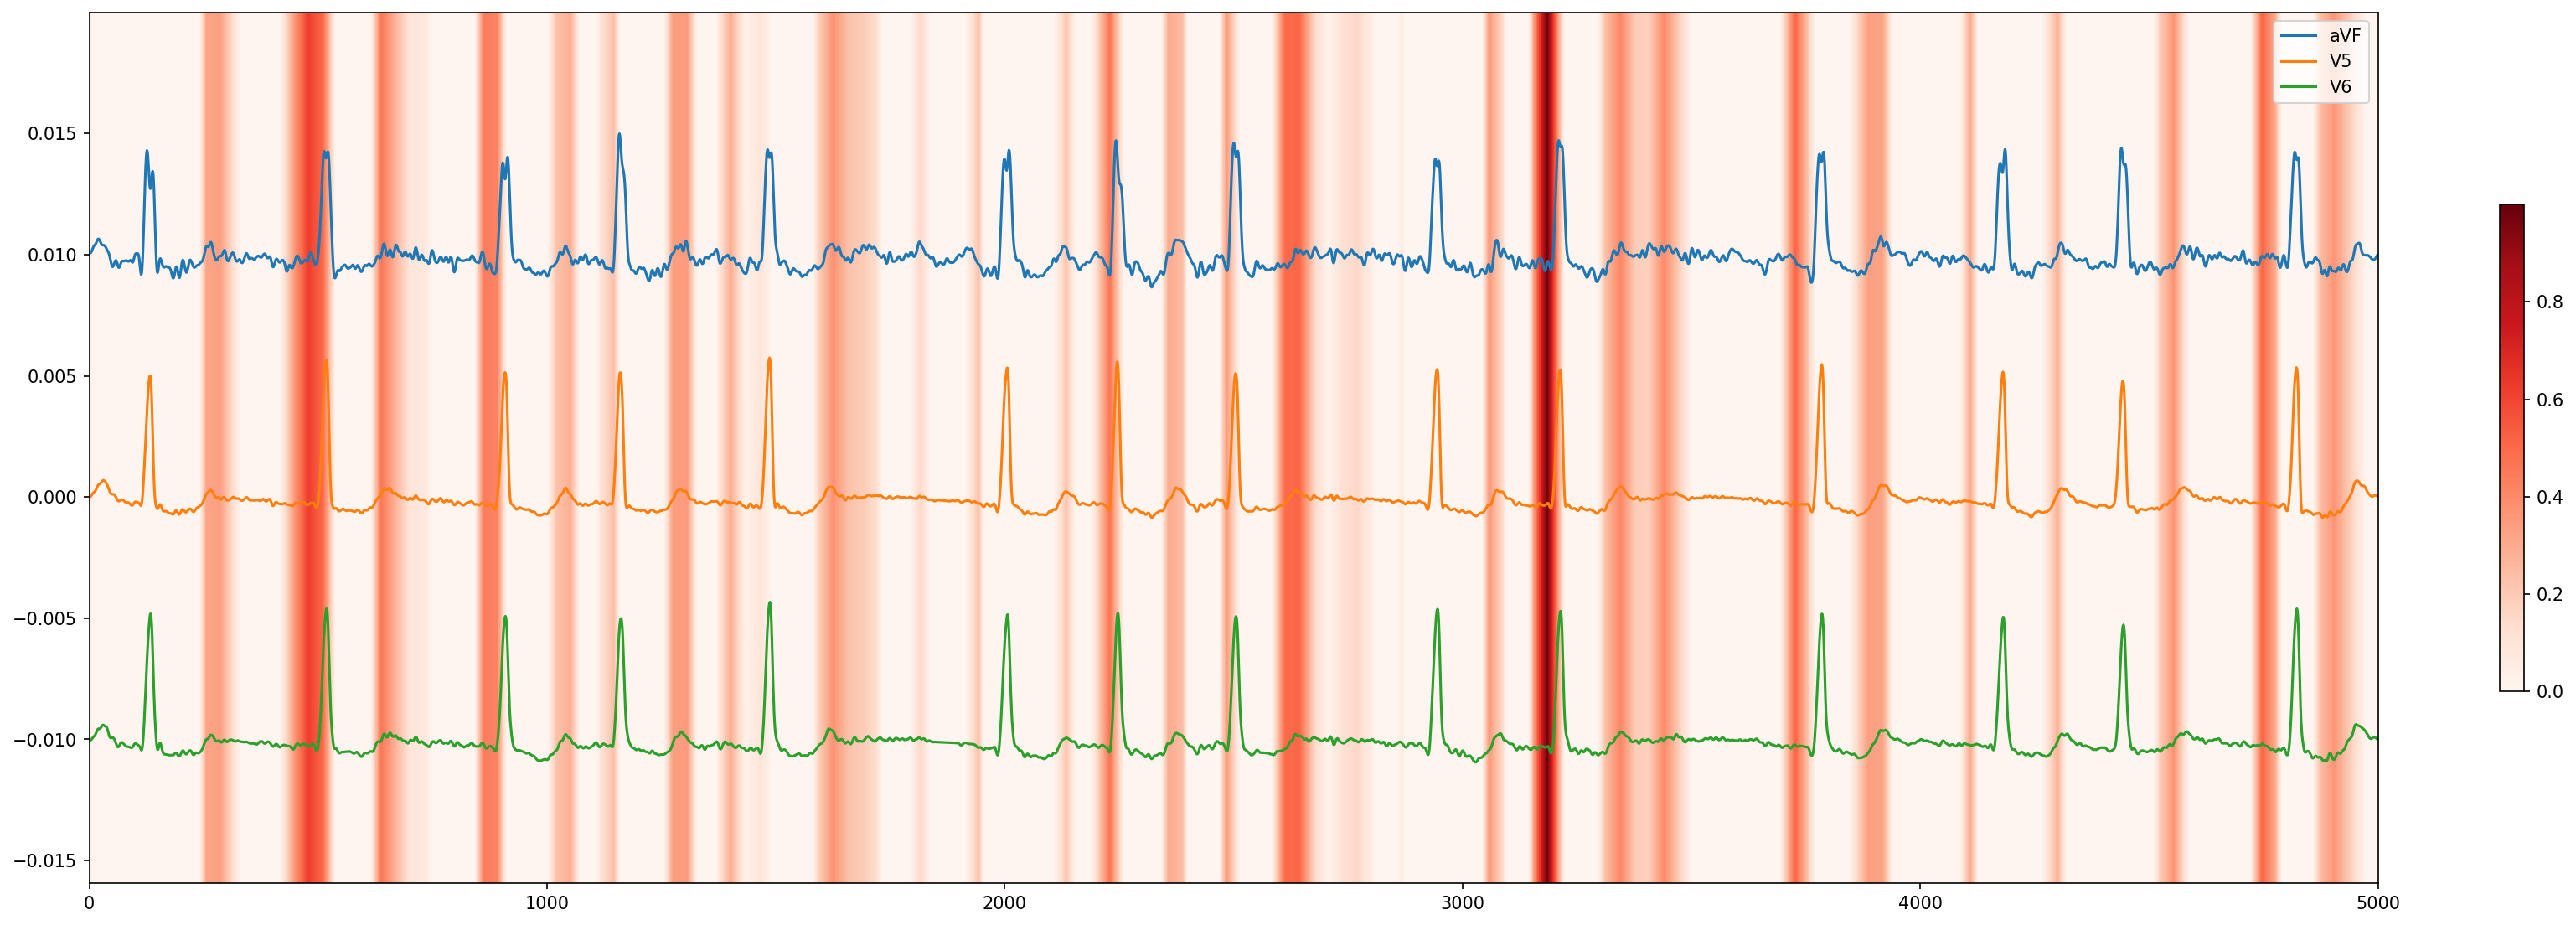

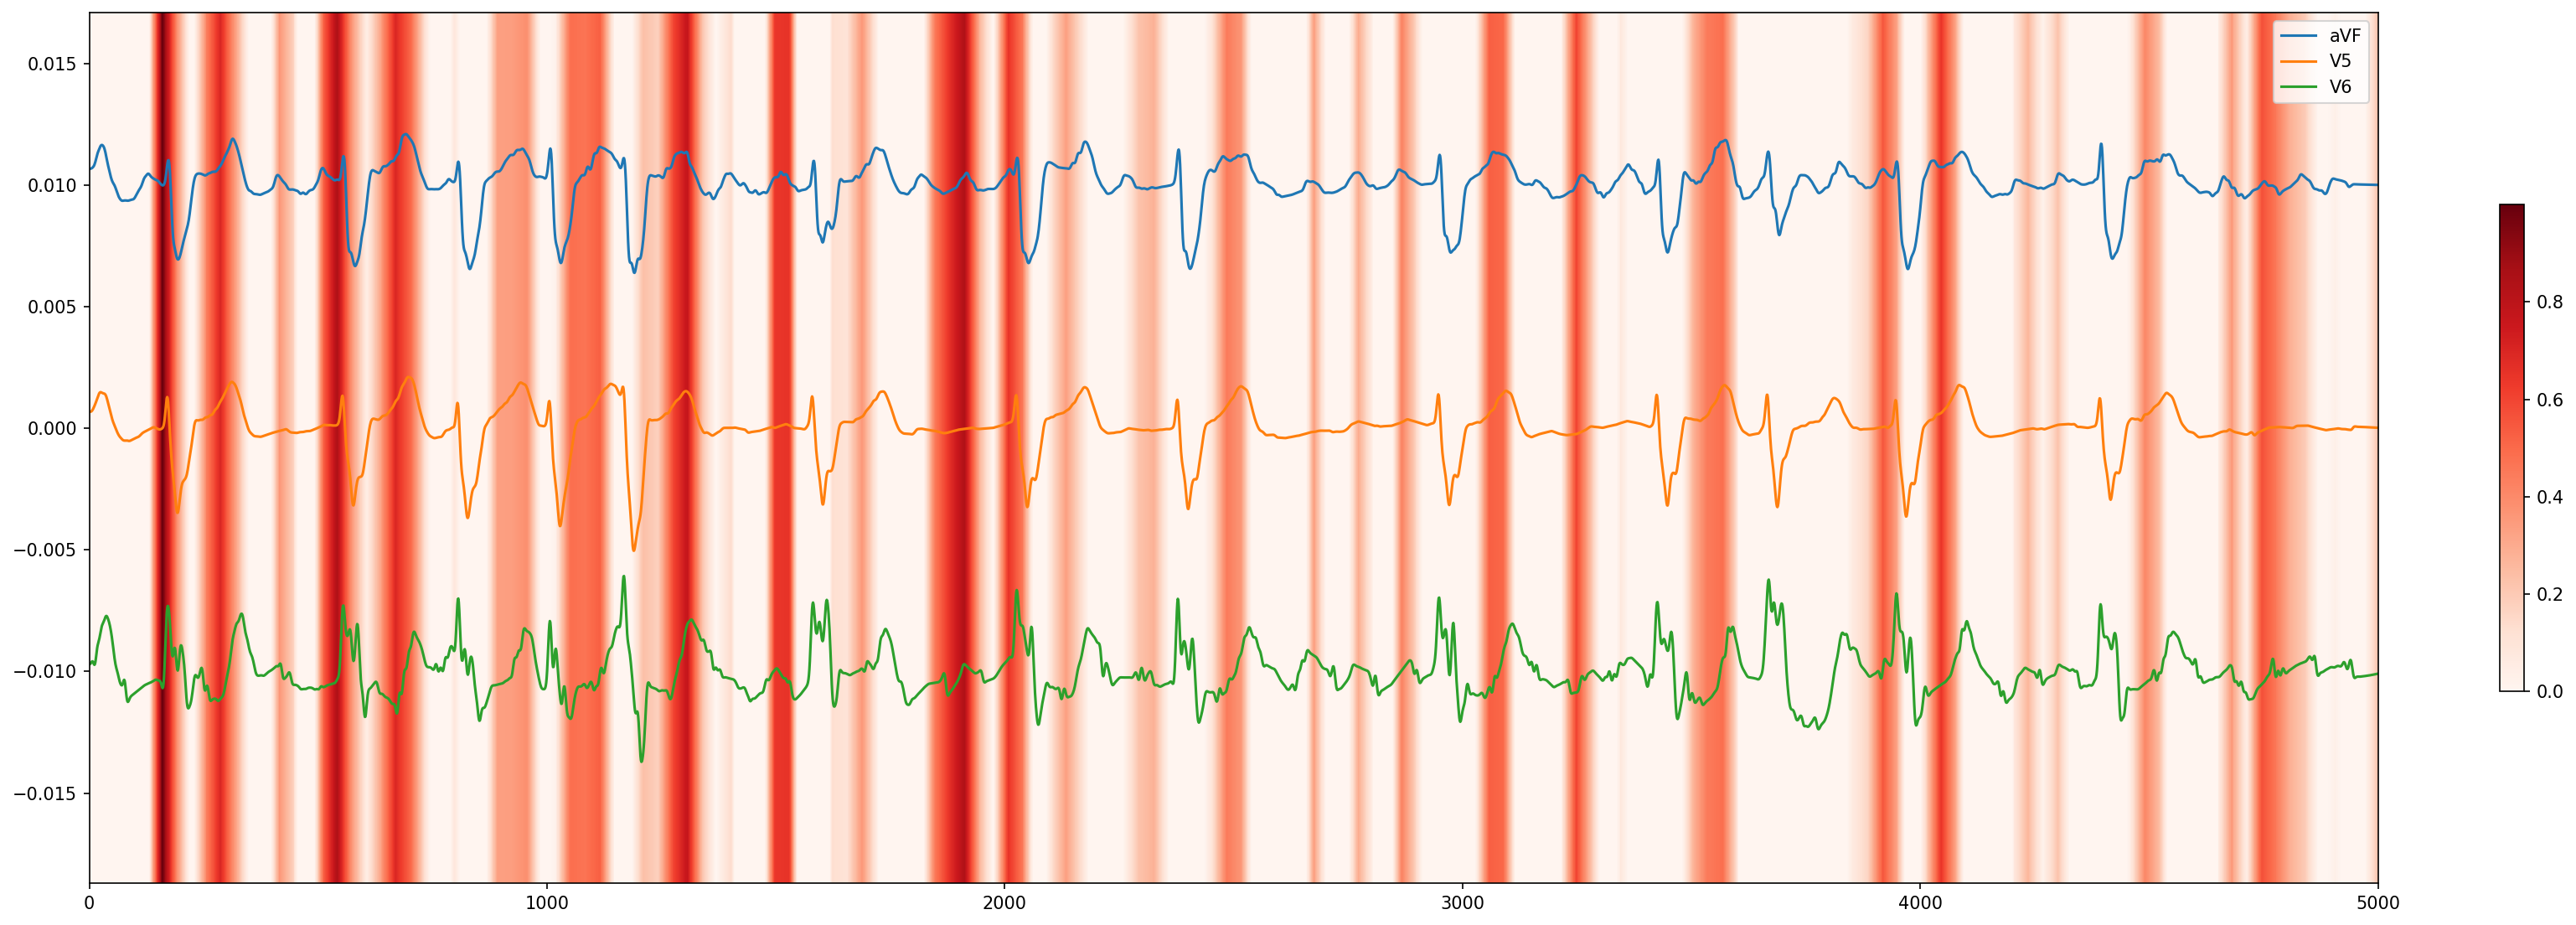

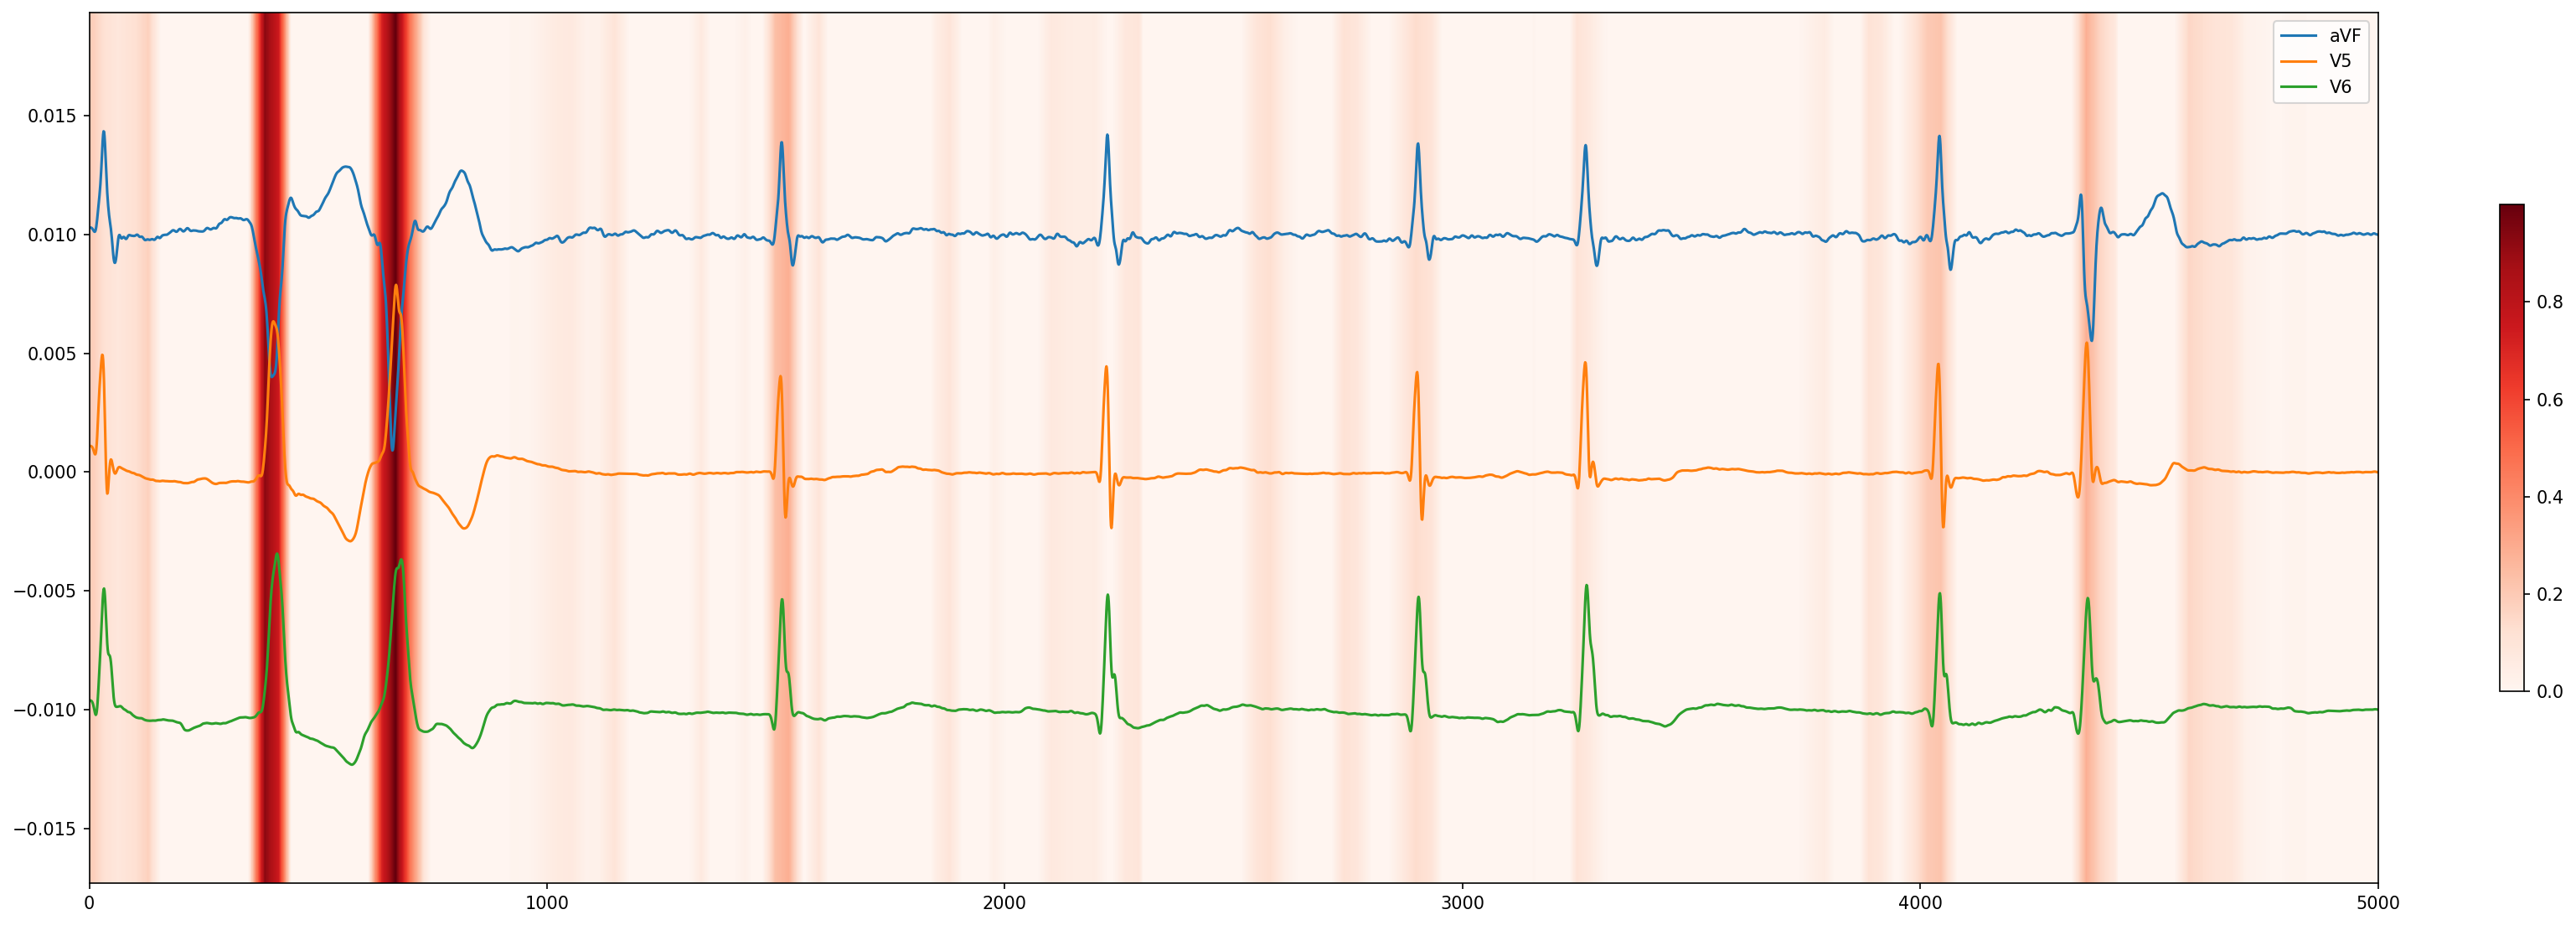

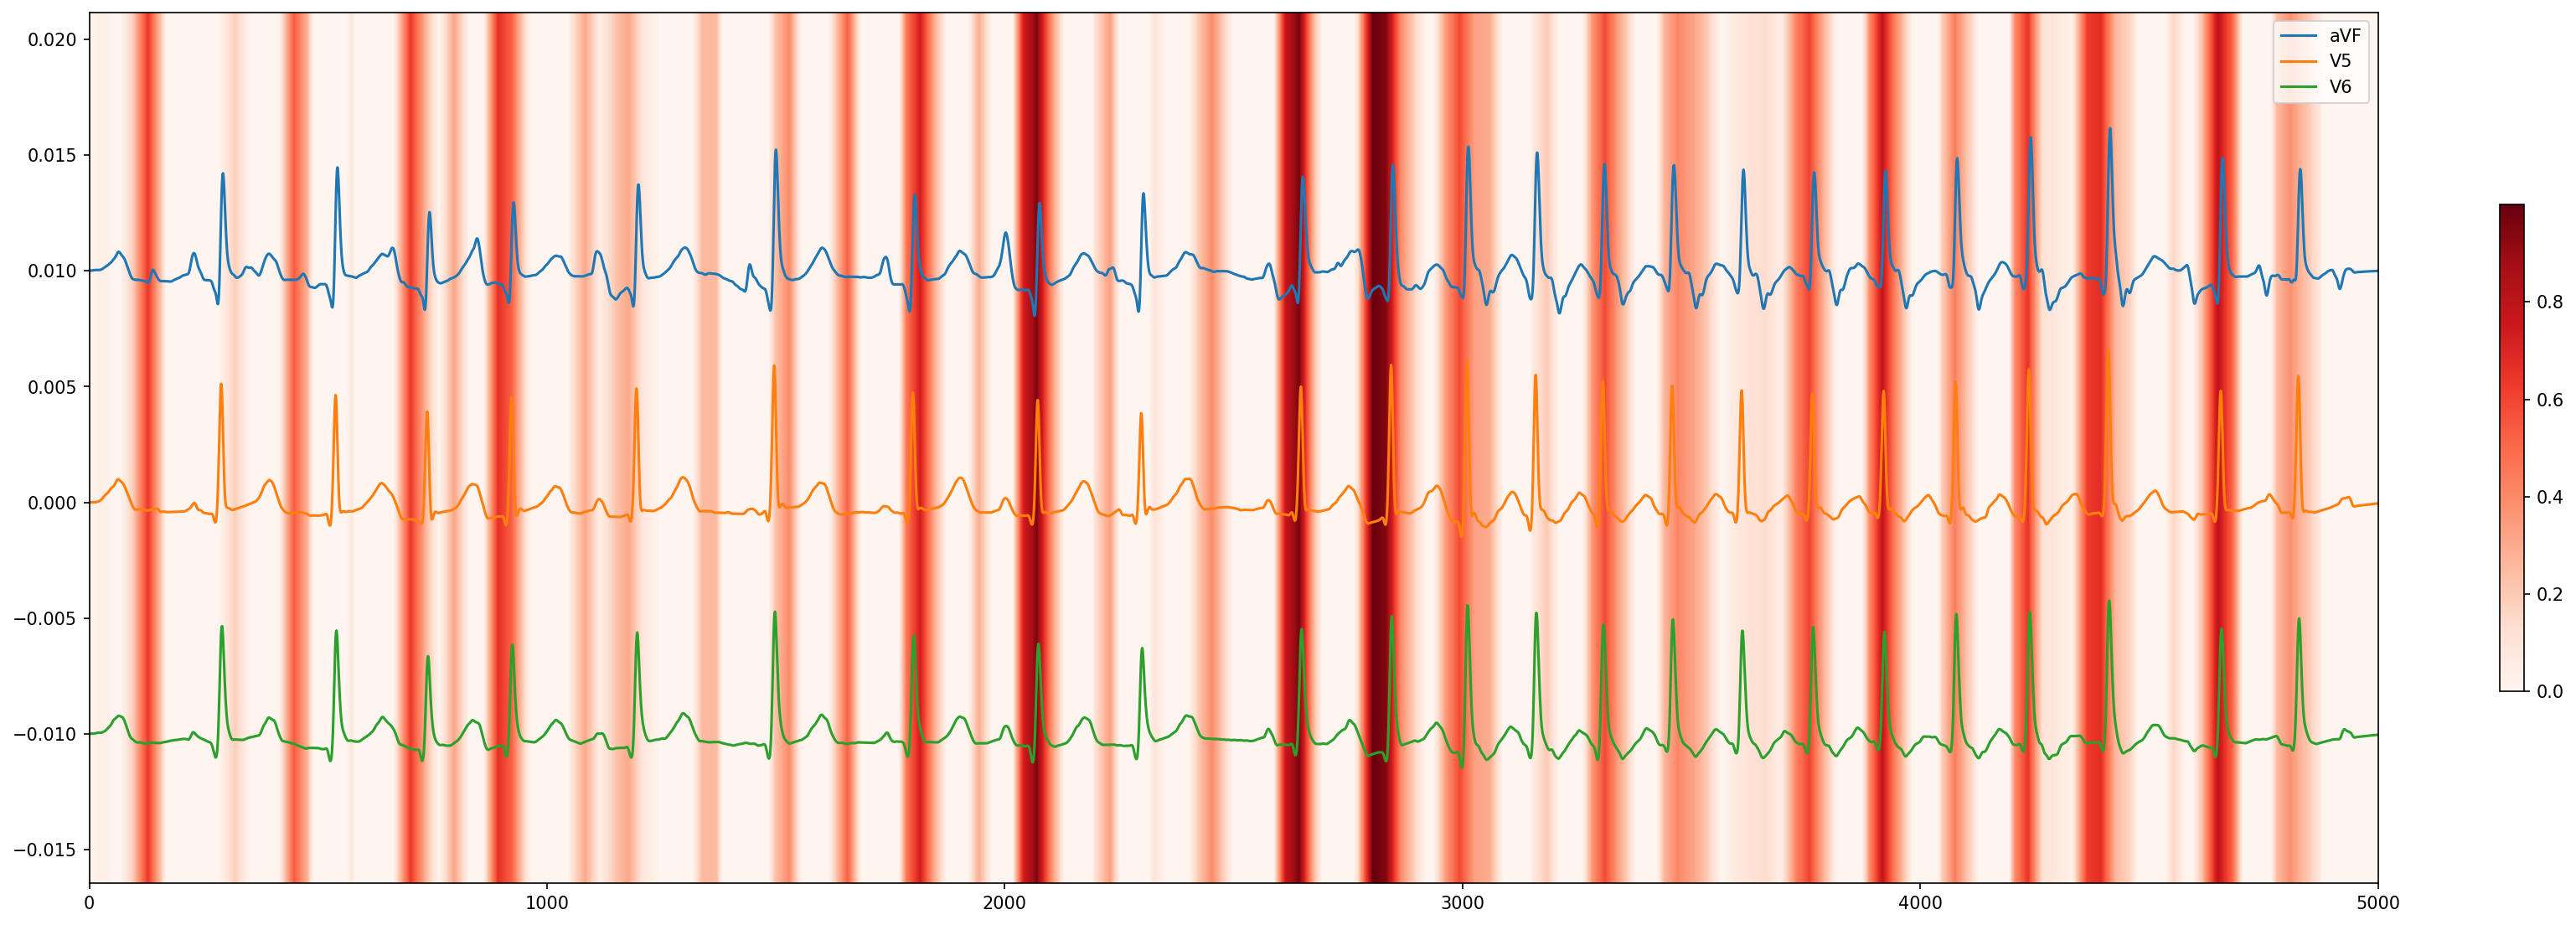

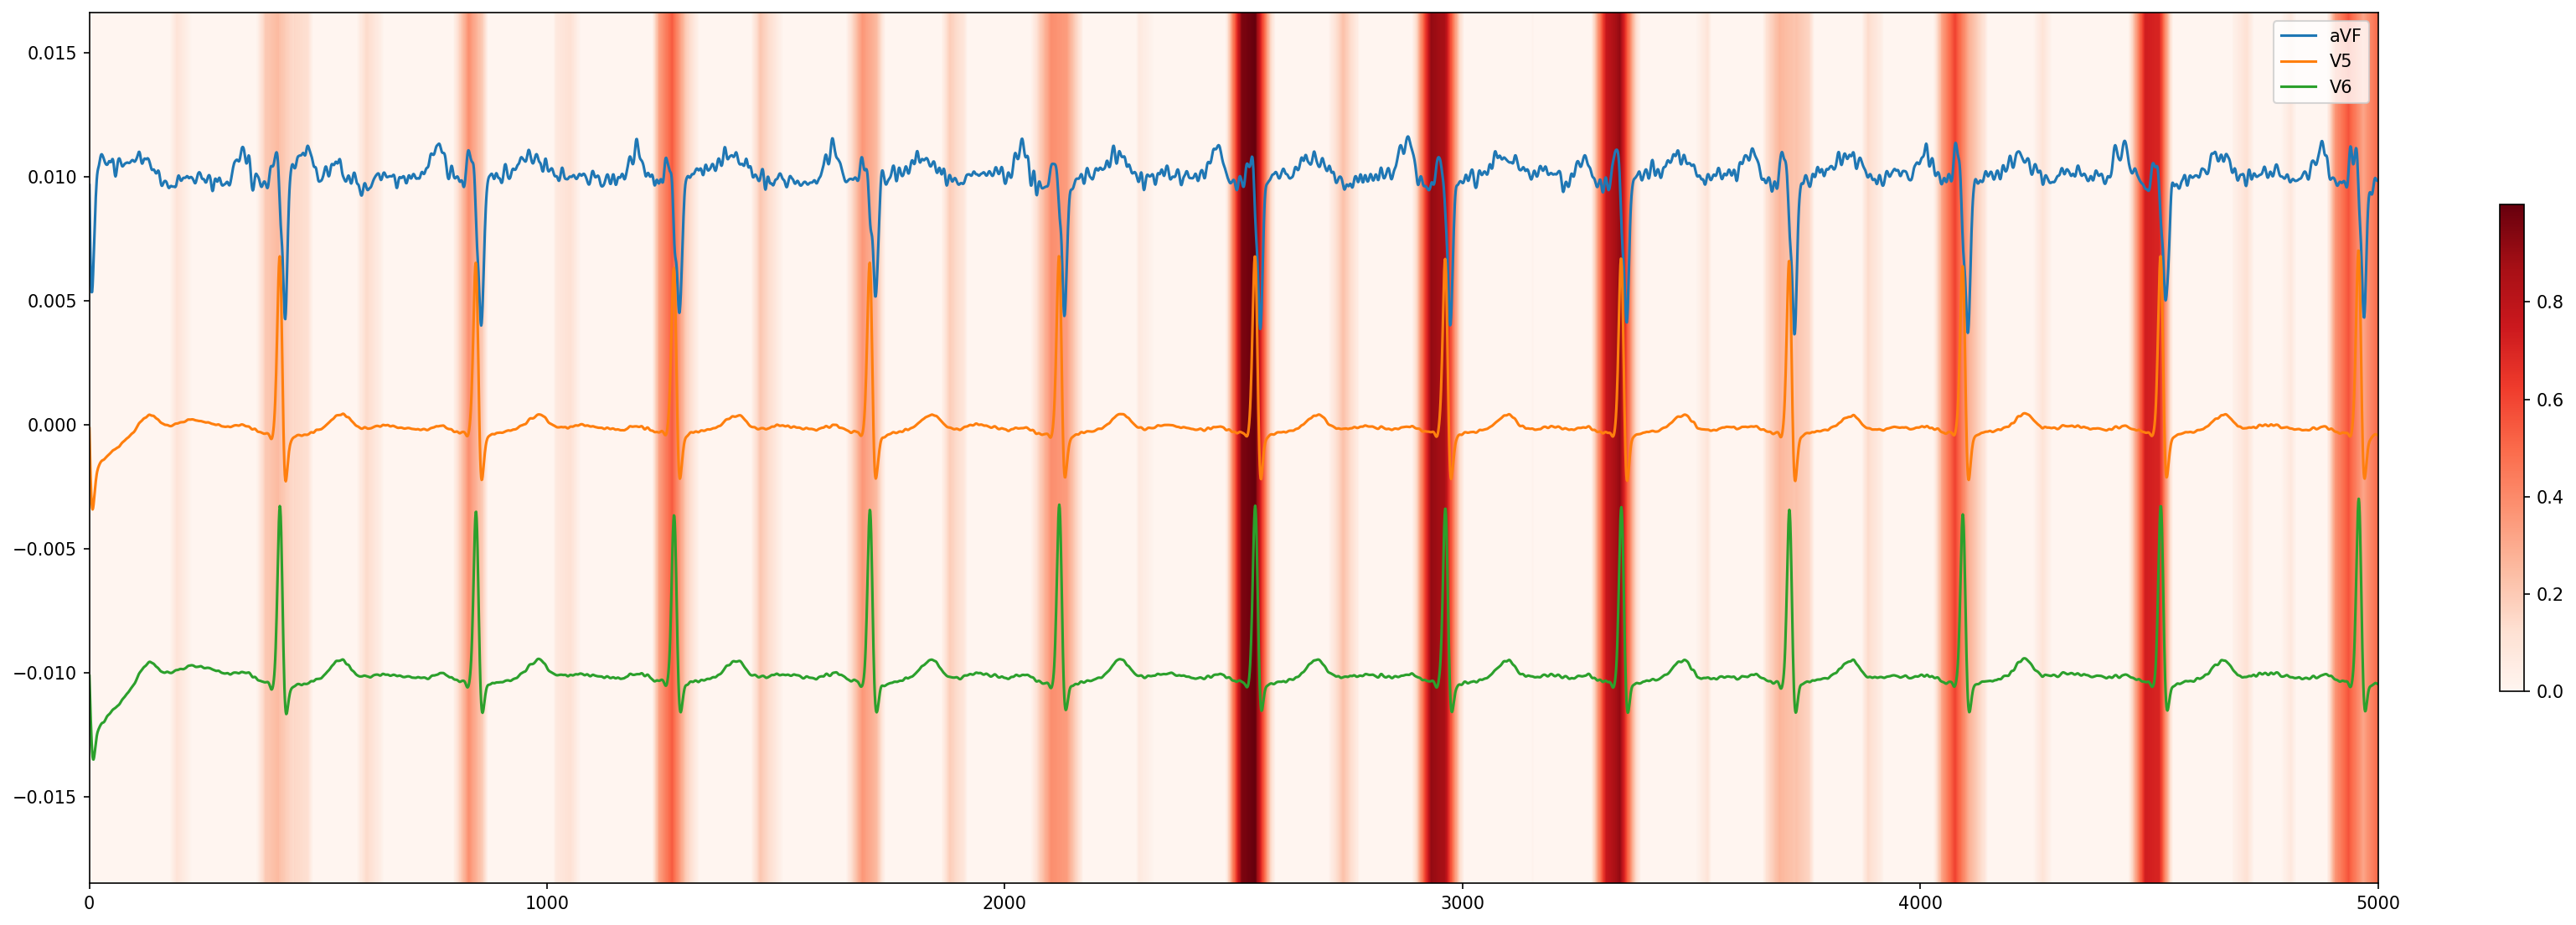

In [70]:
model = model_resnet31
target_layer = model.res_block3.conv3
net = GradCAM(model,target_layer)

x = np.arange(5000)
#hotmap = np.zeros((6,5000))
for i,file in enumerate(af_explain):
    fig,axs = plt.subplots(1,1,figsize=(25,9),dpi=150)
    ecg = torch.unsqueeze(prepare_input(file,three_leads).float().to(device),dim=0)
    #axs.set_title('label: %s, prediction: %s' %(classes[i//2],classes[i%2]))
    heatmap = draw_heatmap(ecg)
    #hotmap[i] = [1 if x>=0.6 else 0 for x in heatmap]
    plt.savefig('af_explain_%d.png'%(i+1))
    plt.show()

# Eval Explain

### Jaccard-1d : compare with shapelets

#### *step1: select and show out shapelets*

In [84]:
# select shapelet and visual :num_shapelets=10,windows=50
# initial shapelets_learner
size = len(test_result)
st_files = test_result.head(size)['filenames']
st_labels = test_result.head(size)['labels']
st_inputs = torch.stack([prepare_input(file,three_leads) for file in st_files]).float().to(device)
#(len(testset),3,5000)
st_outputs = torch.stack([torch.tensor(label) for label in st_labels]).to(device)

n_ts,n_channels,len_ts = st_inputs.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(st_outputs))
shapelets_size_and_len = {50:30}
dist_measure = 'euclidean'
lr=7e-3
wd=1e-3
epsilon=5e-7

learning_shapelets = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=True,verbose=1,dist_measure=dist_measure)

optimizer = optim.Adam(learning_shapelets.model.parameters(),lr=lr,weight_decay=wd,eps=epsilon)
learning_shapelets.set_optimizer(optimizer)

In [85]:
def sample_ts_segments(X,shapelets_size,n_segments=10000):
    n_ts,n_channels,len_ts = X.shape
    sample_i = random.choices(range(n_ts),k=n_segments)
    segments = np.empty((n_segments,n_channels,shapelets_size))
    for i,k in enumerate(sample_i):
        s = random.randint(0,len_ts-shapelets_size)
        segments[i] = X[k,:,s:s+shapelets_size]
    return segments

def get_weights_via_kmeans(X,shapelets_size,num_shapelets,n_segments=10000):
    X = X.cpu().numpy()
    segments = sample_ts_segments(X,shapelets_size,n_segments).transpose(0,2,1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets,metric='euclidean',max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0,2,1)
    return clusters

for i,(shapelets_size,num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(st_inputs,shapelets_size,num_shapelets)
    learning_shapelets.set_shapelet_weights_of_block(i,weights_block)

Loss: 0.6284850239753723: 100%|██████████| 2000/2000 [10:28<00:00,  3.18it/s]


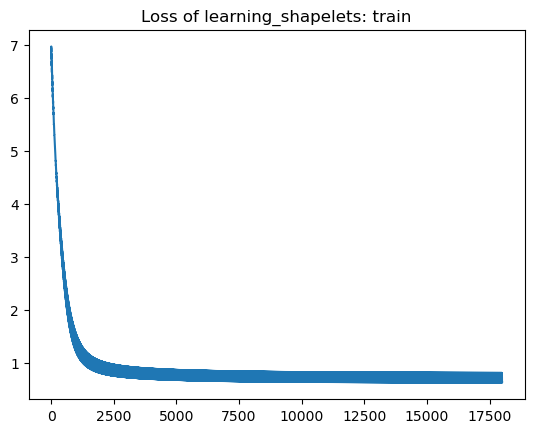

In [86]:
# train shapelets_learner
losses = learning_shapelets.fit(st_inputs,st_outputs,epochs=2000,batch_size=128,shuffle=False,drop_last=False)
plt.plot(losses)
plt.title('Loss of learning_shapelets: train')
plt.show()

In [50]:
# evalua shapelet-learn
results_st = learning_shapelets.predict(st_inputs)
preds_st = np.argmax(results_st,axis=1)
labels_st = np.array(st_labels)

cm_st = np.zeros((2,2))
for i,p in enumerate(preds_st):
    t = labels_st[i]
    cm_st[t,p] +=1

tp_st = cm_st[0,0].astype(float)
fn_st = cm_st[0,1].astype(float)
fp_st = cm_st[1,0].astype(float)
tn_st = cm_st[1,1].astype(float)

# recall (sensitivity)
recall_st = tp_st/(tp_st+fn_st)
print('Recall of shapelets-learner: ', recall_st)

# precision
precision_st = tp_st/(tp_st+fp_st)
print('\nPrecision of shapelets-learner: ', precision_st)

# F1
f1_st = 2*((precision_st*recall_st)/(precision_st+recall_st))
print('\nF1-score of shapelets-learner: ', f1_st)

Recall of shapelets-learner:  1.0

Precision of shapelets-learner:  0.5

F1-score of shapelets-learner:  0.6666666666666666
[[526.   0.]
 [526.   0.]]


In [87]:
def torch_dist_ts_shapelet(ts,shapelet,cuda=True):
    if not isinstance(ts,torch.Tensor):
        ts = torch.tensor(ts,dtype=torch.float)
    if not isinstance(shapelet,torch.Tensor):
        shapelet = torch.tensor(shapelet,dtype=torch.float)
    if cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    shapelet = torch.unsqueeze(shapelet,0)
    ts = ts.unfold(1,shapelet.shape[2],1)
    dists = torch.cdist(ts,shapelet,p=2)
    dists = torch.sum(dists,dim=0)
    d_min,d_argmin = torch.min(dists,0,keepdim=True)
    #print(d_min.shape)
    #print(d_argmin.cpu().numpy()[0])
    return (d_min.cpu().numpy()[0],d_argmin.cpu().numpy()[0])

def lead_pad_shapelet(shapelet,pos):
    pad = np.empty(pos)
    pad[:] = np.NaN
    padded_shapelet = np.concatenate([pad,shapelet])
    #print(padded_shapelet)
    return padded_shapelet

In [88]:
import matplotlib.colors as mcolors
def plot_shapelet(ecg_data,shapelet,leads):
    ecg_data = ecg_data.cpu().numpy()
    nleads = len(leads)
    nsteps = 5000
    x = range(nsteps)
    ecg_data = ecg_data[:,0:nsteps]
    colors = list(mcolors.CSS4_COLORS.values())
    # plt lead with n shapelet
    for i,lead in enumerate(leads):
        fig_lead = fig.add_subplot(gs[(5*i)+1:5*(i+1),:])
        fig_lead.plot(x,ecg_data[i])
        for j in range(shapelets.shape[0]):
            shapelet = shapelets[j]
            _,pos = torch_dist_ts_shapelet(ecg_data,shapelet)
            fig_lead.plot(lead_pad_shapelet(shapelet[i],pos[i]),color=colors[j],linewidth=3.0,alpha=0.8)
            # plt shapelets of each leads
            fig_st = fig.add_subplot(gs[5*i,j])
            fig_st.plot(range(len(shapelet[i])),shapelet[i],color=colors[-j])
            fig_st.set_title('%s-s%d'%(leads[i],j+1))
            fig_st.set_xlim((0,50))
            fig_st.set_xticks([])
            fig_st.set_yticks([])
        fig_lead.set_xlim((0,5000))
        #ax.set_xticks([0,5000])
        fig_lead.set_yticks([])
        fig_lead.set_ylabel(leads[i])
    plt.show()

(30, 3, 50)


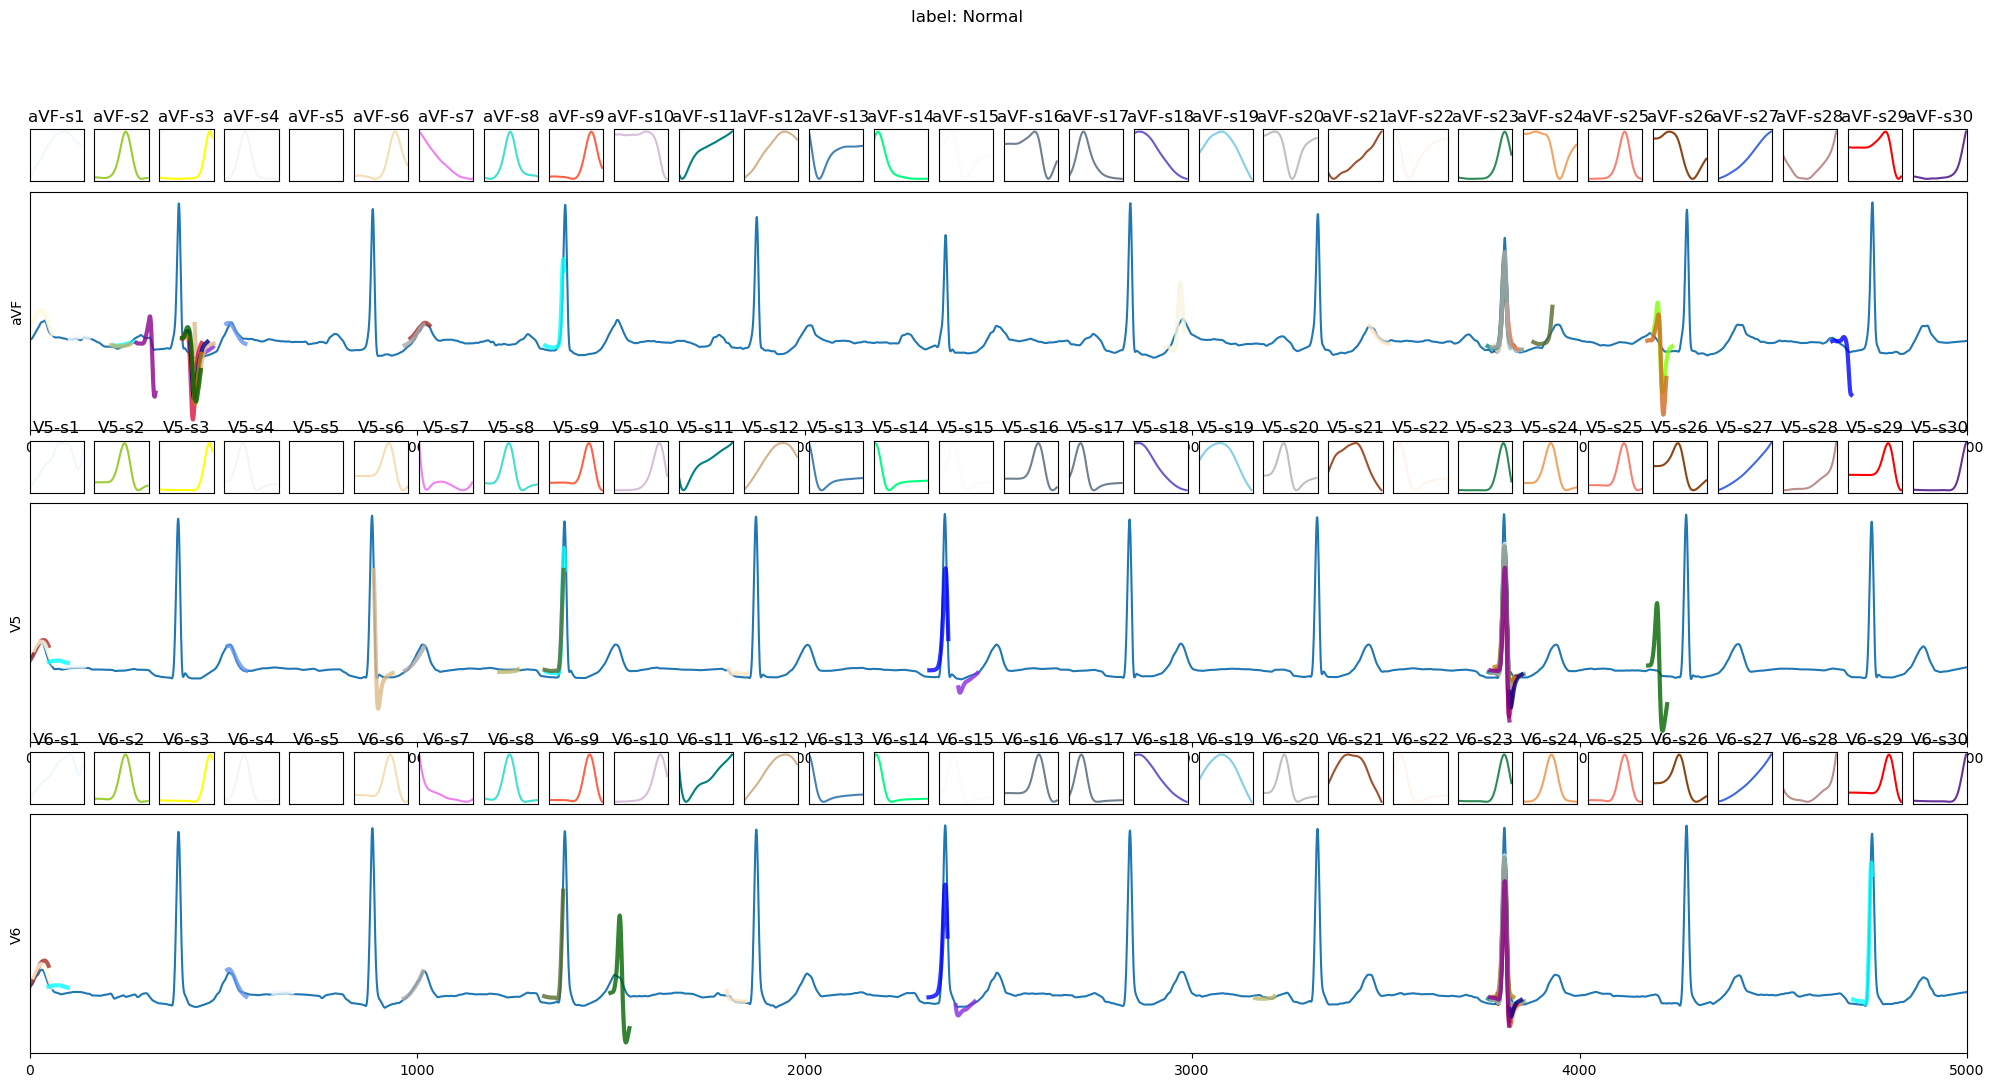

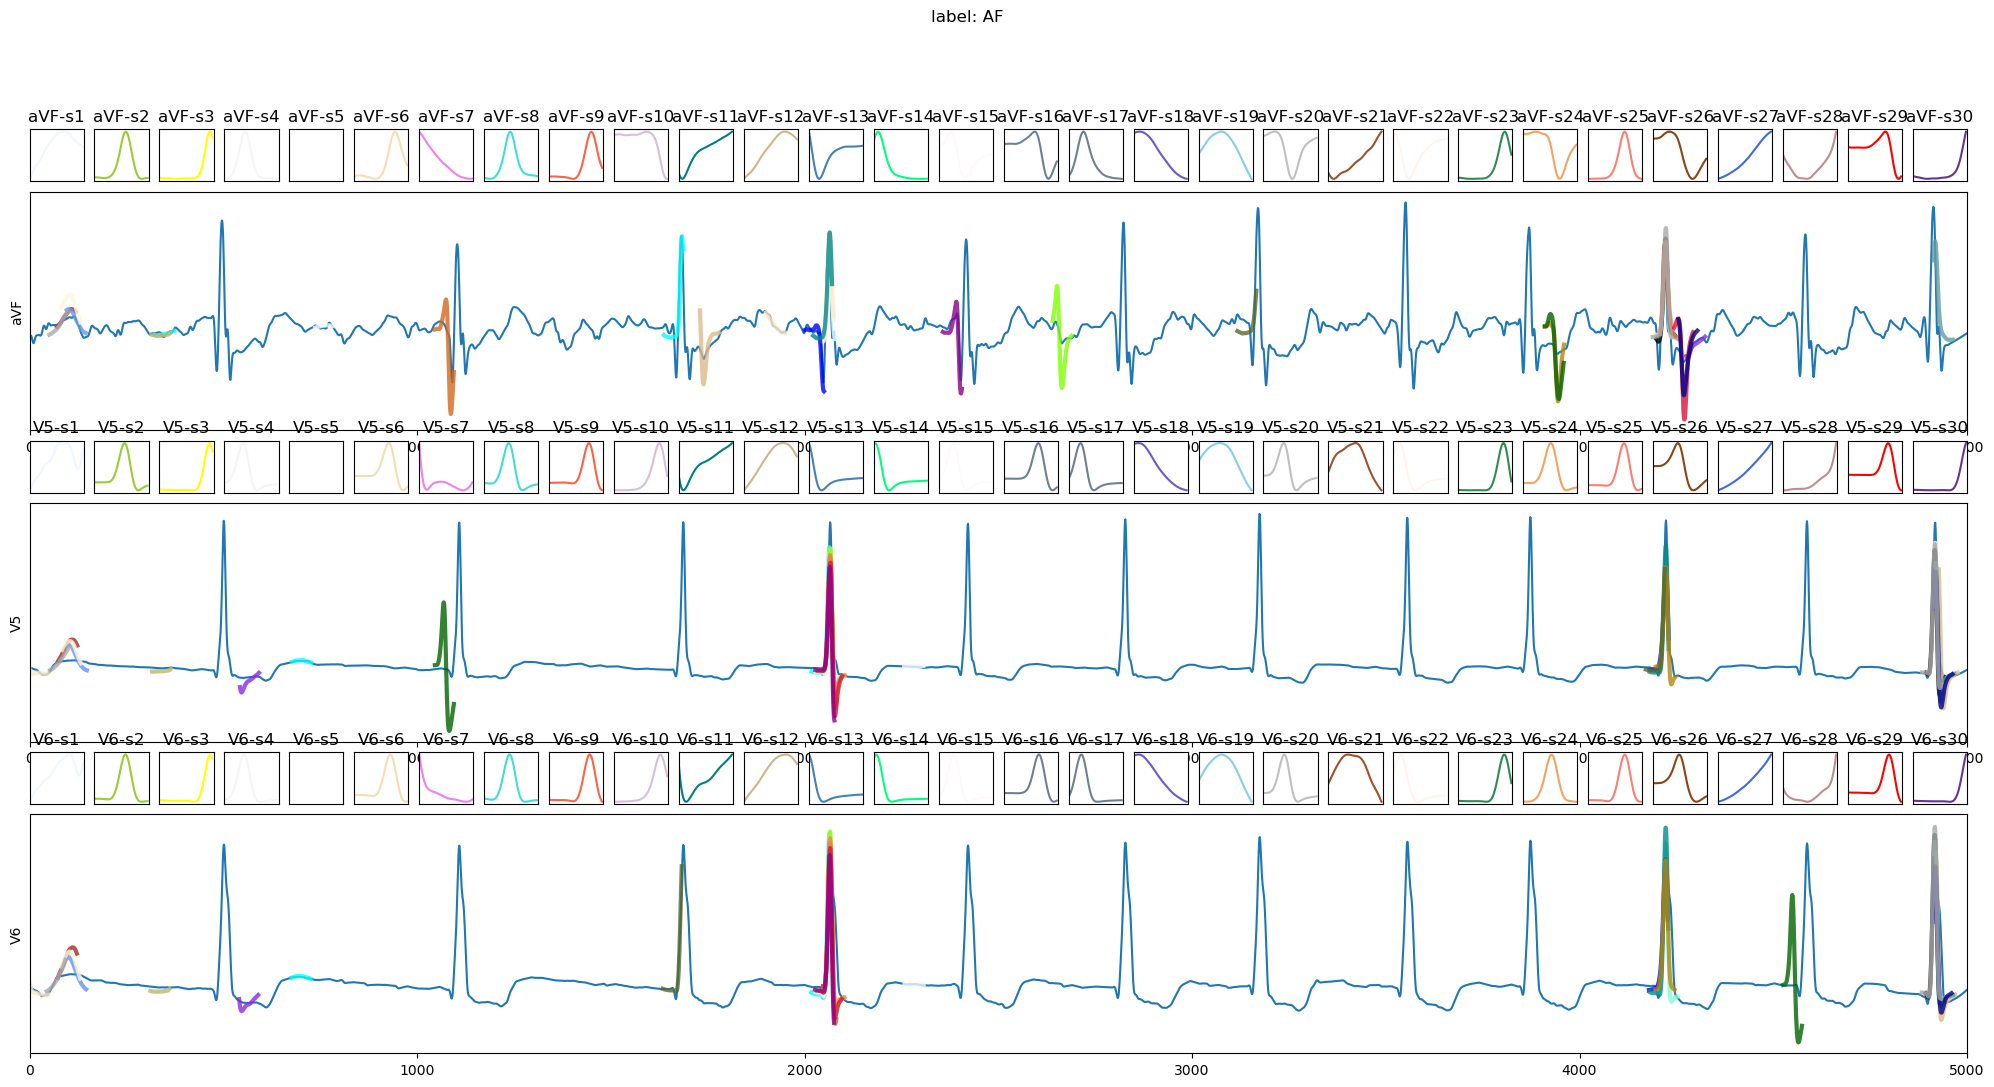

In [89]:
classes = ['Normal','AF']
shapelets = learning_shapelets.get_shapelets()
print(shapelets.shape)

for i,file in enumerate(to_explain):
    if i==0 or i==3:
        ecg = prepare_input(file,three_leads)
        fig = plt.figure(figsize=(25,12))
        gs = fig.add_gridspec(15,30)
        fig.suptitle('label: %s' %(classes[i//2]))
        plot_shapelet(ecg,shapelets,three_leads)

#### *step2: compare and compute J-1d: ∩/∪*

In [46]:
#explains relevant_part=1, other=0  -----> (5000,)
#shapelets shapelets_part=1, other=0 ------> (5000,)
#J above two array: every test_data --> every lead --> compute j
#J = mean(m_j+m_j+m_j -> all test_data's m_j) <-- m_j = mean(j+j+j -> add all leads' j)

In [90]:
#shapelets shapelets_part=1, other=0 ------> (5000,) --->(num_test,num_leads,5000)
nleads = len(three_leads)
# use to compare with Grad-CAM ---->(num_test,5000)
shapelets_part_hotmap_GC = np.zeros((len(st_inputs),5000),dtype=int)
#print(shapelets_part_hotmap_GC.shape)
for i,ecg in enumerate(st_inputs):
    ecg = ecg.cpu().numpy()
    ecg_hotmap = np.zeros(5000,dtype=int)
    for j in range(nleads):
        lead_hotmap = np.zeros(5000 ,dtype=int)
        for s in range(shapelets.shape[0]):
            shapelet = shapelets[s]
            _,pos = torch_dist_ts_shapelet(ecg,shapelet)
            padded_shapelet = lead_pad_shapelet(shapelet[j],pos[j])
            shapelet_hotmap_tmp = [0 if math.isnan(x) else 1 for x in padded_shapelet]
            shapelet_hotmap = shapelet_hotmap_tmp +[0]*(5000-len(shapelet_hotmap_tmp))
            lead_hotmap = np.logical_or(lead_hotmap, shapelet_hotmap)
        ecg_hotmap = np.logical_or(ecg_hotmap, lead_hotmap)
    shapelets_part_hotmap_GC[i] = ecg_hotmap.astype(int)

# use to compare with SHAP and LIME ---->(num_test,num_leads,5000)
shapelets_part_hotmap_SL = np.zeros((len(st_inputs),nleads,5000),dtype=int)
for i,ecg in enumerate(st_inputs):
    ecg = ecg.cpu().numpy()
    ecg_hotmap = np.zeros((nleads,5000))
    for j in range(nleads):
        lead_hotmap = np.zeros(5000 ,dtype=int)
        for s in range(shapelets.shape[0]):
            shapelet = shapelets[s]
            _,pos = torch_dist_ts_shapelet(ecg,shapelet)
            padded_shapelet = lead_pad_shapelet(shapelet[j],pos[j])
            shapelet_hotmap_tmp = [0 if math.isnan(x) else 1 for x in padded_shapelet]
            shapelet_hotmap = shapelet_hotmap_tmp +[0]*(5000-len(shapelet_hotmap_tmp))
            lead_hotmap = np.logical_or(lead_hotmap, shapelet_hotmap)
        ecg_hotmap[j] = lead_hotmap.astype(int)
    shapelets_part_hotmap_SL[i] = ecg_hotmap
print(shapelets_part_hotmap_GC.shape)
print(shapelets_part_hotmap_SL.shape)

(1052, 5000)
(1052, 3, 5000)


In [91]:
#hotmap for explain_methods(grad-cam,shap,lime)
threshold = 0.6

classes = ['Normal','AF']
#Grad-CAM
model = model_resnet31
target_layer = model.res_block3.conv3
net = GradCAM(model,target_layer)

#SHAP
background = 300
background_files = test_df.head(background)['filenames']
background_inputs = torch.stack([prepare_input(file,three_leads) for file in background_files]).float().to(device)
e_shap = shap.GradientExplainer(model,background_inputs)

#LIME
e_lime = LimeTimeSeriesExplainer(class_names=['0','1'],signal_names=three_leads)

hotmap_gc = np.zeros((len(test_result),5000),dtype=int)
svs = []
hotmap_lime = np.zeros((len(test_result),3,5000),dtype=int)
for i,file in enumerate(test_result['filenames']):
    ecg = prepare_input(file,three_leads)
    ecg_cuda = torch.unsqueeze(prepare_input(file,three_leads).float().to(device),dim=0)
    #Grad-CAM_hot
    grad_1ecg = net(ecg_cuda)
    hotmap_1ecg = [1 if x>=threshold else 0 for x in grad_1ecg]
    hotmap_gc[i] = hotmap_1ecg
    #SHAP_svs
    sv = np.array(e_shap.shap_values(ecg_cuda))
    svs.append(sv)
    #LIME_hot
    exp = e_lime.explain_instance(ecg,limepred,num_features=50,num_samples=500,num_slices=100,replacement_method='noise')
    explainations = exp.as_list()
    hmap_lime = np.zeros((3,5000))
    slice_len = int(math.ceil(ecg.shape[1]/100))
    for k in explainations:
        start_idx = int(k[0].split('-')[0])*slice_len
        end_idx = start_idx+slice_len
        if k[0].split('-')[1]=='aVF':
            hmap_lime[0][start_idx:end_idx]=k[1]* np.ones(slice_len)
        elif k[0].split('-')[1]=='V5':
            hmap_lime[1][start_idx:end_idx]=k[1]* np.ones(slice_len)
        elif k[0].split('-')[1]=='V6':
            hmap_lime[2][start_idx:end_idx]=k[1]* np.ones(slice_len)
    hmap_lime = np.maximum(hmap_lime,0)
    lime_min = np.min(hmap_lime,axis=1,keepdims=True)
    lime_max = np.max(hmap_lime,axis=1,keepdims=True)
    lime_heatmap = (hmap_lime-lime_min)/(lime_max-lime_min+1e-10)
    hotmap_1lime = np.zeros((3,5000))
    hotmap_1lime = np.where(lime_heatmap < threshold, 0, 1)
    hotmap_lime[i] = hotmap_1lime

#SHAP_hot
svs = np.concatenate(svs,axis=1)
hotmap_shap = np.zeros((len(test_result),3,5000),dtype=int)
for i,file in enumerate(test_result['filenames']):
    label_idx = test_result['preds'][i]
    sv_data = svs[label_idx,i]
    hmap_shap = np.maximum(sv_data,0)
    shap_min = np.min(hmap_shap,axis=1,keepdims=True)
    shap_max = np.max(hmap_shap,axis=1,keepdims=True)
    shap_heatmap = (hmap_shap-shap_min)/(shap_max-shap_min+1e-10)
    slice_len = 50
    slice_num = 5000 //slice_len
    for h in range(shap_heatmap.shape[0]):
        for j in range(slice_num):
            start = j*slice_len
            end = (j+1)*slice_len
            sh_mean = np.mean(shap_heatmap[h][start:end])
            shap_heatmap[h][start:end]=sh_mean
    hotmap_1shap = np.where(shap_heatmap < threshold, 0, 1)
    hotmap_shap[i] = hotmap_1shap

print(hotmap_gc.shape)
print(hotmap_shap.shape)
print(hotmap_lime.shape)

(1052, 5000)
(1052, 3, 5000)
(1052, 3, 5000)


In [92]:
# J-1d of Grad-CAM : Grad-CAM -> all leads use same heatmap
#GC relevant_part=1, other=0  -----> (5000,) --->(num_test,5000)
# compute J-1d
jaccard_gc_list = []
for i in range(hotmap_gc.shape[0]):
    gc = hotmap_gc[i]
    shapelet_part_gc = shapelets_part_hotmap_GC[i]
    gc_arr = np.array(gc)
    stgc_arr = np.array(shapelet_part_gc)
    
    both_ones = np.logical_and(gc_arr == 1, stgc_arr == 1)
    j_gc = np.sum(both_ones) / np.sum(np.logical_or(gc_arr == 1, stgc_arr == 1))
    jaccard_gc_list.append(j_gc)
jaccard_gc = np.mean(jaccard_gc_list)
print('Jaccard-1d of Grad-CAM: ',jaccard_gc)

Jaccard-1d of Grad-CAM:  0.06298893629705742


In [93]:
# compute J-1d ： for shap and lime(dim=3)
def Jaccard_1d_3(hotmap_xai,hotmap_shapelet):
    jaccard_list = []
    for i in range(hotmap_xai.shape[0]):
        xai1 = hotmap_xai[i]
        shapelet_part1 = hotmap_shapelet[i]
    
        jaccard1_list = []
        for j in range(xai1.shape[0]):
            xai = xai1[j]
            shapelet_part = shapelet_part1[j]
        
            xai_arr = np.array(xai)
            st_arr = np.array(shapelet_part)
            both_ones = np.logical_and(xai_arr == 1, st_arr == 1)
            j = np.sum(both_ones) / np.sum(np.logical_or(xai_arr == 1, st_arr == 1))
            jaccard1_list.append(j)
        jaccard1 = np.mean(jaccard1_list)
        jaccard_list.append(jaccard1)
    jaccard = np.mean(jaccard_list)
    return jaccard

In [ ]:
# J-1d of SHAP -----> mean leads ---> mean all
#SHAP relevant_part=1, other=0  -----> (5000,) --->(num_test,num_leads,5000)    
# compute J-1d
jaccard_shap = Jaccard_1d_3(hotmap_shap,shapelets_part_hotmap_SL)
print('Jaccard-1d of SHAP: ',jaccard_shap)

In [95]:
# J-1d of LIME -----> mean leads ---> mean all
#LIME relevant_part=1, other=0  -----> (5000,) --->(num_test,num_leads,5000)
#compute J-1d
jaccard_lime = Jaccard_1d_3(hotmap_lime,shapelets_part_hotmap_SL)
print('Jaccard-1d of LIME: ',jaccard_lime)

Jaccard-1d of LIME:  0.02447861917953125


### Give some noise to most_relevant part compare model_performance ----- noise:random

In [96]:
def perturb_random(ecg,hotmap):
    out = np.copy(ecg)
    if len(hotmap.shape)==1:
        for i in range(ecg.shape[0]):
            noise = np.random.uniform(ecg[i].min(),ecg[i].max(),ecg[i].shape)
            out[i][hotmap==1] = noise[hotmap==1]
    elif len(hotmap.shape)==len(ecg.shape):
        for i in range(ecg.shape[0]):
            noise = np.random.uniform(ecg[i].min(),ecg[i].max(),ecg[i].shape)
            out[i][hotmap[i]==1] = noise[hotmap[i]==1] 
    return out

def perturb_mean(ecg,hotmap):
    out = np.copy(ecg)
    if len(hotmap.shape)==1:
        for i in range(ecg.shape[0]):
            mean = np.sum(ecg[i]*hotmap)/np.sum(hotmap)
            out[i][hotmap==1] = mean
    elif len(hotmap.shape) == len(ecg.shape):
        mean = np.sum(ecg*hotmap,axis=1)/np.sum(hotmap,axis=1)
        for i in range(ecg.shape[0]):
            out[i][hotmap[i]==1] = mean[i]
    return out

def perturb_inverse(ecg,hotmap):
    out = np.copy(ecg)
    if len(hotmap.shape)==1:
        for i in range(ecg.shape[0]):
            start_idx=0
            while start_idx<ecg.shape[1]:
                if hotmap[start_idx]==1:
                    end_idx = start_idx+1
                    while end_idx<ecg.shape[1] and hotmap[end_idx]==1:
                        end_idx+=1
                    out[i,start_idx:end_idx] = np.flip(out[i,start_idx:end_idx])
                    start_idx=end_idx
                else:
                    start_idx +=1
                
    elif len(hotmap.shape)==len(ecg.shape):
        for i in range(ecg.shape[0]):
            start_idx=0
            while start_idx<ecg.shape[1]:
                if hotmap[i,start_idx]==1:
                    end_idx = start_idx+1
                    while end_idx<ecg.shape[1] and hotmap[i,end_idx]==1:
                        end_idx +=1
                    out[i,start_idx:end_idx] = np.flip(out[i,start_idx:end_idx])
                    start_idx = end_idx
                else:
                    start_idx +=1
    return out

In [97]:
from torch.utils import data
labels_integer = {'Normal':0, 'AF':1}
class ECGDataset_perturb(data.Dataset):
    def __init__(self,df,leads,hotmap,perturb_method,max_len=5000):
        self.df = df
        self.max_len = max_len
        self.leads = leads
        self.hotmap = hotmap
        self.perturb = perturb_method
        
    def __getitem__(self,index):
        data,header = load_data(self.df['filenames'][index])
        init_ecg_data = choose_leads(data,header,self.leads)
        label = torch.tensor(labels_integer[self.df['label'][index]])
        
        #data preprocess
        psc_ecg_data = resample(header,init_ecg_data)
        psc_ecg_data = filt(psc_ecg_data)
        psc_ecg_data = norm(psc_ecg_data)
        adc_gains = get_adc_gains(header,self.leads)
        baselines = get_baselines(header,self.leads)
        for i in range(len(self.leads)):
            psc_ecg_data[i,:] = (psc_ecg_data[i,:]-baselines[i])/adc_gains[i]
        
        # <max_len --> pad 0 /// >max_len ---> select 0:max_len
        if psc_ecg_data.shape[1]>=self.max_len:
            ecg_data = psc_ecg_data[:,0:self.max_len]
        elif psc_ecg_data.shape[1]<self.max_len:
            pad = self.max_len-psc_ecg_data.shape[1]
            ecg_data = np.hstack((psc_ecg_data, np.zeros((psc_ecg_data.shape[0], pad))))
            
        #perturb_choice
        if self.perturb =='random':
            ecg_per = torch.tensor(perturb_random(ecg_data,self.hotmap[index]))
        elif self.perturb == 'mean':
            ecg_per = torch.tensor(perturb_mean(ecg_data,self.hotmap[index]))
        elif self.perturb =='inverse':
            ecg_per = torch.tensor(perturb_inverse(ecg_data,self.hotmap[index]))
        
        return ecg_per,label
        
    def __len__(self):
        return len(self.df)

In [98]:
# random
random_gc = ECGDataset_perturb(test_df,three_leads,hotmap=hotmap_gc,perturb_method='random')
random_shap = ECGDataset_perturb(test_df,three_leads,hotmap=hotmap_shap,perturb_method='random')
random_lime = ECGDataset_perturb(test_df,three_leads,hotmap=hotmap_lime,perturb_method='random')

random_gc_loader = data.DataLoader(random_gc,batch_size=1,shuffle=False)
random_shap_loader = data.DataLoader(random_shap,batch_size=1,shuffle=False)
random_lime_loader = data.DataLoader(random_lime,batch_size=1,shuffle=False)

#mean
mean_gc = ECGDataset_perturb(test_df,three_leads,hotmap=hotmap_gc,perturb_method='mean')
mean_shap = ECGDataset_perturb(test_df,three_leads,hotmap=hotmap_shap,perturb_method='mean')
mean_lime = ECGDataset_perturb(test_df,three_leads,hotmap=hotmap_lime,perturb_method='mean')

mean_gc_loader = data.DataLoader(mean_gc,batch_size=1,shuffle=False)
mean_shap_loader = data.DataLoader(mean_shap,batch_size=1,shuffle=False)
mean_lime_loader = data.DataLoader(mean_lime,batch_size=1,shuffle=False)

#inverse
inverse_gc = ECGDataset_perturb(test_df,three_leads,hotmap=hotmap_gc,perturb_method='inverse')
inverse_shap = ECGDataset_perturb(test_df,three_leads,hotmap=hotmap_shap,perturb_method='inverse')
inverse_lime = ECGDataset_perturb(test_df,three_leads,hotmap=hotmap_lime,perturb_method='inverse')

inverse_gc_loader = data.DataLoader(inverse_gc,batch_size=1,shuffle=False)
inverse_shap_loader = data.DataLoader(inverse_shap,batch_size=1,shuffle=False)
inverse_lime_loader = data.DataLoader(inverse_lime,batch_size=1,shuffle=False)

In [99]:
# cm
class_num = 2
classes = ['AF','Normal']
def confusion_matrix1(preds,labels,cm):
    _,preds = torch.max(preds.data,1)
    labelc = [0 if label==1 else 1 for label in labels]
    predc = [0 if pred==1 else 1 for pred in preds]
    for t,p in zip(labelc,predc):
        cm[t,p] +=1
    return cm

def get_cm1(dataloader,model):
    cm = torch.zeros(class_num,class_num)
    with torch.no_grad():
        for data in dataloader:
            ecg,labels = data
            ecg = ecg.float().to(device)
            labels = labels.to(device)
            preds = model(ecg)
            cm = confusion_matrix1(preds,labels,cm)
            cm = cm.cpu()
    cm = np.array(cm.cpu())
    #cm_p = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    return cm

def get_perform(dataloader,model):
    cm = get_cm1(dataloader,model)
    
    tp = cm[0,0].astype(float)
    fn = cm[0,1].astype(float)
    fp = cm[1,0].astype(float)
    tn = cm[1,1].astype(float)

    #ACC
    acc = (tp+tn)/(tp+fn+fp+tn)

    # recall (sensitivity)
    recall = tp/(tp+fn)

    # precision
    precision = tp/(tp+fp)

    # F1
    f1 = 2*((precision*recall)/(precision+recall))
    return {'acc':acc, 'recall':recall, 'precision':precision, 'f1score':f1}

In [ ]:
model = model_resnet31
#random
random_gc_perf = get_perform(random_gc_loader,model)
print('random_gc: ',random_gc_perf)
random_shap_perf = get_perform(random_shap_loader,model)
print('random_shap: ',random_shap_perf)
random_lime_perf = get_perform(random_lime_loader,model)
print('random_lime: ',random_lime_perf)

#mean
mean_gc_perf = get_perform(mean_gc_loader,model)
print('mean_gc: ',mean_gc_perf)
mean_shap_perf = get_perform(mean_shap_loader,model)
print('mean_shap: ',mean_shap_perf)
mean_lime_perf = get_perform(mean_lime_loader,model)
print('mean_lime: ',mean_lime_perf)

#inverse
inverse_gc_perf = get_perform(inverse_gc_loader,model)
print('inverse_gc: ',inverse_gc_perf)
inverse_shap_perf = get_perform(inverse_shap_loader,model)
print('inverse_shap: ',inverse_shap_perf)
inverse_lime_perf = get_perform(inverse_lime_loader,model)
print('inverse_lime: ',inverse_lime_perf)